# Basic Work with AA

In [1]:
from forge.core.database import DatabaseManager
import numpy as np 

In [2]:
db_manager = DatabaseManager()

In [6]:
dimer_ids = db_manager.find_structures_by_metadata(metadata_filters={'config_type' : 'dimer'})
gen_7_ids = db_manager.find_structures_by_metadata(metadata_filters={'generation' : 5}, operator='>=')


In [7]:
print(f"Original length of gen_7_ids: {len(gen_7_ids)}")
#remove all dimer ids from gen_7_ids
gen_7_ids = [id for id in gen_7_ids if id not in dimer_ids]
print(f"Length of gen_7_ids after removing dimers: {len(gen_7_ids)}")


Original length of gen_7_ids: 7133
Length of gen_7_ids after removing dimers: 7063


In [9]:
calcs = db_manager.get_calculations_batch(gen_7_ids)

In [6]:
print(calcs.keys())

dict_keys([7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 8520, 20197, 20198, 20199, 20200, 20201, 20202, 20203, 20204, 20205, 20206, 20207, 20208, 20209, 20210, 20211, 20212, 20213, 20214, 20215, 20216, 20217, 20218, 20219, 20220, 20221, 20222, 20223, 20224, 20225, 20226, 20227, 20228, 20229, 20230, 20231, 20232, 20233, 20234, 20235, 20236, 20237, 20238, 20239, 20240, 20241, 20242, 20243, 20244, 20245, 20246, 20247, 20248, 20249, 20250, 20251, 20252, 20253, 20254, 20255, 20256, 20257, 20258, 20259, 20260, 20261, 20262, 20263, 20264, 20265, 20266, 20267, 20268, 20269, 20270, 20271, 20272, 20273, 20274, 20275, 20276, 20277, 20278, 20279, 20280, 20281, 20282, 20283, 20284, 20285, 20286, 20287, 20288, 20289, 20290, 20291, 20292, 20293, 20294, 20295, 20296, 20301, 20302, 20303, 20304, 20305, 20306, 20307, 20308, 20309, 20310, 20311, 20312, 20313, 20314, 20315, 20316, 20317, 20318, 20319, 20320, 20321, 20322, 20323, 20324, 20325, 20326, 20327, 20328, 20329, 20330, 2

In [7]:
from ase.visualize import view
atoms = db_manager.get_atoms_with_calculation(7934)
view(atoms)

print(atoms.positions)


[WARN] get_atoms_with_calculation is deprecated. Use get_batch_atoms_with_calculation.
[[0.  0.  0. ]
 [1.2 0.  0. ]]


# Using AA without Q (deterministic optimization)

In [10]:
from forge.workflows.adversarial_attack import run_adversarial_attacks
import random

/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.lo

In [13]:
model_paths = ['../potentials/mace_gen_6_ensemble/gen_7_model_0-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_1-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_2-2025-02-12_stagetwo_compiled.model']

random.seed(42)

trajectories = run_adversarial_attacks(
    db_manager = db_manager,
    model_paths = model_paths,
    structure_ids = gen_7_ids, # select 1000 at random from list
    generation = 8,
    n_iterations=100,
    learning_rate=0.01,
    temperature=1000,
    include_probability=False,
    min_distance=1.3,
    use_energy_per_atom=True,
    device='cuda',
    debug=False,
    top_n=150,
    save_output=True,
    output_dir='../data/adversarial_attacks/gen_8_no_dimers'

)

--- Starting Adversarial Attack Workflow ---
Using device: cuda


/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc


Fetching initial structures and latest calculations for 7063 IDs...
Successfully fetched 7063 structures.

Calculating initial variances...


Initial Variance Calc: 100%|██████████| 7063/7063 [05:22<00:00, 21.90it/s] 



Selected top 150 structures for optimization:
  1. ID: 22350, Initial Variance: 0.886369
  2. ID: 23006, Initial Variance: 0.879489
  3. ID: 22624, Initial Variance: 0.822372
  4. ID: 23739, Initial Variance: 0.814166
  5. ID: 22489, Initial Variance: 0.805172
  6. ID: 22990, Initial Variance: 0.785874
  7. ID: 23836, Initial Variance: 0.782588
  8. ID: 24499, Initial Variance: 0.742376
  9. ID: 24527, Initial Variance: 0.734239
  10. ID: 20682, Initial Variance: 0.733584
  11. ID: 22749, Initial Variance: 0.730064
  12. ID: 22768, Initial Variance: 0.729205
  13. ID: 22496, Initial Variance: 0.715203
  14. ID: 22571, Initial Variance: 0.702319
  15. ID: 24535, Initial Variance: 0.698540
  16. ID: 24531, Initial Variance: 0.691382
  17. ID: 24501, Initial Variance: 0.691346
  18. ID: 20697, Initial Variance: 0.690954
  19. ID: 22753, Initial Variance: 0.689942
  20. ID: 20708, Initial Variance: 0.685953
  21. ID: 24492, Initial Variance: 0.685321
  22. ID: 22659, Initial Variance: 0.6

Adversarial Attacks:   0%|          | 0/150 [00:00<?, ?it/s]

[INFO] Starting optimization for parent ID: 22350, generation: 8, patience=25, shake=False, shake_std=0.05


Step 0: Variance=0.854610, Probability=1.000000, Loss=0.854610


Step 10: Variance=0.879016, Probability=1.000000, Loss=0.879016


Step 20: Variance=0.878875, Probability=1.000000, Loss=0.878875


Optimizing structure_22350:  30%|███       | 30/100 [00:11<00:26,  2.60it/s]



[INFO] Step 30: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22350. Total steps: 30


Adversarial Attacks:   1%|          | 1/150 [00:11<29:25, 11.85s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.0151 seconds
  Count: 30
  Average: 0.0005 seconds
force_calculation:
  Total: 11.4244 seconds
  Count: 210
  Average: 0.0544 seconds
variance_calculation:
  Total: 0.0220 seconds
  Count: 210
  Average: 0.0001 seconds
variance_forces_calc:
  Total: -1.1506 seconds
  Count: 30
  Average: -0.0384 seconds
energy_calculation:
  Total: 0.0046 seconds
  Count: 30
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0017 seconds
  Count: 30
  Average: 0.0001 seconds
gradient_calculation:
  Total: 12.6043 seconds
  Count: 30
  Average: 0.4201 seconds
optimizer_step:
  Total: 0.0143 seconds
  Count: 30
  Average: 0.0005 seconds
step_0:
  Total: 2.5956 seconds
  Count: 1
  Average: 2.5956 seconds
step_1:
  Total: 0.3111 seconds
  Count: 1
  Average: 0.3111 seconds
step_2:
  Total: 0.3029 seconds
  Count: 1
  Average: 0.3029 seconds
step_3:
  Total: 0.3

Step 0: Variance=0.879487, Probability=1.000000, Loss=0.879487


Step 10: Variance=0.882251, Probability=1.000000, Loss=0.882251


Step 20: Variance=0.888652, Probability=1.000000, Loss=0.888652


Step 30: Variance=0.889711, Probability=1.000000, Loss=0.889711


Step 40: Variance=0.889775, Probability=1.000000, Loss=0.889775


Step 50: Variance=0.890139, Probability=1.000000, Loss=0.890139


Step 60: Variance=0.890752, Probability=1.000000, Loss=0.890752


Step 70: Variance=0.893825, Probability=1.000000, Loss=0.893825


Step 80: Variance=0.868554, Probability=1.000000, Loss=0.868554


Step 90: Variance=0.878285, Probability=1.000000, Loss=0.878285


Optimizing structure_23006: 100%|██████████| 100/100 [00:35<00:00,  2.81it/s]

Step 99: Variance=0.879909, Probability=1.000000, Loss=0.879909
[INFO] Optimization finished for parent ID: 23006. Total steps: 100



Adversarial Attacks:   1%|▏         | 2/150 [00:47<1:04:02, 25.96s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.0625 seconds
  Count: 130
  Average: 0.0005 seconds
force_calculation:
  Total: 46.6716 seconds
  Count: 910
  Average: 0.0513 seconds
variance_calculation:
  Total: 0.0958 seconds
  Count: 910
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 3.5496 seconds
  Count: 130
  Average: 0.0273 seconds
energy_calculation:
  Total: 0.0205 seconds
  Count: 130
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0076 seconds
  Count: 130
  Average: 0.0001 seconds
gradient_calculation:
  Total: 43.2499 seconds
  Count: 130
  Average: 0.3327 seconds
optimizer_step:
  Total: 0.0369 seconds
  Count: 130
  Average: 0.0003 seconds
step_0:
  Total: 6.0663 seconds
  Count: 2
  Average: 3.0332 seconds
step_1:
  Total: 4.0172 seconds
  Count: 2
  Average: 2.0086 seconds
step_2:
  Total: 0.6125 seconds
  Count: 2
  Average: 0.3062 seconds
step_3:
  Total:

Step 0: Variance=0.838709, Probability=1.000000, Loss=0.838709


Step 10: Variance=0.000902, Probability=1.000000, Loss=0.000902


Step 20: Variance=0.001303, Probability=1.000000, Loss=0.001303


Optimizing structure_22624:  26%|██▌       | 26/100 [00:08<00:24,  3.03it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22624. Total steps: 26


Adversarial Attacks:   2%|▏         | 3/150 [00:56<44:28, 18.15s/it]  


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.0930 seconds
  Count: 156
  Average: 0.0006 seconds
force_calculation:
  Total: 55.1549 seconds
  Count: 1092
  Average: 0.0505 seconds
variance_calculation:
  Total: 0.1155 seconds
  Count: 1092
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 4.8292 seconds
  Count: 156
  Average: 0.0310 seconds
energy_calculation:
  Total: 0.0247 seconds
  Count: 156
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0091 seconds
  Count: 156
  Average: 0.0001 seconds
gradient_calculation:
  Total: 50.4796 seconds
  Count: 156
  Average: 0.3236 seconds
optimizer_step:
  Total: 0.0429 seconds
  Count: 156
  Average: 0.0003 seconds
step_0:
  Total: 6.4281 seconds
  Count: 3
  Average: 2.1427 seconds
step_1:
  Total: 4.3511 seconds
  Count: 3
  Average: 1.4504 seconds
step_2:
  Total: 0.9381 seconds
  Count: 3
  Average: 0.3127 seconds
step_3:
  Tota

Step 0: Variance=0.763309, Probability=1.000000, Loss=0.763309


Step 10: Variance=0.652094, Probability=1.000000, Loss=0.652094


Step 20: Variance=0.066624, Probability=1.000000, Loss=0.066624


Optimizing structure_23739:  26%|██▌       | 26/100 [00:05<00:15,  4.73it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 23739. Total steps: 26


Adversarial Attacks:   3%|▎         | 4/150 [01:02<32:17, 13.27s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.1097 seconds
  Count: 182
  Average: 0.0006 seconds
force_calculation:
  Total: 60.5739 seconds
  Count: 1274
  Average: 0.0475 seconds
variance_calculation:
  Total: 0.1346 seconds
  Count: 1274
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 6.0539 seconds
  Count: 182
  Average: 0.0333 seconds
energy_calculation:
  Total: 0.0289 seconds
  Count: 182
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0106 seconds
  Count: 182
  Average: 0.0001 seconds
gradient_calculation:
  Total: 54.6996 seconds
  Count: 182
  Average: 0.3005 seconds
optimizer_step:
  Total: 0.0486 seconds
  Count: 182
  Average: 0.0003 seconds
step_0:
  Total: 6.7919 seconds
  Count: 4
  Average: 1.6980 seconds
step_1:
  Total: 4.6761 seconds
  Count: 4
  Average: 1.1690 seconds
step_2:
  Total: 1.2871 seconds
  Count: 4
  Average: 0.3218 seconds
step_3:
  Tota

Step 0: Variance=0.383460, Probability=1.000000, Loss=0.383460


Step 10: Variance=0.883083, Probability=1.000000, Loss=0.883083


Step 20: Variance=0.881074, Probability=1.000000, Loss=0.881074


Step 30: Variance=0.886096, Probability=1.000000, Loss=0.886096


Optimizing structure_22489:  33%|███▎      | 33/100 [00:10<00:21,  3.07it/s]



[INFO] Step 33: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22489. Total steps: 33


Adversarial Attacks:   3%|▎         | 5/150 [01:13<30:07, 12.47s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.1322 seconds
  Count: 215
  Average: 0.0006 seconds
force_calculation:
  Total: 71.2190 seconds
  Count: 1505
  Average: 0.0473 seconds
variance_calculation:
  Total: 0.1567 seconds
  Count: 1505
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 7.6150 seconds
  Count: 215
  Average: 0.0354 seconds
energy_calculation:
  Total: 0.0341 seconds
  Count: 215
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0125 seconds
  Count: 215
  Average: 0.0001 seconds
gradient_calculation:
  Total: 63.8138 seconds
  Count: 215
  Average: 0.2968 seconds
optimizer_step:
  Total: 0.0562 seconds
  Count: 215
  Average: 0.0003 seconds
step_0:
  Total: 7.1297 seconds
  Count: 5
  Average: 1.4259 seconds
step_1:
  Total: 4.9952 seconds
  Count: 5
  Average: 0.9990 seconds
step_2:
  Total: 1.6085 seconds
  Count: 5
  Average: 0.3217 seconds
step_3:
  Tota

Step 0: Variance=0.785872, Probability=1.000000, Loss=0.785872


Step 10: Variance=0.013463, Probability=1.000000, Loss=0.013463


Step 20: Variance=0.010865, Probability=1.000000, Loss=0.010865


Optimizing structure_22990:  26%|██▌       | 26/100 [00:08<00:24,  3.04it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22990. Total steps: 26


Adversarial Attacks:   4%|▍         | 6/150 [01:22<26:58, 11.24s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.1429 seconds
  Count: 241
  Average: 0.0006 seconds
force_calculation:
  Total: 79.6898 seconds
  Count: 1687
  Average: 0.0472 seconds
variance_calculation:
  Total: 0.1760 seconds
  Count: 1687
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 8.9313 seconds
  Count: 241
  Average: 0.0371 seconds
energy_calculation:
  Total: 0.0383 seconds
  Count: 241
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0141 seconds
  Count: 241
  Average: 0.0001 seconds
gradient_calculation:
  Total: 70.9942 seconds
  Count: 241
  Average: 0.2946 seconds
optimizer_step:
  Total: 0.0621 seconds
  Count: 241
  Average: 0.0003 seconds
step_0:
  Total: 7.5069 seconds
  Count: 6
  Average: 1.2511 seconds
step_1:
  Total: 5.3605 seconds
  Count: 6
  Average: 0.8934 seconds
step_2:
  Total: 1.9449 seconds
  Count: 6
  Average: 0.3242 seconds
step_3:
  Tota

Step 0: Variance=0.782589, Probability=1.000000, Loss=0.782589


Step 10: Variance=0.891064, Probability=1.000000, Loss=0.891064


Step 20: Variance=0.893086, Probability=1.000000, Loss=0.893086


Step 30: Variance=0.901402, Probability=1.000000, Loss=0.901402


Step 40: Variance=0.923997, Probability=1.000000, Loss=0.923997


Step 50: Variance=0.931047, Probability=1.000000, Loss=0.931047


Step 60: Variance=0.931716, Probability=1.000000, Loss=0.931716


Step 70: Variance=0.931767, Probability=1.000000, Loss=0.931767


Step 80: Variance=0.931846, Probability=1.000000, Loss=0.931846


Step 90: Variance=0.932144, Probability=1.000000, Loss=0.932144


Optimizing structure_23836: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s]

Step 99: Variance=0.932219, Probability=1.000000, Loss=0.932219
[INFO] Optimization finished for parent ID: 23836. Total steps: 100



Adversarial Attacks:   5%|▍         | 7/150 [01:52<41:50, 17.56s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.2324 seconds
  Count: 341
  Average: 0.0007 seconds
force_calculation:
  Total: 109.3473 seconds
  Count: 2387
  Average: 0.0458 seconds
variance_calculation:
  Total: 0.2510 seconds
  Count: 2387
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 13.7317 seconds
  Count: 341
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.0544 seconds
  Count: 341
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0202 seconds
  Count: 341
  Average: 0.0001 seconds
gradient_calculation:
  Total: 95.9515 seconds
  Count: 341
  Average: 0.2814 seconds
optimizer_step:
  Total: 0.0854 seconds
  Count: 341
  Average: 0.0003 seconds
step_0:
  Total: 7.8521 seconds
  Count: 7
  Average: 1.1217 seconds
step_1:
  Total: 5.6845 seconds
  Count: 7
  Average: 0.8121 seconds
step_2:
  Total: 2.2834 seconds
  Count: 7
  Average: 0.3262 seconds
step_3:
  To

Step 0: Variance=0.749793, Probability=1.000000, Loss=0.749793


Step 10: Variance=0.675406, Probability=1.000000, Loss=0.675406


Step 20: Variance=0.657528, Probability=1.000000, Loss=0.657528


Optimizing structure_24499:  27%|██▋       | 27/100 [00:29<01:19,  1.09s/it]



[INFO] Step 27: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24499. Total steps: 27


Adversarial Attacks:   5%|▌         | 8/150 [02:22<50:44, 21.44s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.2611 seconds
  Count: 368
  Average: 0.0007 seconds
force_calculation:
  Total: 138.6271 seconds
  Count: 3062
  Average: 0.0453 seconds
variance_calculation:
  Total: 0.3292 seconds
  Count: 3062
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 15.0723 seconds
  Count: 368
  Average: 0.0410 seconds
energy_calculation:
  Total: 0.0588 seconds
  Count: 368
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0219 seconds
  Count: 368
  Average: 0.0001 seconds
gradient_calculation:
  Total: 123.9908 seconds
  Count: 368
  Average: 0.3369 seconds
optimizer_step:
  Total: 0.0918 seconds
  Count: 368
  Average: 0.0002 seconds
step_0:
  Total: 9.2627 seconds
  Count: 8
  Average: 1.1578 seconds
step_1:
  Total: 6.8540 seconds
  Count: 8
  Average: 0.8567 seconds
step_2:
  Total: 3.5120 seconds
  Count: 8
  Average: 0.4390 seconds
step_3:
  T

Step 0: Variance=0.686852, Probability=1.000000, Loss=0.686852


Step 10: Variance=0.624478, Probability=1.000000, Loss=0.624478


Step 20: Variance=0.652213, Probability=1.000000, Loss=0.652213


Optimizing structure_24527:  27%|██▋       | 27/100 [00:30<01:23,  1.15s/it]



[INFO] Step 27: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24527. Total steps: 27


Adversarial Attacks:   6%|▌         | 9/150 [02:53<57:34, 24.50s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.2765 seconds
  Count: 395
  Average: 0.0007 seconds
force_calculation:
  Total: 169.3908 seconds
  Count: 3737
  Average: 0.0453 seconds
variance_calculation:
  Total: 0.4122 seconds
  Count: 3737
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 16.4912 seconds
  Count: 395
  Average: 0.0417 seconds
energy_calculation:
  Total: 0.0633 seconds
  Count: 395
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0235 seconds
  Count: 395
  Average: 0.0001 seconds
gradient_calculation:
  Total: 153.4425 seconds
  Count: 395
  Average: 0.3885 seconds
optimizer_step:
  Total: 0.0985 seconds
  Count: 395
  Average: 0.0002 seconds
step_0:
  Total: 10.4847 seconds
  Count: 9
  Average: 1.1650 seconds
step_1:
  Total: 8.0545 seconds
  Count: 9
  Average: 0.8949 seconds
step_2:
  Total: 4.7653 seconds
  Count: 9
  Average: 0.5295 seconds
step_3:
  

Step 0: Variance=0.728188, Probability=1.000000, Loss=0.728188


Step 10: Variance=0.030375, Probability=1.000000, Loss=0.030375


Step 20: Variance=0.029269, Probability=1.000000, Loss=0.029269


Optimizing structure_20682:  26%|██▌       | 26/100 [00:29<01:23,  1.13s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20682. Total steps: 26


Adversarial Attacks:   7%|▋         | 10/150 [03:23<1:00:57, 26.13s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.2966 seconds
  Count: 421
  Average: 0.0007 seconds
force_calculation:
  Total: 198.6976 seconds
  Count: 4387
  Average: 0.0453 seconds
variance_calculation:
  Total: 0.4894 seconds
  Count: 4387
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 17.9104 seconds
  Count: 421
  Average: 0.0425 seconds
energy_calculation:
  Total: 0.0676 seconds
  Count: 421
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0251 seconds
  Count: 421
  Average: 0.0001 seconds
gradient_calculation:
  Total: 181.4297 seconds
  Count: 421
  Average: 0.4309 seconds
optimizer_step:
  Total: 0.1052 seconds
  Count: 421
  Average: 0.0002 seconds
step_0:
  Total: 11.8408 seconds
  Count: 10
  Average: 1.1841 seconds
step_1:
  Total: 6.3514 seconds
  Count: 10
  Average: 0.6351 seconds
step_2:
  Total: 5.9985 seconds
  Count: 10
  Average: 0.5999 seconds
step_3:

Step 0: Variance=0.734079, Probability=1.000000, Loss=0.734079


Step 10: Variance=0.122607, Probability=1.000000, Loss=0.122607


Step 20: Variance=0.122249, Probability=1.000000, Loss=0.122249


Optimizing structure_22749:  26%|██▌       | 26/100 [00:28<01:21,  1.10s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22749. Total steps: 26


Adversarial Attacks:   7%|▋         | 11/150 [03:52<1:02:26, 26.95s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.3143 seconds
  Count: 447
  Average: 0.0007 seconds
force_calculation:
  Total: 227.0895 seconds
  Count: 5037
  Average: 0.0451 seconds
variance_calculation:
  Total: 0.5567 seconds
  Count: 5037
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 19.2282 seconds
  Count: 447
  Average: 0.0430 seconds
energy_calculation:
  Total: 0.0719 seconds
  Count: 447
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0267 seconds
  Count: 447
  Average: 0.0001 seconds
gradient_calculation:
  Total: 208.5923 seconds
  Count: 447
  Average: 0.4666 seconds
optimizer_step:
  Total: 0.1115 seconds
  Count: 447
  Average: 0.0002 seconds
step_0:
  Total: 13.1105 seconds
  Count: 11
  Average: 1.1919 seconds
step_1:
  Total: 4.6656 seconds
  Count: 11
  Average: 0.4241 seconds
step_2:
  Total: 7.2099 seconds
  Count: 11
  Average: 0.6554 seconds
step_3:

Step 0: Variance=0.724650, Probability=1.000000, Loss=0.724650


Step 10: Variance=0.120074, Probability=1.000000, Loss=0.120074


Step 20: Variance=0.119859, Probability=1.000000, Loss=0.119859


Optimizing structure_22768:  26%|██▌       | 26/100 [00:27<01:19,  1.07s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22768. Total steps: 26


Adversarial Attacks:   8%|▊         | 12/150 [04:20<1:02:46, 27.29s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.3260 seconds
  Count: 473
  Average: 0.0007 seconds
force_calculation:
  Total: 254.7321 seconds
  Count: 5687
  Average: 0.0448 seconds
variance_calculation:
  Total: 0.6247 seconds
  Count: 5687
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 20.5000 seconds
  Count: 473
  Average: 0.0433 seconds
energy_calculation:
  Total: 0.0760 seconds
  Count: 473
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0282 seconds
  Count: 473
  Average: 0.0001 seconds
gradient_calculation:
  Total: 235.0519 seconds
  Count: 473
  Average: 0.4969 seconds
optimizer_step:
  Total: 0.1172 seconds
  Count: 473
  Average: 0.0002 seconds
step_0:
  Total: 14.3253 seconds
  Count: 12
  Average: 1.1938 seconds
step_1:
  Total: 5.8053 seconds
  Count: 12
  Average: 0.4838 seconds
step_2:
  Total: 5.4983 seconds
  Count: 12
  Average: 0.4582 seconds
step_3:

Step 0: Variance=0.714245, Probability=1.000000, Loss=0.714245


Step 10: Variance=0.248700, Probability=1.000000, Loss=0.248700


Step 20: Variance=0.247475, Probability=1.000000, Loss=0.247475


Optimizing structure_22496:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22496. Total steps: 26


Adversarial Attacks:   9%|▊         | 13/150 [04:48<1:02:41, 27.45s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.3451 seconds
  Count: 499
  Average: 0.0007 seconds
force_calculation:
  Total: 282.1330 seconds
  Count: 6337
  Average: 0.0445 seconds
variance_calculation:
  Total: 0.6923 seconds
  Count: 6337
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 21.7967 seconds
  Count: 499
  Average: 0.0437 seconds
energy_calculation:
  Total: 0.0802 seconds
  Count: 499
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0298 seconds
  Count: 499
  Average: 0.0001 seconds
gradient_calculation:
  Total: 261.2446 seconds
  Count: 499
  Average: 0.5235 seconds
optimizer_step:
  Total: 0.1232 seconds
  Count: 499
  Average: 0.0002 seconds
step_0:
  Total: 15.5116 seconds
  Count: 13
  Average: 1.1932 seconds
step_1:
  Total: 6.9780 seconds
  Count: 13
  Average: 0.5368 seconds
step_2:
  Total: 6.6699 seconds
  Count: 13
  Average: 0.5131 seconds
step_3:

Step 0: Variance=0.707121, Probability=1.000000, Loss=0.707121


Step 10: Variance=0.121875, Probability=1.000000, Loss=0.121875


Step 20: Variance=0.121254, Probability=1.000000, Loss=0.121254


Optimizing structure_22571:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22571. Total steps: 26


Adversarial Attacks:   9%|▉         | 14/150 [05:16<1:02:30, 27.58s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.3626 seconds
  Count: 525
  Average: 0.0007 seconds
force_calculation:
  Total: 309.5827 seconds
  Count: 6987
  Average: 0.0443 seconds
variance_calculation:
  Total: 0.7592 seconds
  Count: 6987
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 23.1004 seconds
  Count: 525
  Average: 0.0440 seconds
energy_calculation:
  Total: 0.0844 seconds
  Count: 525
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0313 seconds
  Count: 525
  Average: 0.0001 seconds
gradient_calculation:
  Total: 287.4782 seconds
  Count: 525
  Average: 0.5476 seconds
optimizer_step:
  Total: 0.1290 seconds
  Count: 525
  Average: 0.0002 seconds
step_0:
  Total: 16.7091 seconds
  Count: 14
  Average: 1.1935 seconds
step_1:
  Total: 8.1520 seconds
  Count: 14
  Average: 0.5823 seconds
step_2:
  Total: 7.8358 seconds
  Count: 14
  Average: 0.5597 seconds
step_3:

Step 0: Variance=0.643350, Probability=1.000000, Loss=0.643350


Step 10: Variance=0.116386, Probability=1.000000, Loss=0.116386


Step 20: Variance=0.089064, Probability=1.000000, Loss=0.089064


Optimizing structure_24535:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24535. Total steps: 26


Adversarial Attacks:  10%|█         | 15/150 [05:44<1:02:15, 27.67s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.3794 seconds
  Count: 551
  Average: 0.0007 seconds
force_calculation:
  Total: 337.0536 seconds
  Count: 7637
  Average: 0.0441 seconds
variance_calculation:
  Total: 0.8234 seconds
  Count: 7637
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 24.3492 seconds
  Count: 551
  Average: 0.0442 seconds
energy_calculation:
  Total: 0.0885 seconds
  Count: 551
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0328 seconds
  Count: 551
  Average: 0.0001 seconds
gradient_calculation:
  Total: 313.7850 seconds
  Count: 551
  Average: 0.5695 seconds
optimizer_step:
  Total: 0.1349 seconds
  Count: 551
  Average: 0.0002 seconds
step_0:
  Total: 17.9162 seconds
  Count: 15
  Average: 1.1944 seconds
step_1:
  Total: 9.3219 seconds
  Count: 15
  Average: 0.6215 seconds
step_2:
  Total: 8.9840 seconds
  Count: 15
  Average: 0.5989 seconds
step_3:

Step 0: Variance=0.697303, Probability=1.000000, Loss=0.697303


Step 10: Variance=0.520646, Probability=1.000000, Loss=0.520646


Step 20: Variance=0.475101, Probability=1.000000, Loss=0.475101


Optimizing structure_24531:  26%|██▌       | 26/100 [00:29<01:23,  1.13s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24531. Total steps: 26


Adversarial Attacks:  11%|█         | 16/150 [06:13<1:03:11, 28.30s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.3925 seconds
  Count: 577
  Average: 0.0007 seconds
force_calculation:
  Total: 366.3673 seconds
  Count: 8287
  Average: 0.0442 seconds
variance_calculation:
  Total: 0.8960 seconds
  Count: 8287
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 25.6770 seconds
  Count: 577
  Average: 0.0445 seconds
energy_calculation:
  Total: 0.0927 seconds
  Count: 577
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0345 seconds
  Count: 577
  Average: 0.0001 seconds
gradient_calculation:
  Total: 341.8660 seconds
  Count: 577
  Average: 0.5925 seconds
optimizer_step:
  Total: 0.1414 seconds
  Count: 577
  Average: 0.0002 seconds
step_0:
  Total: 19.2674 seconds
  Count: 16
  Average: 1.2042 seconds
step_1:
  Total: 10.6018 seconds
  Count: 16
  Average: 0.6626 seconds
step_2:
  Total: 10.3022 seconds
  Count: 16
  Average: 0.6439 seconds
step_

Step 0: Variance=0.697781, Probability=1.000000, Loss=0.697781


Step 10: Variance=0.126556, Probability=1.000000, Loss=0.126556


Step 20: Variance=0.156759, Probability=1.000000, Loss=0.156759


Optimizing structure_24501:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24501. Total steps: 26


Adversarial Attacks:  11%|█▏        | 17/150 [06:41<1:02:23, 28.15s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.4097 seconds
  Count: 603
  Average: 0.0007 seconds
force_calculation:
  Total: 393.7461 seconds
  Count: 8937
  Average: 0.0441 seconds
variance_calculation:
  Total: 0.9642 seconds
  Count: 8937
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 26.9808 seconds
  Count: 603
  Average: 0.0447 seconds
energy_calculation:
  Total: 0.0970 seconds
  Count: 603
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0360 seconds
  Count: 603
  Average: 0.0001 seconds
gradient_calculation:
  Total: 368.0297 seconds
  Count: 603
  Average: 0.6103 seconds
optimizer_step:
  Total: 0.1474 seconds
  Count: 603
  Average: 0.0002 seconds
step_0:
  Total: 20.4653 seconds
  Count: 17
  Average: 1.2038 seconds
step_1:
  Total: 11.7789 seconds
  Count: 17
  Average: 0.6929 seconds
step_2:
  Total: 11.4615 seconds
  Count: 17
  Average: 0.6742 seconds
step_

Step 0: Variance=0.679977, Probability=1.000000, Loss=0.679977


Step 10: Variance=0.016584, Probability=1.000000, Loss=0.016584


Step 20: Variance=0.015250, Probability=1.000000, Loss=0.015250


Optimizing structure_20697:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20697. Total steps: 26


Adversarial Attacks:  12%|█▏        | 18/150 [07:09<1:01:59, 28.18s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.4271 seconds
  Count: 629
  Average: 0.0007 seconds
force_calculation:
  Total: 421.2573 seconds
  Count: 9587
  Average: 0.0439 seconds
variance_calculation:
  Total: 1.0342 seconds
  Count: 9587
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 28.3134 seconds
  Count: 629
  Average: 0.0450 seconds
energy_calculation:
  Total: 0.1019 seconds
  Count: 629
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0375 seconds
  Count: 629
  Average: 0.0001 seconds
gradient_calculation:
  Total: 394.2992 seconds
  Count: 629
  Average: 0.6269 seconds
optimizer_step:
  Total: 0.1542 seconds
  Count: 629
  Average: 0.0002 seconds
step_0:
  Total: 21.6775 seconds
  Count: 18
  Average: 1.2043 seconds
step_1:
  Total: 12.9339 seconds
  Count: 18
  Average: 0.7185 seconds
step_2:
  Total: 12.6185 seconds
  Count: 18
  Average: 0.7010 seconds
step_

Step 0: Variance=0.678767, Probability=1.000000, Loss=0.678767


Step 10: Variance=0.005310, Probability=1.000000, Loss=0.005310


Step 20: Variance=0.004695, Probability=1.000000, Loss=0.004695


Optimizing structure_22753:  26%|██▌       | 26/100 [00:27<01:18,  1.07s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22753. Total steps: 26


Adversarial Attacks:  13%|█▎        | 19/150 [07:37<1:01:24, 28.13s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.4392 seconds
  Count: 655
  Average: 0.0007 seconds
force_calculation:
  Total: 448.8485 seconds
  Count: 10237
  Average: 0.0438 seconds
variance_calculation:
  Total: 1.0982 seconds
  Count: 10237
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 29.6070 seconds
  Count: 655
  Average: 0.0452 seconds
energy_calculation:
  Total: 0.1060 seconds
  Count: 655
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0391 seconds
  Count: 655
  Average: 0.0001 seconds
gradient_calculation:
  Total: 420.6818 seconds
  Count: 655
  Average: 0.6423 seconds
optimizer_step:
  Total: 0.1601 seconds
  Count: 655
  Average: 0.0002 seconds
step_0:
  Total: 22.8509 seconds
  Count: 19
  Average: 1.2027 seconds
step_1:
  Total: 14.1078 seconds
  Count: 19
  Average: 0.7425 seconds
step_2:
  Total: 13.7704 seconds
  Count: 19
  Average: 0.7248 seconds
ste

Step 0: Variance=0.685338, Probability=1.000000, Loss=0.685338


Step 10: Variance=0.561355, Probability=1.000000, Loss=0.561355


Step 20: Variance=0.753887, Probability=1.000000, Loss=0.753887


Step 30: Variance=0.754377, Probability=1.000000, Loss=0.754377


Step 40: Variance=0.810599, Probability=1.000000, Loss=0.810599


Step 50: Variance=0.827513, Probability=1.000000, Loss=0.827513


Step 60: Variance=0.824826, Probability=1.000000, Loss=0.824826


Step 70: Variance=0.826555, Probability=1.000000, Loss=0.826555


Step 80: Variance=0.834999, Probability=1.000000, Loss=0.834999


Step 90: Variance=0.834473, Probability=1.000000, Loss=0.834473


Optimizing structure_20708: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]

Step 99: Variance=0.835977, Probability=1.000000, Loss=0.835977
[INFO] Optimization finished for parent ID: 20708. Total steps: 100



Adversarial Attacks:  13%|█▎        | 20/150 [09:23<1:51:07, 51.29s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.5140 seconds
  Count: 755
  Average: 0.0007 seconds
force_calculation:
  Total: 553.1897 seconds
  Count: 12737
  Average: 0.0434 seconds
variance_calculation:
  Total: 1.3639 seconds
  Count: 12737
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 34.4990 seconds
  Count: 755
  Average: 0.0457 seconds
energy_calculation:
  Total: 0.1222 seconds
  Count: 755
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0445 seconds
  Count: 755
  Average: 0.0001 seconds
gradient_calculation:
  Total: 520.4747 seconds
  Count: 755
  Average: 0.6894 seconds
optimizer_step:
  Total: 0.1823 seconds
  Count: 755
  Average: 0.0002 seconds
step_0:
  Total: 24.0844 seconds
  Count: 20
  Average: 1.2042 seconds
step_1:
  Total: 15.2501 seconds
  Count: 20
  Average: 0.7625 seconds
step_2:
  Total: 14.9019 seconds
  Count: 20
  Average: 0.7451 seconds
ste

Step 0: Variance=0.682067, Probability=1.000000, Loss=0.682067


Step 10: Variance=0.296844, Probability=1.000000, Loss=0.296844


Step 20: Variance=0.240755, Probability=1.000000, Loss=0.240755


Optimizing structure_24492:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24492. Total steps: 26


Adversarial Attacks:  14%|█▍        | 21/150 [09:50<1:34:41, 44.04s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.5320 seconds
  Count: 781
  Average: 0.0007 seconds
force_calculation:
  Total: 579.9221 seconds
  Count: 13387
  Average: 0.0433 seconds
variance_calculation:
  Total: 1.4332 seconds
  Count: 13387
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 35.7750 seconds
  Count: 781
  Average: 0.0458 seconds
energy_calculation:
  Total: 0.1264 seconds
  Count: 781
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0461 seconds
  Count: 781
  Average: 0.0001 seconds
gradient_calculation:
  Total: 546.0204 seconds
  Count: 781
  Average: 0.6991 seconds
optimizer_step:
  Total: 0.1882 seconds
  Count: 781
  Average: 0.0002 seconds
step_0:
  Total: 25.2722 seconds
  Count: 21
  Average: 1.2034 seconds
step_1:
  Total: 16.3845 seconds
  Count: 21
  Average: 0.7802 seconds
step_2:
  Total: 16.0240 seconds
  Count: 21
  Average: 0.7630 seconds
ste

Step 0: Variance=0.682229, Probability=1.000000, Loss=0.682229


Step 10: Variance=0.012578, Probability=1.000000, Loss=0.012578


Step 20: Variance=0.011670, Probability=1.000000, Loss=0.011670


Optimizing structure_22659:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22659. Total steps: 26


Adversarial Attacks:  15%|█▍        | 22/150 [10:17<1:23:08, 38.97s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.5503 seconds
  Count: 807
  Average: 0.0007 seconds
force_calculation:
  Total: 606.6341 seconds
  Count: 14037
  Average: 0.0432 seconds
variance_calculation:
  Total: 1.5012 seconds
  Count: 14037
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 37.0254 seconds
  Count: 807
  Average: 0.0459 seconds
energy_calculation:
  Total: 0.1305 seconds
  Count: 807
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0476 seconds
  Count: 807
  Average: 0.0001 seconds
gradient_calculation:
  Total: 571.5700 seconds
  Count: 807
  Average: 0.7083 seconds
optimizer_step:
  Total: 0.1942 seconds
  Count: 807
  Average: 0.0002 seconds
step_0:
  Total: 26.4876 seconds
  Count: 22
  Average: 1.2040 seconds
step_1:
  Total: 17.5512 seconds
  Count: 22
  Average: 0.7978 seconds
step_2:
  Total: 17.1688 seconds
  Count: 22
  Average: 0.7804 seconds
ste

Step 0: Variance=0.680006, Probability=1.000000, Loss=0.680006


Step 10: Variance=0.020231, Probability=1.000000, Loss=0.020231


Step 20: Variance=0.019435, Probability=1.000000, Loss=0.019435


Optimizing structure_22737:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]


[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22737. Total steps: 26



Adversarial Attacks:  15%|█▌        | 23/150 [10:44<1:15:00, 35.44s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.5694 seconds
  Count: 833
  Average: 0.0007 seconds
force_calculation:
  Total: 633.3759 seconds
  Count: 14687
  Average: 0.0431 seconds
variance_calculation:
  Total: 1.5696 seconds
  Count: 14687
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 38.2955 seconds
  Count: 833
  Average: 0.0460 seconds
energy_calculation:
  Total: 0.1348 seconds
  Count: 833
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0492 seconds
  Count: 833
  Average: 0.0001 seconds
gradient_calculation:
  Total: 597.1300 seconds
  Count: 833
  Average: 0.7168 seconds
optimizer_step:
  Total: 0.2000 seconds
  Count: 833
  Average: 0.0002 seconds
step_0:
  Total: 27.6668 seconds
  Count: 23
  Average: 1.2029 seconds
step_1:
  Total: 18.6648 seconds
  Count: 23
  Average: 0.8115 seconds
step_2:
  Total: 18.3265 seconds
  Count: 23
  Average: 0.7968 seconds
ste

Step 0: Variance=0.678703, Probability=1.000000, Loss=0.678703


Step 10: Variance=0.015985, Probability=1.000000, Loss=0.015985


Step 20: Variance=0.015364, Probability=1.000000, Loss=0.015364


Optimizing structure_22385:  26%|██▌       | 26/100 [00:29<01:25,  1.15s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22385. Total steps: 26


Adversarial Attacks:  16%|█▌        | 24/150 [11:14<1:11:04, 33.85s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.5889 seconds
  Count: 859
  Average: 0.0007 seconds
force_calculation:
  Total: 663.0967 seconds
  Count: 15337
  Average: 0.0432 seconds
variance_calculation:
  Total: 1.6328 seconds
  Count: 15337
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 39.5645 seconds
  Count: 859
  Average: 0.0461 seconds
energy_calculation:
  Total: 0.1391 seconds
  Count: 859
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0507 seconds
  Count: 859
  Average: 0.0001 seconds
gradient_calculation:
  Total: 625.6650 seconds
  Count: 859
  Average: 0.7284 seconds
optimizer_step:
  Total: 0.2059 seconds
  Count: 859
  Average: 0.0002 seconds
step_0:
  Total: 28.8819 seconds
  Count: 24
  Average: 1.2034 seconds
step_1:
  Total: 19.7979 seconds
  Count: 24
  Average: 0.8249 seconds
step_2:
  Total: 19.5192 seconds
  Count: 24
  Average: 0.8133 seconds
ste

Step 0: Variance=0.686500, Probability=1.000000, Loss=0.686500


Step 10: Variance=0.005278, Probability=1.000000, Loss=0.005278


Step 20: Variance=0.004637, Probability=1.000000, Loss=0.004637


Optimizing structure_22680:  26%|██▌       | 26/100 [00:26<01:16,  1.04s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22680. Total steps: 26


Adversarial Attacks:  17%|█▋        | 25/150 [11:41<1:06:22, 31.86s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.6091 seconds
  Count: 885
  Average: 0.0007 seconds
force_calculation:
  Total: 689.9026 seconds
  Count: 15987
  Average: 0.0432 seconds
variance_calculation:
  Total: 1.6984 seconds
  Count: 15987
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 40.8608 seconds
  Count: 885
  Average: 0.0462 seconds
energy_calculation:
  Total: 0.1434 seconds
  Count: 885
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0523 seconds
  Count: 885
  Average: 0.0001 seconds
gradient_calculation:
  Total: 651.2605 seconds
  Count: 885
  Average: 0.7359 seconds
optimizer_step:
  Total: 0.2116 seconds
  Count: 885
  Average: 0.0002 seconds
step_0:
  Total: 27.1449 seconds
  Count: 25
  Average: 1.0858 seconds
step_1:
  Total: 20.9190 seconds
  Count: 25
  Average: 0.8368 seconds
step_2:
  Total: 20.6445 seconds
  Count: 25
  Average: 0.8258 seconds
ste

Step 0: Variance=0.684647, Probability=1.000000, Loss=0.684647


Step 10: Variance=0.005176, Probability=1.000000, Loss=0.005176


Step 20: Variance=0.004313, Probability=1.000000, Loss=0.004313


Optimizing structure_20676:  26%|██▌       | 26/100 [00:26<01:16,  1.04s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20676. Total steps: 26


Adversarial Attacks:  17%|█▋        | 26/150 [12:09<1:02:57, 30.47s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.6264 seconds
  Count: 911
  Average: 0.0007 seconds
force_calculation:
  Total: 716.6822 seconds
  Count: 16637
  Average: 0.0431 seconds
variance_calculation:
  Total: 1.7631 seconds
  Count: 16637
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 42.1566 seconds
  Count: 911
  Average: 0.0463 seconds
energy_calculation:
  Total: 0.1476 seconds
  Count: 911
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0537 seconds
  Count: 911
  Average: 0.0001 seconds
gradient_calculation:
  Total: 676.8287 seconds
  Count: 911
  Average: 0.7430 seconds
optimizer_step:
  Total: 0.2172 seconds
  Count: 911
  Average: 0.0002 seconds
step_0:
  Total: 28.3371 seconds
  Count: 26
  Average: 1.0899 seconds
step_1:
  Total: 19.1660 seconds
  Count: 26
  Average: 0.7372 seconds
step_2:
  Total: 21.7639 seconds
  Count: 26
  Average: 0.8371 seconds
ste

Step 0: Variance=0.680172, Probability=1.000000, Loss=0.680172


Step 10: Variance=0.027355, Probability=1.000000, Loss=0.027355


Step 20: Variance=0.026269, Probability=1.000000, Loss=0.026269


Optimizing structure_20681:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20681. Total steps: 26


Adversarial Attacks:  18%|█▊        | 27/150 [12:36<1:00:26, 29.48s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.6450 seconds
  Count: 937
  Average: 0.0007 seconds
force_calculation:
  Total: 743.4314 seconds
  Count: 17287
  Average: 0.0430 seconds
variance_calculation:
  Total: 1.8286 seconds
  Count: 17287
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 43.4202 seconds
  Count: 937
  Average: 0.0463 seconds
energy_calculation:
  Total: 0.1518 seconds
  Count: 937
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0551 seconds
  Count: 937
  Average: 0.0001 seconds
gradient_calculation:
  Total: 702.3999 seconds
  Count: 937
  Average: 0.7496 seconds
optimizer_step:
  Total: 0.2230 seconds
  Count: 937
  Average: 0.0002 seconds
step_0:
  Total: 29.5241 seconds
  Count: 27
  Average: 1.0935 seconds
step_1:
  Total: 20.3264 seconds
  Count: 27
  Average: 0.7528 seconds
step_2:
  Total: 22.9127 seconds
  Count: 27
  Average: 0.8486 seconds
ste

Step 0: Variance=0.678538, Probability=1.000000, Loss=0.678538


Step 10: Variance=0.005179, Probability=1.000000, Loss=0.005179


Step 20: Variance=0.004630, Probability=1.000000, Loss=0.004630


Optimizing structure_22899:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22899. Total steps: 26


Adversarial Attacks:  19%|█▊        | 28/150 [13:04<58:56, 28.99s/it]  


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.6638 seconds
  Count: 963
  Average: 0.0007 seconds
force_calculation:
  Total: 770.8333 seconds
  Count: 17937
  Average: 0.0430 seconds
variance_calculation:
  Total: 1.8945 seconds
  Count: 17937
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 44.7595 seconds
  Count: 963
  Average: 0.0465 seconds
energy_calculation:
  Total: 0.1560 seconds
  Count: 963
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0567 seconds
  Count: 963
  Average: 0.0001 seconds
gradient_calculation:
  Total: 728.5485 seconds
  Count: 963
  Average: 0.7565 seconds
optimizer_step:
  Total: 0.2287 seconds
  Count: 963
  Average: 0.0002 seconds
step_0:
  Total: 30.8493 seconds
  Count: 28
  Average: 1.1018 seconds
step_1:
  Total: 21.4676 seconds
  Count: 28
  Average: 0.7667 seconds
step_2:
  Total: 24.0437 seconds
  Count: 28
  Average: 0.8587 seconds
ste

Step 0: Variance=0.676593, Probability=1.000000, Loss=0.676593


Step 10: Variance=0.010470, Probability=1.000000, Loss=0.010470


Step 20: Variance=0.009358, Probability=1.000000, Loss=0.009358


Optimizing structure_20683:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20683. Total steps: 26


Adversarial Attacks:  19%|█▉        | 29/150 [13:31<57:19, 28.43s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.6767 seconds
  Count: 989
  Average: 0.0007 seconds
force_calculation:
  Total: 797.5382 seconds
  Count: 18587
  Average: 0.0429 seconds
variance_calculation:
  Total: 1.9633 seconds
  Count: 18587
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 43.0937 seconds
  Count: 989
  Average: 0.0436 seconds
energy_calculation:
  Total: 0.1603 seconds
  Count: 989
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0582 seconds
  Count: 989
  Average: 0.0001 seconds
gradient_calculation:
  Total: 757.0081 seconds
  Count: 989
  Average: 0.7654 seconds
optimizer_step:
  Total: 0.2344 seconds
  Count: 989
  Average: 0.0002 seconds
step_0:
  Total: 32.0230 seconds
  Count: 29
  Average: 1.1042 seconds
step_1:
  Total: 22.6531 seconds
  Count: 29
  Average: 0.7811 seconds
step_2:
  Total: 25.1539 seconds
  Count: 29
  Average: 0.8674 seconds
ste

Step 0: Variance=0.674906, Probability=1.000000, Loss=0.674906


Step 10: Variance=0.015981, Probability=1.000000, Loss=0.015981


Step 20: Variance=0.015101, Probability=1.000000, Loss=0.015101


Optimizing structure_22263:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22263. Total steps: 26


Adversarial Attacks:  20%|██        | 30/150 [13:58<56:04, 28.04s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.6960 seconds
  Count: 1015
  Average: 0.0007 seconds
force_calculation:
  Total: 824.2563 seconds
  Count: 19237
  Average: 0.0428 seconds
variance_calculation:
  Total: 2.0297 seconds
  Count: 19237
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 44.3361 seconds
  Count: 1015
  Average: 0.0437 seconds
energy_calculation:
  Total: 0.1644 seconds
  Count: 1015
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0597 seconds
  Count: 1015
  Average: 0.0001 seconds
gradient_calculation:
  Total: 782.5703 seconds
  Count: 1015
  Average: 0.7710 seconds
optimizer_step:
  Total: 0.2400 seconds
  Count: 1015
  Average: 0.0002 seconds
step_0:
  Total: 33.2159 seconds
  Count: 30
  Average: 1.1072 seconds
step_1:
  Total: 23.7725 seconds
  Count: 30
  Average: 0.7924 seconds
step_2:
  Total: 26.3238 seconds
  Count: 30
  Average: 0.8775 secon

Step 0: Variance=0.675263, Probability=1.000000, Loss=0.675263


Step 10: Variance=0.020801, Probability=1.000000, Loss=0.020801


Step 20: Variance=0.019593, Probability=1.000000, Loss=0.019593


Optimizing structure_22418:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22418. Total steps: 26


Adversarial Attacks:  21%|██        | 31/150 [14:25<55:05, 27.78s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.7141 seconds
  Count: 1041
  Average: 0.0007 seconds
force_calculation:
  Total: 850.9592 seconds
  Count: 19887
  Average: 0.0428 seconds
variance_calculation:
  Total: 2.0910 seconds
  Count: 19887
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 45.5855 seconds
  Count: 1041
  Average: 0.0438 seconds
energy_calculation:
  Total: 0.1685 seconds
  Count: 1041
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0612 seconds
  Count: 1041
  Average: 0.0001 seconds
gradient_calculation:
  Total: 808.1053 seconds
  Count: 1041
  Average: 0.7763 seconds
optimizer_step:
  Total: 0.2456 seconds
  Count: 1041
  Average: 0.0002 seconds
step_0:
  Total: 34.4599 seconds
  Count: 31
  Average: 1.1116 seconds
step_1:
  Total: 24.9105 seconds
  Count: 31
  Average: 0.8036 seconds
step_2:
  Total: 27.4634 seconds
  Count: 31
  Average: 0.8859 secon

Step 0: Variance=0.703918, Probability=1.000000, Loss=0.703918


Step 10: Variance=0.773464, Probability=1.000000, Loss=0.773464


Step 20: Variance=0.800001, Probability=1.000000, Loss=0.800001


Step 30: Variance=0.823770, Probability=1.000000, Loss=0.823770


Step 40: Variance=0.850684, Probability=1.000000, Loss=0.850684


Step 50: Variance=0.885417, Probability=1.000000, Loss=0.885417


Step 60: Variance=0.932633, Probability=1.000000, Loss=0.932633


Step 70: Variance=0.991588, Probability=1.000000, Loss=0.991588


Step 80: Variance=0.989048, Probability=1.000000, Loss=0.989048


Step 90: Variance=0.997618, Probability=1.000000, Loss=0.997618


Optimizing structure_22346: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]

Step 99: Variance=0.997974, Probability=1.000000, Loss=0.997974
[INFO] Optimization finished for parent ID: 22346. Total steps: 100



Adversarial Attacks:  21%|██▏       | 32/150 [14:55<55:57, 28.45s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.7536 seconds
  Count: 1141
  Average: 0.0007 seconds
force_calculation:
  Total: 879.9887 seconds
  Count: 20587
  Average: 0.0427 seconds
variance_calculation:
  Total: 2.1639 seconds
  Count: 20587
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 50.3778 seconds
  Count: 1141
  Average: 0.0442 seconds
energy_calculation:
  Total: 0.1844 seconds
  Count: 1141
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0670 seconds
  Count: 1141
  Average: 0.0001 seconds
gradient_calculation:
  Total: 832.4399 seconds
  Count: 1141
  Average: 0.7296 seconds
optimizer_step:
  Total: 0.2672 seconds
  Count: 1141
  Average: 0.0002 seconds
step_0:
  Total: 34.8705 seconds
  Count: 32
  Average: 1.0897 seconds
step_1:
  Total: 25.2599 seconds
  Count: 32
  Average: 0.7894 seconds
step_2:
  Total: 27.7827 seconds
  Count: 32
  Average: 0.8682 secon

Step 0: Variance=0.672024, Probability=1.000000, Loss=0.672024


Step 10: Variance=0.140503, Probability=1.000000, Loss=0.140503


Step 20: Variance=0.146399, Probability=1.000000, Loss=0.146399


Optimizing structure_22977:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22977. Total steps: 26


Adversarial Attacks:  22%|██▏       | 33/150 [15:22<54:41, 28.05s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.7797 seconds
  Count: 1167
  Average: 0.0007 seconds
force_calculation:
  Total: 906.6460 seconds
  Count: 21237
  Average: 0.0427 seconds
variance_calculation:
  Total: 2.2290 seconds
  Count: 21237
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 48.7468 seconds
  Count: 1167
  Average: 0.0418 seconds
energy_calculation:
  Total: 0.1887 seconds
  Count: 1167
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0685 seconds
  Count: 1167
  Average: 0.0001 seconds
gradient_calculation:
  Total: 860.8132 seconds
  Count: 1167
  Average: 0.7376 seconds
optimizer_step:
  Total: 0.2727 seconds
  Count: 1167
  Average: 0.0002 seconds
step_0:
  Total: 36.0704 seconds
  Count: 33
  Average: 1.0930 seconds
step_1:
  Total: 26.3771 seconds
  Count: 33
  Average: 0.7993 seconds
step_2:
  Total: 28.9054 seconds
  Count: 33
  Average: 0.8759 secon

Step 0: Variance=0.674557, Probability=1.000000, Loss=0.674557


Step 10: Variance=0.005964, Probability=1.000000, Loss=0.005964


Step 20: Variance=0.005104, Probability=1.000000, Loss=0.005104


Optimizing structure_22544:  26%|██▌       | 26/100 [00:27<01:17,  1.04s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22544. Total steps: 26


Adversarial Attacks:  23%|██▎       | 34/150 [15:50<53:48, 27.83s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.7977 seconds
  Count: 1193
  Average: 0.0007 seconds
force_calculation:
  Total: 933.5511 seconds
  Count: 21887
  Average: 0.0427 seconds
variance_calculation:
  Total: 2.2951 seconds
  Count: 21887
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 50.0025 seconds
  Count: 1193
  Average: 0.0419 seconds
energy_calculation:
  Total: 0.1930 seconds
  Count: 1193
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0701 seconds
  Count: 1193
  Average: 0.0001 seconds
gradient_calculation:
  Total: 886.5487 seconds
  Count: 1193
  Average: 0.7431 seconds
optimizer_step:
  Total: 0.2783 seconds
  Count: 1193
  Average: 0.0002 seconds
step_0:
  Total: 37.2986 seconds
  Count: 34
  Average: 1.0970 seconds
step_1:
  Total: 27.5684 seconds
  Count: 34
  Average: 0.8108 seconds
step_2:
  Total: 30.0457 seconds
  Count: 34
  Average: 0.8837 secon

Step 0: Variance=0.675140, Probability=1.000000, Loss=0.675140


Step 10: Variance=0.013842, Probability=1.000000, Loss=0.013842


Step 20: Variance=0.013286, Probability=1.000000, Loss=0.013286


Optimizing structure_23019:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 23019. Total steps: 26


Adversarial Attacks:  23%|██▎       | 35/150 [16:17<52:52, 27.59s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.8166 seconds
  Count: 1219
  Average: 0.0007 seconds
force_calculation:
  Total: 960.1578 seconds
  Count: 22537
  Average: 0.0426 seconds
variance_calculation:
  Total: 2.3621 seconds
  Count: 22537
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 51.2679 seconds
  Count: 1219
  Average: 0.0421 seconds
energy_calculation:
  Total: 0.1973 seconds
  Count: 1219
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0716 seconds
  Count: 1219
  Average: 0.0001 seconds
gradient_calculation:
  Total: 911.9769 seconds
  Count: 1219
  Average: 0.7481 seconds
optimizer_step:
  Total: 0.2840 seconds
  Count: 1219
  Average: 0.0002 seconds
step_0:
  Total: 38.4806 seconds
  Count: 35
  Average: 1.0994 seconds
step_1:
  Total: 28.7036 seconds
  Count: 35
  Average: 0.8201 seconds
step_2:
  Total: 31.1683 seconds
  Count: 35
  Average: 0.8905 secon

Step 0: Variance=0.672552, Probability=1.000000, Loss=0.672552


Step 10: Variance=0.037556, Probability=1.000000, Loss=0.037556


Step 20: Variance=0.053217, Probability=1.000000, Loss=0.053217


Optimizing structure_22611:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22611. Total steps: 26


Adversarial Attacks:  24%|██▍       | 36/150 [16:44<52:09, 27.45s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.8290 seconds
  Count: 1245
  Average: 0.0007 seconds
force_calculation:
  Total: 986.8519 seconds
  Count: 23187
  Average: 0.0426 seconds
variance_calculation:
  Total: 2.4283 seconds
  Count: 23187
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 52.5290 seconds
  Count: 1245
  Average: 0.0422 seconds
energy_calculation:
  Total: 0.2015 seconds
  Count: 1245
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0731 seconds
  Count: 1245
  Average: 0.0001 seconds
gradient_calculation:
  Total: 937.4960 seconds
  Count: 1245
  Average: 0.7530 seconds
optimizer_step:
  Total: 0.2895 seconds
  Count: 1245
  Average: 0.0002 seconds
step_0:
  Total: 39.6769 seconds
  Count: 36
  Average: 1.1021 seconds
step_1:
  Total: 29.8407 seconds
  Count: 36
  Average: 0.8289 seconds
step_2:
  Total: 32.3048 seconds
  Count: 36
  Average: 0.8974 secon

Step 0: Variance=0.664807, Probability=1.000000, Loss=0.664807


Step 10: Variance=0.023173, Probability=1.000000, Loss=0.023173


Step 20: Variance=0.022067, Probability=1.000000, Loss=0.022067


Optimizing structure_22688:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22688. Total steps: 26


Adversarial Attacks:  25%|██▍       | 37/150 [17:11<51:32, 27.37s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.8421 seconds
  Count: 1271
  Average: 0.0007 seconds
force_calculation:
  Total: 1013.6091 seconds
  Count: 23837
  Average: 0.0425 seconds
variance_calculation:
  Total: 2.4954 seconds
  Count: 23837
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 53.7871 seconds
  Count: 1271
  Average: 0.0423 seconds
energy_calculation:
  Total: 0.2058 seconds
  Count: 1271
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0748 seconds
  Count: 1271
  Average: 0.0001 seconds
gradient_calculation:
  Total: 963.0823 seconds
  Count: 1271
  Average: 0.7577 seconds
optimizer_step:
  Total: 0.2949 seconds
  Count: 1271
  Average: 0.0002 seconds
step_0:
  Total: 40.9030 seconds
  Count: 37
  Average: 1.1055 seconds
step_1:
  Total: 31.0281 seconds
  Count: 37
  Average: 0.8386 seconds
step_2:
  Total: 33.4330 seconds
  Count: 37
  Average: 0.9036 seco

Step 0: Variance=0.668471, Probability=1.000000, Loss=0.668471


Step 10: Variance=0.382429, Probability=1.000000, Loss=0.382429


Step 20: Variance=0.460392, Probability=1.000000, Loss=0.460392


Optimizing structure_20709:  27%|██▋       | 27/100 [00:28<01:16,  1.05s/it]



[INFO] Step 27: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20709. Total steps: 27


Adversarial Attacks:  25%|██▌       | 38/150 [17:40<51:49, 27.76s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.8625 seconds
  Count: 1298
  Average: 0.0007 seconds
force_calculation:
  Total: 1041.8529 seconds
  Count: 24512
  Average: 0.0425 seconds
variance_calculation:
  Total: 2.5656 seconds
  Count: 24512
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 55.1282 seconds
  Count: 1298
  Average: 0.0425 seconds
energy_calculation:
  Total: 0.2103 seconds
  Count: 1298
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0763 seconds
  Count: 1298
  Average: 0.0001 seconds
gradient_calculation:
  Total: 990.0759 seconds
  Count: 1298
  Average: 0.7628 seconds
optimizer_step:
  Total: 0.3009 seconds
  Count: 1298
  Average: 0.0002 seconds
step_0:
  Total: 42.0780 seconds
  Count: 38
  Average: 1.1073 seconds
step_1:
  Total: 32.1277 seconds
  Count: 38
  Average: 0.8455 seconds
step_2:
  Total: 34.5908 seconds
  Count: 38
  Average: 0.9103 seco

Step 0: Variance=0.678708, Probability=1.000000, Loss=0.678708


Step 10: Variance=0.451949, Probability=1.000000, Loss=0.451949


Step 20: Variance=0.497780, Probability=1.000000, Loss=0.497780


Optimizing structure_22320:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22320. Total steps: 26


Adversarial Attacks:  26%|██▌       | 39/150 [18:07<51:01, 27.58s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.8809 seconds
  Count: 1324
  Average: 0.0007 seconds
force_calculation:
  Total: 1068.6026 seconds
  Count: 25162
  Average: 0.0425 seconds
variance_calculation:
  Total: 2.6336 seconds
  Count: 25162
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 56.4576 seconds
  Count: 1324
  Average: 0.0426 seconds
energy_calculation:
  Total: 0.2144 seconds
  Count: 1324
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0778 seconds
  Count: 1324
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1015.5857 seconds
  Count: 1324
  Average: 0.7671 seconds
optimizer_step:
  Total: 0.3065 seconds
  Count: 1324
  Average: 0.0002 seconds
step_0:
  Total: 43.2227 seconds
  Count: 39
  Average: 1.1083 seconds
step_1:
  Total: 33.2963 seconds
  Count: 39
  Average: 0.8538 seconds
step_2:
  Total: 35.7212 seconds
  Count: 39
  Average: 0.9159 sec

Step 0: Variance=0.663246, Probability=1.000000, Loss=0.663246


Step 10: Variance=0.017134, Probability=1.000000, Loss=0.017134


Step 20: Variance=0.016357, Probability=1.000000, Loss=0.016357


Optimizing structure_22893:  26%|██▌       | 26/100 [00:26<01:16,  1.04s/it]


[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22893. Total steps: 26



Adversarial Attacks:  27%|██▋       | 40/150 [18:34<50:21, 27.47s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.8947 seconds
  Count: 1350
  Average: 0.0007 seconds
force_calculation:
  Total: 1095.3842 seconds
  Count: 25812
  Average: 0.0424 seconds
variance_calculation:
  Total: 2.7021 seconds
  Count: 25812
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 57.6964 seconds
  Count: 1350
  Average: 0.0427 seconds
energy_calculation:
  Total: 0.2187 seconds
  Count: 1350
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0793 seconds
  Count: 1350
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1041.2170 seconds
  Count: 1350
  Average: 0.7713 seconds
optimizer_step:
  Total: 0.3122 seconds
  Count: 1350
  Average: 0.0002 seconds
step_0:
  Total: 44.4421 seconds
  Count: 40
  Average: 1.1111 seconds
step_1:
  Total: 34.4718 seconds
  Count: 40
  Average: 0.8618 seconds
step_2:
  Total: 36.8520 seconds
  Count: 40
  Average: 0.9213 sec

Step 0: Variance=0.665821, Probability=1.000000, Loss=0.665821


Step 10: Variance=0.082477, Probability=1.000000, Loss=0.082477


Step 20: Variance=0.061758, Probability=1.000000, Loss=0.061758


Optimizing structure_20700:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]


[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20700. Total steps: 26



Adversarial Attacks:  27%|██▋       | 41/150 [19:02<50:09, 27.61s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.9088 seconds
  Count: 1376
  Average: 0.0007 seconds
force_calculation:
  Total: 1122.9051 seconds
  Count: 26462
  Average: 0.0424 seconds
variance_calculation:
  Total: 2.7719 seconds
  Count: 26462
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 59.0296 seconds
  Count: 1376
  Average: 0.0429 seconds
energy_calculation:
  Total: 0.2231 seconds
  Count: 1376
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0808 seconds
  Count: 1376
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1067.4952 seconds
  Count: 1376
  Average: 0.7758 seconds
optimizer_step:
  Total: 0.3180 seconds
  Count: 1376
  Average: 0.0002 seconds
step_0:
  Total: 45.6062 seconds
  Count: 41
  Average: 1.1123 seconds
step_1:
  Total: 35.8153 seconds
  Count: 41
  Average: 0.8735 seconds
step_2:
  Total: 38.0593 seconds
  Count: 41
  Average: 0.9283 sec

Step 0: Variance=0.665552, Probability=1.000000, Loss=0.665552


Step 10: Variance=0.145902, Probability=1.000000, Loss=0.145902


Step 20: Variance=0.236095, Probability=1.000000, Loss=0.236095


Optimizing structure_20689:  26%|██▌       | 26/100 [00:29<01:24,  1.15s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20689. Total steps: 26


Adversarial Attacks:  28%|██▊       | 42/150 [19:32<51:01, 28.34s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.9280 seconds
  Count: 1402
  Average: 0.0007 seconds
force_calculation:
  Total: 1152.5459 seconds
  Count: 27112
  Average: 0.0425 seconds
variance_calculation:
  Total: 2.8389 seconds
  Count: 27112
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 60.2904 seconds
  Count: 1402
  Average: 0.0430 seconds
energy_calculation:
  Total: 0.2272 seconds
  Count: 1402
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0823 seconds
  Count: 1402
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1095.9624 seconds
  Count: 1402
  Average: 0.7817 seconds
optimizer_step:
  Total: 0.3237 seconds
  Count: 1402
  Average: 0.0002 seconds
step_0:
  Total: 46.8045 seconds
  Count: 42
  Average: 1.1144 seconds
step_1:
  Total: 36.9651 seconds
  Count: 42
  Average: 0.8801 seconds
step_2:
  Total: 39.2064 seconds
  Count: 42
  Average: 0.9335 sec

Step 0: Variance=0.662819, Probability=1.000000, Loss=0.662819


Step 10: Variance=0.028255, Probability=1.000000, Loss=0.028255


Step 20: Variance=0.026822, Probability=1.000000, Loss=0.026822


Optimizing structure_20670:  26%|██▌       | 26/100 [00:27<01:17,  1.04s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20670. Total steps: 26


Adversarial Attacks:  29%|██▊       | 43/150 [19:59<50:01, 28.05s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.9468 seconds
  Count: 1428
  Average: 0.0007 seconds
force_calculation:
  Total: 1179.4749 seconds
  Count: 27762
  Average: 0.0425 seconds
variance_calculation:
  Total: 2.9065 seconds
  Count: 27762
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 61.5433 seconds
  Count: 1428
  Average: 0.0431 seconds
energy_calculation:
  Total: 0.2314 seconds
  Count: 1428
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0837 seconds
  Count: 1428
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1121.7263 seconds
  Count: 1428
  Average: 0.7855 seconds
optimizer_step:
  Total: 0.3293 seconds
  Count: 1428
  Average: 0.0002 seconds
step_0:
  Total: 45.0179 seconds
  Count: 43
  Average: 1.0469 seconds
step_1:
  Total: 38.1220 seconds
  Count: 43
  Average: 0.8866 seconds
step_2:
  Total: 40.3469 seconds
  Count: 43
  Average: 0.9383 sec

Step 0: Variance=0.660521, Probability=1.000000, Loss=0.660521


Step 10: Variance=0.005348, Probability=1.000000, Loss=0.005348


Step 20: Variance=0.004690, Probability=1.000000, Loss=0.004690


Optimizing structure_20672:  26%|██▌       | 26/100 [00:28<01:20,  1.09s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20672. Total steps: 26


Adversarial Attacks:  29%|██▉       | 44/150 [20:28<49:47, 28.19s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.9613 seconds
  Count: 1454
  Average: 0.0007 seconds
force_calculation:
  Total: 1207.5587 seconds
  Count: 28412
  Average: 0.0425 seconds
variance_calculation:
  Total: 2.9770 seconds
  Count: 28412
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 62.8531 seconds
  Count: 1454
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.2356 seconds
  Count: 1454
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0852 seconds
  Count: 1454
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1148.5916 seconds
  Count: 1454
  Average: 0.7900 seconds
optimizer_step:
  Total: 0.3354 seconds
  Count: 1454
  Average: 0.0002 seconds
step_0:
  Total: 46.2565 seconds
  Count: 44
  Average: 1.0513 seconds
step_1:
  Total: 39.2734 seconds
  Count: 44
  Average: 0.8926 seconds
step_2:
  Total: 38.5482 seconds
  Count: 44
  Average: 0.8761 sec

Step 0: Variance=0.669535, Probability=1.000000, Loss=0.669535


Step 10: Variance=0.224334, Probability=1.000000, Loss=0.224334


Step 20: Variance=0.174169, Probability=1.000000, Loss=0.174169


Optimizing structure_24512:  26%|██▌       | 26/100 [00:26<01:16,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24512. Total steps: 26


Adversarial Attacks:  30%|███       | 45/150 [20:55<48:45, 27.87s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.9808 seconds
  Count: 1480
  Average: 0.0007 seconds
force_calculation:
  Total: 1234.2772 seconds
  Count: 29062
  Average: 0.0425 seconds
variance_calculation:
  Total: 3.0446 seconds
  Count: 29062
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 64.1048 seconds
  Count: 1480
  Average: 0.0433 seconds
energy_calculation:
  Total: 0.2398 seconds
  Count: 1480
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0867 seconds
  Count: 1480
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1174.1460 seconds
  Count: 1480
  Average: 0.7933 seconds
optimizer_step:
  Total: 0.3411 seconds
  Count: 1480
  Average: 0.0002 seconds
step_0:
  Total: 47.4323 seconds
  Count: 45
  Average: 1.0541 seconds
step_1:
  Total: 40.3612 seconds
  Count: 45
  Average: 0.8969 seconds
step_2:
  Total: 39.6463 seconds
  Count: 45
  Average: 0.8810 sec

Step 0: Variance=0.662688, Probability=1.000000, Loss=0.662688


Step 10: Variance=0.009135, Probability=1.000000, Loss=0.009135


Step 20: Variance=0.008640, Probability=1.000000, Loss=0.008640


Optimizing structure_22807:  26%|██▌       | 26/100 [00:25<01:13,  1.01it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22807. Total steps: 26


Adversarial Attacks:  31%|███       | 46/150 [21:21<47:22, 27.34s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 0.9993 seconds
  Count: 1506
  Average: 0.0007 seconds
force_calculation:
  Total: 1259.9591 seconds
  Count: 29712
  Average: 0.0424 seconds
variance_calculation:
  Total: 3.1084 seconds
  Count: 29712
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 65.2890 seconds
  Count: 1506
  Average: 0.0434 seconds
energy_calculation:
  Total: 0.2437 seconds
  Count: 1506
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0880 seconds
  Count: 1506
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1198.7252 seconds
  Count: 1506
  Average: 0.7960 seconds
optimizer_step:
  Total: 0.3463 seconds
  Count: 1506
  Average: 0.0002 seconds
step_0:
  Total: 48.6239 seconds
  Count: 46
  Average: 1.0570 seconds
step_1:
  Total: 41.4520 seconds
  Count: 46
  Average: 0.9011 seconds
step_2:
  Total: 40.7124 seconds
  Count: 46
  Average: 0.8851 sec

Step 0: Variance=0.659790, Probability=1.000000, Loss=0.659790


Step 10: Variance=0.208380, Probability=1.000000, Loss=0.208380


Step 20: Variance=0.234972, Probability=1.000000, Loss=0.234972


Optimizing structure_23005:  26%|██▌       | 26/100 [00:25<01:13,  1.01it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 23005. Total steps: 26


Adversarial Attacks:  31%|███▏      | 47/150 [21:47<46:15, 26.95s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.0164 seconds
  Count: 1532
  Average: 0.0007 seconds
force_calculation:
  Total: 1285.5959 seconds
  Count: 30362
  Average: 0.0423 seconds
variance_calculation:
  Total: 3.1710 seconds
  Count: 30362
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 66.4800 seconds
  Count: 1532
  Average: 0.0434 seconds
energy_calculation:
  Total: 0.2478 seconds
  Count: 1532
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0894 seconds
  Count: 1532
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1223.2515 seconds
  Count: 1532
  Average: 0.7985 seconds
optimizer_step:
  Total: 0.3517 seconds
  Count: 1532
  Average: 0.0002 seconds
step_0:
  Total: 49.7464 seconds
  Count: 47
  Average: 1.0584 seconds
step_1:
  Total: 42.5709 seconds
  Count: 47
  Average: 0.9058 seconds
step_2:
  Total: 41.8169 seconds
  Count: 47
  Average: 0.8897 sec

Step 0: Variance=0.655194, Probability=1.000000, Loss=0.655194


Step 10: Variance=0.029596, Probability=1.000000, Loss=0.029596


Step 20: Variance=0.034482, Probability=1.000000, Loss=0.034482


Optimizing structure_20684:  26%|██▌       | 26/100 [00:25<01:12,  1.02it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20684. Total steps: 26


Adversarial Attacks:  32%|███▏      | 48/150 [22:13<45:10, 26.58s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.0296 seconds
  Count: 1558
  Average: 0.0007 seconds
force_calculation:
  Total: 1310.9005 seconds
  Count: 31012
  Average: 0.0423 seconds
variance_calculation:
  Total: 3.2336 seconds
  Count: 31012
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 67.6590 seconds
  Count: 1558
  Average: 0.0434 seconds
energy_calculation:
  Total: 0.2521 seconds
  Count: 1558
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0908 seconds
  Count: 1558
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1247.4577 seconds
  Count: 1558
  Average: 0.8007 seconds
optimizer_step:
  Total: 0.3568 seconds
  Count: 1558
  Average: 0.0002 seconds
step_0:
  Total: 50.8730 seconds
  Count: 48
  Average: 1.0599 seconds
step_1:
  Total: 43.6698 seconds
  Count: 48
  Average: 0.9098 seconds
step_2:
  Total: 42.9667 seconds
  Count: 48
  Average: 0.8951 sec

Step 0: Variance=0.653855, Probability=1.000000, Loss=0.653855


Step 10: Variance=0.115890, Probability=1.000000, Loss=0.115890


Step 20: Variance=0.116415, Probability=1.000000, Loss=0.116415


Optimizing structure_22988:  26%|██▌       | 26/100 [00:25<01:12,  1.02it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22988. Total steps: 26


Adversarial Attacks:  33%|███▎      | 49/150 [22:39<44:19, 26.33s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.0472 seconds
  Count: 1584
  Average: 0.0007 seconds
force_calculation:
  Total: 1336.2632 seconds
  Count: 31662
  Average: 0.0422 seconds
variance_calculation:
  Total: 3.2992 seconds
  Count: 31662
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 68.8462 seconds
  Count: 1584
  Average: 0.0435 seconds
energy_calculation:
  Total: 0.2562 seconds
  Count: 1584
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0922 seconds
  Count: 1584
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1271.7168 seconds
  Count: 1584
  Average: 0.8029 seconds
optimizer_step:
  Total: 0.3620 seconds
  Count: 1584
  Average: 0.0002 seconds
step_0:
  Total: 52.0115 seconds
  Count: 49
  Average: 1.0615 seconds
step_1:
  Total: 44.7815 seconds
  Count: 49
  Average: 0.9139 seconds
step_2:
  Total: 44.0571 seconds
  Count: 49
  Average: 0.8991 sec

Step 0: Variance=0.657624, Probability=1.000000, Loss=0.657624


Step 10: Variance=0.010877, Probability=1.000000, Loss=0.010877


Step 20: Variance=0.009923, Probability=1.000000, Loss=0.009923


Optimizing structure_20677:  26%|██▌       | 26/100 [00:25<01:12,  1.01it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20677. Total steps: 26


Adversarial Attacks:  33%|███▎      | 50/150 [23:05<43:56, 26.37s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.0660 seconds
  Count: 1610
  Average: 0.0007 seconds
force_calculation:
  Total: 1361.7588 seconds
  Count: 32312
  Average: 0.0421 seconds
variance_calculation:
  Total: 3.3679 seconds
  Count: 32312
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 70.0496 seconds
  Count: 1610
  Average: 0.0435 seconds
energy_calculation:
  Total: 0.2602 seconds
  Count: 1610
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0935 seconds
  Count: 1610
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1296.0959 seconds
  Count: 1610
  Average: 0.8050 seconds
optimizer_step:
  Total: 0.3671 seconds
  Count: 1610
  Average: 0.0002 seconds
step_0:
  Total: 53.2130 seconds
  Count: 50
  Average: 1.0643 seconds
step_1:
  Total: 45.8633 seconds
  Count: 50
  Average: 0.9173 seconds
step_2:
  Total: 45.1603 seconds
  Count: 50
  Average: 0.9032 sec

Step 0: Variance=0.653615, Probability=1.000000, Loss=0.653615


Step 10: Variance=0.072266, Probability=1.000000, Loss=0.072266


Step 20: Variance=0.104187, Probability=1.000000, Loss=0.104187


Optimizing structure_23013:  26%|██▌       | 26/100 [00:25<01:12,  1.02it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 23013. Total steps: 26


Adversarial Attacks:  34%|███▍      | 51/150 [23:31<43:13, 26.20s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.0837 seconds
  Count: 1636
  Average: 0.0007 seconds
force_calculation:
  Total: 1387.1545 seconds
  Count: 32962
  Average: 0.0421 seconds
variance_calculation:
  Total: 3.4295 seconds
  Count: 32962
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 71.2229 seconds
  Count: 1636
  Average: 0.0435 seconds
energy_calculation:
  Total: 0.2642 seconds
  Count: 1636
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0949 seconds
  Count: 1636
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1320.3979 seconds
  Count: 1636
  Average: 0.8071 seconds
optimizer_step:
  Total: 0.3723 seconds
  Count: 1636
  Average: 0.0002 seconds
step_0:
  Total: 54.3772 seconds
  Count: 51
  Average: 1.0662 seconds
step_1:
  Total: 46.9546 seconds
  Count: 51
  Average: 0.9207 seconds
step_2:
  Total: 46.2381 seconds
  Count: 51
  Average: 0.9066 sec

Step 0: Variance=0.652273, Probability=1.000000, Loss=0.652273


Step 10: Variance=0.101820, Probability=1.000000, Loss=0.101820


Step 20: Variance=0.123284, Probability=1.000000, Loss=0.123284


Optimizing structure_22246:  26%|██▌       | 26/100 [00:25<01:12,  1.02it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22246. Total steps: 26


Adversarial Attacks:  35%|███▍      | 52/150 [23:57<42:34, 26.07s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.1003 seconds
  Count: 1662
  Average: 0.0007 seconds
force_calculation:
  Total: 1412.5091 seconds
  Count: 33612
  Average: 0.0420 seconds
variance_calculation:
  Total: 3.4946 seconds
  Count: 33612
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 72.4452 seconds
  Count: 1662
  Average: 0.0436 seconds
energy_calculation:
  Total: 0.2683 seconds
  Count: 1662
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.0963 seconds
  Count: 1662
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1344.6129 seconds
  Count: 1662
  Average: 0.8090 seconds
optimizer_step:
  Total: 0.3774 seconds
  Count: 1662
  Average: 0.0002 seconds
step_0:
  Total: 55.5365 seconds
  Count: 52
  Average: 1.0680 seconds
step_1:
  Total: 48.0431 seconds
  Count: 52
  Average: 0.9239 seconds
step_2:
  Total: 47.3042 seconds
  Count: 52
  Average: 0.9097 sec

Step 0: Variance=0.652501, Probability=1.000000, Loss=0.652501


Step 10: Variance=0.915864, Probability=1.000000, Loss=0.915864


Step 20: Variance=0.936665, Probability=1.000000, Loss=0.936665


Step 30: Variance=0.952857, Probability=1.000000, Loss=0.952857


Step 40: Variance=0.958035, Probability=1.000000, Loss=0.958035


Step 50: Variance=0.959319, Probability=1.000000, Loss=0.959319


Step 60: Variance=0.960047, Probability=1.000000, Loss=0.960047


Step 70: Variance=0.956142, Probability=1.000000, Loss=0.956142


Step 80: Variance=0.959394, Probability=1.000000, Loss=0.959394


Step 90: Variance=0.960530, Probability=1.000000, Loss=0.960530


Optimizing structure_23843: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]

Step 99: Variance=0.890778, Probability=1.000000, Loss=0.890778
[INFO] Optimization finished for parent ID: 23843. Total steps: 100



Adversarial Attacks:  35%|███▌      | 53/150 [24:24<42:46, 26.46s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.1700 seconds
  Count: 1762
  Average: 0.0007 seconds
force_calculation:
  Total: 1439.2848 seconds
  Count: 34312
  Average: 0.0419 seconds
variance_calculation:
  Total: 3.5668 seconds
  Count: 34312
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 76.8538 seconds
  Count: 1762
  Average: 0.0436 seconds
energy_calculation:
  Total: 0.2841 seconds
  Count: 1762
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1017 seconds
  Count: 1762
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1367.0739 seconds
  Count: 1762
  Average: 0.7759 seconds
optimizer_step:
  Total: 0.3973 seconds
  Count: 1762
  Average: 0.0002 seconds
step_0:
  Total: 55.8620 seconds
  Count: 53
  Average: 1.0540 seconds
step_1:
  Total: 48.3662 seconds
  Count: 53
  Average: 0.9126 seconds
step_2:
  Total: 47.6075 seconds
  Count: 53
  Average: 0.8983 sec

Step 0: Variance=0.652612, Probability=1.000000, Loss=0.652612


Step 10: Variance=0.010595, Probability=1.000000, Loss=0.010595


Step 20: Variance=0.010155, Probability=1.000000, Loss=0.010155


Optimizing structure_20678:  26%|██▌       | 26/100 [00:28<01:20,  1.09s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20678. Total steps: 26


Adversarial Attacks:  36%|███▌      | 54/150 [24:52<43:20, 27.08s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.1879 seconds
  Count: 1788
  Average: 0.0007 seconds
force_calculation:
  Total: 1467.4138 seconds
  Count: 34962
  Average: 0.0420 seconds
variance_calculation:
  Total: 3.6305 seconds
  Count: 34962
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 78.0283 seconds
  Count: 1788
  Average: 0.0436 seconds
energy_calculation:
  Total: 0.2881 seconds
  Count: 1788
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1030 seconds
  Count: 1788
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1394.1099 seconds
  Count: 1788
  Average: 0.7797 seconds
optimizer_step:
  Total: 0.4025 seconds
  Count: 1788
  Average: 0.0002 seconds
step_0:
  Total: 56.9879 seconds
  Count: 54
  Average: 1.0553 seconds
step_1:
  Total: 49.4775 seconds
  Count: 54
  Average: 0.9162 seconds
step_2:
  Total: 48.6789 seconds
  Count: 54
  Average: 0.9015 sec

Step 0: Variance=0.653598, Probability=1.000000, Loss=0.653598


Step 10: Variance=0.006484, Probability=1.000000, Loss=0.006484


Step 20: Variance=0.005724, Probability=1.000000, Loss=0.005724


Optimizing structure_22873:  26%|██▌       | 26/100 [00:25<01:12,  1.02it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22873. Total steps: 26


Adversarial Attacks:  37%|███▋      | 55/150 [25:18<42:13, 26.67s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.2095 seconds
  Count: 1814
  Average: 0.0007 seconds
force_calculation:
  Total: 1492.7061 seconds
  Count: 35612
  Average: 0.0419 seconds
variance_calculation:
  Total: 3.6934 seconds
  Count: 35612
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 79.2232 seconds
  Count: 1814
  Average: 0.0437 seconds
energy_calculation:
  Total: 0.2922 seconds
  Count: 1814
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1044 seconds
  Count: 1814
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1418.2879 seconds
  Count: 1814
  Average: 0.7819 seconds
optimizer_step:
  Total: 0.4077 seconds
  Count: 1814
  Average: 0.0002 seconds
step_0:
  Total: 58.1452 seconds
  Count: 55
  Average: 1.0572 seconds
step_1:
  Total: 50.5287 seconds
  Count: 55
  Average: 0.9187 seconds
step_2:
  Total: 46.8239 seconds
  Count: 55
  Average: 0.8513 sec

Step 0: Variance=0.649546, Probability=1.000000, Loss=0.649546


Step 10: Variance=0.030160, Probability=1.000000, Loss=0.030160


Step 20: Variance=0.033344, Probability=1.000000, Loss=0.033344


Optimizing structure_20674:  26%|██▌       | 26/100 [00:25<01:12,  1.02it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20674. Total steps: 26


Adversarial Attacks:  37%|███▋      | 56/150 [25:44<41:18, 26.36s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.2224 seconds
  Count: 1840
  Average: 0.0007 seconds
force_calculation:
  Total: 1517.9644 seconds
  Count: 36262
  Average: 0.0419 seconds
variance_calculation:
  Total: 3.7572 seconds
  Count: 36262
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 80.4125 seconds
  Count: 1840
  Average: 0.0437 seconds
energy_calculation:
  Total: 0.2962 seconds
  Count: 1840
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1057 seconds
  Count: 1840
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1442.4383 seconds
  Count: 1840
  Average: 0.7839 seconds
optimizer_step:
  Total: 0.4129 seconds
  Count: 1840
  Average: 0.0002 seconds
step_0:
  Total: 59.2411 seconds
  Count: 56
  Average: 1.0579 seconds
step_1:
  Total: 51.6433 seconds
  Count: 56
  Average: 0.9222 seconds
step_2:
  Total: 47.9237 seconds
  Count: 56
  Average: 0.8558 sec

Step 0: Variance=0.650739, Probability=1.000000, Loss=0.650739


Step 10: Variance=0.023543, Probability=1.000000, Loss=0.023543


Step 20: Variance=0.022441, Probability=1.000000, Loss=0.022441


Optimizing structure_22283:  26%|██▌       | 26/100 [00:24<01:08,  1.08it/s]


[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22283. Total steps: 26



Adversarial Attacks:  38%|███▊      | 57/150 [26:08<39:53, 25.74s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.2381 seconds
  Count: 1866
  Average: 0.0007 seconds
force_calculation:
  Total: 1541.8529 seconds
  Count: 36912
  Average: 0.0418 seconds
variance_calculation:
  Total: 3.8203 seconds
  Count: 36912
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 81.5809 seconds
  Count: 1866
  Average: 0.0437 seconds
energy_calculation:
  Total: 0.3003 seconds
  Count: 1866
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1072 seconds
  Count: 1866
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1465.2390 seconds
  Count: 1866
  Average: 0.7852 seconds
optimizer_step:
  Total: 0.4180 seconds
  Count: 1866
  Average: 0.0002 seconds
step_0:
  Total: 60.3659 seconds
  Count: 57
  Average: 1.0591 seconds
step_1:
  Total: 52.7818 seconds
  Count: 57
  Average: 0.9260 seconds
step_2:
  Total: 49.0052 seconds
  Count: 57
  Average: 0.8597 sec

Step 0: Variance=0.646903, Probability=1.000000, Loss=0.646903


Step 10: Variance=0.005370, Probability=1.000000, Loss=0.005370


Step 20: Variance=0.004781, Probability=1.000000, Loss=0.004781


Optimizing structure_22507:  26%|██▌       | 26/100 [00:28<01:19,  1.08s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22507. Total steps: 26


Adversarial Attacks:  39%|███▊      | 58/150 [26:36<40:40, 26.52s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.2570 seconds
  Count: 1892
  Average: 0.0007 seconds
force_calculation:
  Total: 1569.7903 seconds
  Count: 37562
  Average: 0.0418 seconds
variance_calculation:
  Total: 3.8840 seconds
  Count: 37562
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 82.7583 seconds
  Count: 1892
  Average: 0.0437 seconds
energy_calculation:
  Total: 0.3043 seconds
  Count: 1892
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1085 seconds
  Count: 1892
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1492.0802 seconds
  Count: 1892
  Average: 0.7886 seconds
optimizer_step:
  Total: 0.4231 seconds
  Count: 1892
  Average: 0.0002 seconds
step_0:
  Total: 61.4722 seconds
  Count: 58
  Average: 1.0599 seconds
step_1:
  Total: 53.8482 seconds
  Count: 58
  Average: 0.9284 seconds
step_2:
  Total: 50.1100 seconds
  Count: 58
  Average: 0.8640 sec

Step 0: Variance=0.648574, Probability=1.000000, Loss=0.648574


Step 10: Variance=0.283335, Probability=1.000000, Loss=0.283335


Step 20: Variance=0.311556, Probability=1.000000, Loss=0.311556


Optimizing structure_22717:  26%|██▌       | 26/100 [00:25<01:13,  1.01it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22717. Total steps: 26


Adversarial Attacks:  39%|███▉      | 59/150 [27:03<40:00, 26.38s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.2755 seconds
  Count: 1918
  Average: 0.0007 seconds
force_calculation:
  Total: 1595.3907 seconds
  Count: 38212
  Average: 0.0418 seconds
variance_calculation:
  Total: 3.9610 seconds
  Count: 38212
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 83.9646 seconds
  Count: 1918
  Average: 0.0438 seconds
energy_calculation:
  Total: 0.3083 seconds
  Count: 1918
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1100 seconds
  Count: 1918
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1516.5691 seconds
  Count: 1918
  Average: 0.7907 seconds
optimizer_step:
  Total: 0.4283 seconds
  Count: 1918
  Average: 0.0002 seconds
step_0:
  Total: 60.0721 seconds
  Count: 59
  Average: 1.0182 seconds
step_1:
  Total: 54.9073 seconds
  Count: 59
  Average: 0.9306 seconds
step_2:
  Total: 51.1682 seconds
  Count: 59
  Average: 0.8673 sec

Step 0: Variance=0.648048, Probability=1.000000, Loss=0.648048


Step 10: Variance=0.012129, Probability=1.000000, Loss=0.012129


Step 20: Variance=0.020090, Probability=1.000000, Loss=0.020090


Optimizing structure_20685:  26%|██▌       | 26/100 [00:25<01:12,  1.02it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20685. Total steps: 26


Adversarial Attacks:  40%|████      | 60/150 [27:28<39:16, 26.19s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.2935 seconds
  Count: 1944
  Average: 0.0007 seconds
force_calculation:
  Total: 1620.7101 seconds
  Count: 38862
  Average: 0.0417 seconds
variance_calculation:
  Total: 4.0270 seconds
  Count: 38862
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 85.1561 seconds
  Count: 1944
  Average: 0.0438 seconds
energy_calculation:
  Total: 0.3124 seconds
  Count: 1944
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1113 seconds
  Count: 1944
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1540.7810 seconds
  Count: 1944
  Average: 0.7926 seconds
optimizer_step:
  Total: 0.4335 seconds
  Count: 1944
  Average: 0.0002 seconds
step_0:
  Total: 61.2044 seconds
  Count: 60
  Average: 1.0201 seconds
step_1:
  Total: 55.9703 seconds
  Count: 60
  Average: 0.9328 seconds
step_2:
  Total: 52.2679 seconds
  Count: 60
  Average: 0.8711 sec

Step 0: Variance=0.637702, Probability=1.000000, Loss=0.637702


Step 10: Variance=0.005259, Probability=1.000000, Loss=0.005259


Step 20: Variance=0.004602, Probability=1.000000, Loss=0.004602


Optimizing structure_20669:  26%|██▌       | 26/100 [00:28<01:22,  1.11s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20669. Total steps: 26


Adversarial Attacks:  41%|████      | 61/150 [27:57<40:09, 27.07s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.3140 seconds
  Count: 1970
  Average: 0.0007 seconds
force_calculation:
  Total: 1649.4097 seconds
  Count: 39512
  Average: 0.0417 seconds
variance_calculation:
  Total: 4.0979 seconds
  Count: 39512
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 86.4429 seconds
  Count: 1970
  Average: 0.0439 seconds
energy_calculation:
  Total: 0.3167 seconds
  Count: 1970
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1128 seconds
  Count: 1970
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1568.2852 seconds
  Count: 1970
  Average: 0.7961 seconds
optimizer_step:
  Total: 0.4396 seconds
  Count: 1970
  Average: 0.0002 seconds
step_0:
  Total: 62.3804 seconds
  Count: 61
  Average: 1.0226 seconds
step_1:
  Total: 57.0448 seconds
  Count: 61
  Average: 0.9352 seconds
step_2:
  Total: 53.3281 seconds
  Count: 61
  Average: 0.8742 sec

Step 0: Variance=0.641401, Probability=1.000000, Loss=0.641401


Step 10: Variance=0.017540, Probability=1.000000, Loss=0.017540


Step 20: Variance=0.022309, Probability=1.000000, Loss=0.022309


Optimizing structure_20673:  26%|██▌       | 26/100 [00:26<01:15,  1.02s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20673. Total steps: 26


Adversarial Attacks:  41%|████▏     | 62/150 [28:24<39:33, 26.98s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.3310 seconds
  Count: 1996
  Average: 0.0007 seconds
force_calculation:
  Total: 1675.7575 seconds
  Count: 40162
  Average: 0.0417 seconds
variance_calculation:
  Total: 4.1634 seconds
  Count: 40162
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 87.6895 seconds
  Count: 1996
  Average: 0.0439 seconds
energy_calculation:
  Total: 0.3208 seconds
  Count: 1996
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1142 seconds
  Count: 1996
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1593.4706 seconds
  Count: 1996
  Average: 0.7983 seconds
optimizer_step:
  Total: 0.4452 seconds
  Count: 1996
  Average: 0.0002 seconds
step_0:
  Total: 63.9410 seconds
  Count: 62
  Average: 1.0313 seconds
step_1:
  Total: 58.3570 seconds
  Count: 62
  Average: 0.9412 seconds
step_2:
  Total: 54.4825 seconds
  Count: 62
  Average: 0.8787 sec

Step 0: Variance=0.639919, Probability=1.000000, Loss=0.639919


Step 10: Variance=0.012734, Probability=1.000000, Loss=0.012734


Step 20: Variance=0.012733, Probability=1.000000, Loss=0.012733


Optimizing structure_20679:  26%|██▌       | 26/100 [00:25<01:13,  1.01it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20679. Total steps: 26


Adversarial Attacks:  42%|████▏     | 63/150 [28:50<38:44, 26.72s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.3495 seconds
  Count: 2022
  Average: 0.0007 seconds
force_calculation:
  Total: 1701.4650 seconds
  Count: 40812
  Average: 0.0417 seconds
variance_calculation:
  Total: 4.2295 seconds
  Count: 40812
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 88.8805 seconds
  Count: 2022
  Average: 0.0440 seconds
energy_calculation:
  Total: 0.3248 seconds
  Count: 2022
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1156 seconds
  Count: 2022
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1618.0712 seconds
  Count: 2022
  Average: 0.8002 seconds
optimizer_step:
  Total: 0.4505 seconds
  Count: 2022
  Average: 0.0002 seconds
step_0:
  Total: 65.1405 seconds
  Count: 63
  Average: 1.0340 seconds
step_1:
  Total: 59.4272 seconds
  Count: 63
  Average: 0.9433 seconds
step_2:
  Total: 55.5592 seconds
  Count: 63
  Average: 0.8819 sec

Step 0: Variance=0.636393, Probability=1.000000, Loss=0.636393


Step 10: Variance=0.046735, Probability=1.000000, Loss=0.046735


Step 20: Variance=0.058237, Probability=1.000000, Loss=0.058237


Optimizing structure_22928:  26%|██▌       | 26/100 [00:25<01:12,  1.02it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22928. Total steps: 26


Adversarial Attacks:  43%|████▎     | 64/150 [29:16<37:54, 26.45s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.3627 seconds
  Count: 2048
  Average: 0.0007 seconds
force_calculation:
  Total: 1726.8777 seconds
  Count: 41462
  Average: 0.0416 seconds
variance_calculation:
  Total: 4.2952 seconds
  Count: 41462
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 90.0463 seconds
  Count: 2048
  Average: 0.0440 seconds
energy_calculation:
  Total: 0.3289 seconds
  Count: 2048
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1170 seconds
  Count: 2048
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1642.4016 seconds
  Count: 2048
  Average: 0.8020 seconds
optimizer_step:
  Total: 0.4560 seconds
  Count: 2048
  Average: 0.0002 seconds
step_0:
  Total: 66.2828 seconds
  Count: 64
  Average: 1.0357 seconds
step_1:
  Total: 60.5182 seconds
  Count: 64
  Average: 0.9456 seconds
step_2:
  Total: 56.6627 seconds
  Count: 64
  Average: 0.8854 sec

Step 0: Variance=0.631991, Probability=1.000000, Loss=0.631991


Step 10: Variance=0.316909, Probability=1.000000, Loss=0.316909


Step 20: Variance=0.361306, Probability=1.000000, Loss=0.361306


Optimizing structure_20686:  26%|██▌       | 26/100 [00:28<01:20,  1.09s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20686. Total steps: 26


Adversarial Attacks:  43%|████▎     | 65/150 [29:45<38:22, 27.09s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.3825 seconds
  Count: 2074
  Average: 0.0007 seconds
force_calculation:
  Total: 1755.0457 seconds
  Count: 42112
  Average: 0.0417 seconds
variance_calculation:
  Total: 4.3588 seconds
  Count: 42112
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 91.2594 seconds
  Count: 2074
  Average: 0.0440 seconds
energy_calculation:
  Total: 0.3331 seconds
  Count: 2074
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1184 seconds
  Count: 2074
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1669.4378 seconds
  Count: 2074
  Average: 0.8049 seconds
optimizer_step:
  Total: 0.4615 seconds
  Count: 2074
  Average: 0.0002 seconds
step_0:
  Total: 67.4054 seconds
  Count: 65
  Average: 1.0370 seconds
step_1:
  Total: 61.5603 seconds
  Count: 65
  Average: 0.9471 seconds
step_2:
  Total: 57.7495 seconds
  Count: 65
  Average: 0.8885 sec

Step 0: Variance=0.626877, Probability=1.000000, Loss=0.626877


Step 10: Variance=0.845349, Probability=1.000000, Loss=0.845349


Step 20: Variance=0.878540, Probability=1.000000, Loss=0.878540


Step 30: Variance=0.884221, Probability=1.000000, Loss=0.884221


Step 40: Variance=0.887407, Probability=1.000000, Loss=0.887407


Step 50: Variance=0.888525, Probability=1.000000, Loss=0.888525


Step 60: Variance=0.888704, Probability=1.000000, Loss=0.888704


Step 70: Variance=0.888776, Probability=1.000000, Loss=0.888776


Step 80: Variance=0.888835, Probability=1.000000, Loss=0.888835


Step 90: Variance=0.888856, Probability=1.000000, Loss=0.888856


Optimizing structure_20301: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]

Step 99: Variance=0.888865, Probability=1.000000, Loss=0.888865
[INFO] Optimization finished for parent ID: 20301. Total steps: 100



Adversarial Attacks:  44%|████▍     | 66/150 [32:12<1:28:34, 63.27s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.4601 seconds
  Count: 2174
  Average: 0.0007 seconds
force_calculation:
  Total: 1904.5608 seconds
  Count: 45812
  Average: 0.0416 seconds
variance_calculation:
  Total: 4.7479 seconds
  Count: 45812
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 95.9264 seconds
  Count: 2174
  Average: 0.0441 seconds
energy_calculation:
  Total: 0.3491 seconds
  Count: 2174
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1238 seconds
  Count: 2174
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1814.7826 seconds
  Count: 2174
  Average: 0.8348 seconds
optimizer_step:
  Total: 0.4828 seconds
  Count: 2174
  Average: 0.0002 seconds
step_0:
  Total: 69.2408 seconds
  Count: 66
  Average: 1.0491 seconds
step_1:
  Total: 63.1515 seconds
  Count: 66
  Average: 0.9568 seconds
step_2:
  Total: 55.1721 seconds
  Count: 66
  Average: 0.8359 sec

Step 0: Variance=0.659511, Probability=1.000000, Loss=0.659511


Step 10: Variance=0.644970, Probability=1.000000, Loss=0.644970


Step 20: Variance=0.713552, Probability=1.000000, Loss=0.713552


Step 30: Variance=0.759130, Probability=1.000000, Loss=0.759130


Step 40: Variance=0.830697, Probability=1.000000, Loss=0.830697


Step 50: Variance=0.847942, Probability=1.000000, Loss=0.847942


Step 60: Variance=0.834497, Probability=1.000000, Loss=0.834497


Step 70: Variance=0.840771, Probability=1.000000, Loss=0.840771


Optimizing structure_24495:  79%|███████▉  | 79/100 [01:21<00:21,  1.03s/it]



[INFO] Step 79: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24495. Total steps: 79


Adversarial Attacks:  45%|████▍     | 67/150 [33:34<1:35:17, 68.88s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.5168 seconds
  Count: 2253
  Average: 0.0007 seconds
force_calculation:
  Total: 1985.7954 seconds
  Count: 47787
  Average: 0.0416 seconds
variance_calculation:
  Total: 4.9421 seconds
  Count: 47787
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 99.5449 seconds
  Count: 2253
  Average: 0.0442 seconds
energy_calculation:
  Total: 0.3615 seconds
  Count: 2253
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1282 seconds
  Count: 2253
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1892.6496 seconds
  Count: 2253
  Average: 0.8401 seconds
optimizer_step:
  Total: 0.4996 seconds
  Count: 2253
  Average: 0.0002 seconds
step_0:
  Total: 70.4512 seconds
  Count: 67
  Average: 1.0515 seconds
step_1:
  Total: 64.3037 seconds
  Count: 67
  Average: 0.9598 seconds
step_2:
  Total: 56.3080 seconds
  Count: 67
  Average: 0.8404 sec

Step 0: Variance=0.625536, Probability=1.000000, Loss=0.625536


Step 10: Variance=0.028120, Probability=1.000000, Loss=0.028120


Step 20: Variance=0.027621, Probability=1.000000, Loss=0.027621


Optimizing structure_23030:  26%|██▌       | 26/100 [00:25<01:11,  1.03it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 23030. Total steps: 26


Adversarial Attacks:  45%|████▌     | 68/150 [34:00<1:16:21, 55.87s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.5345 seconds
  Count: 2279
  Average: 0.0007 seconds
force_calculation:
  Total: 2010.9201 seconds
  Count: 48437
  Average: 0.0415 seconds
variance_calculation:
  Total: 5.0004 seconds
  Count: 48437
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 100.6969 seconds
  Count: 2279
  Average: 0.0442 seconds
energy_calculation:
  Total: 0.3655 seconds
  Count: 2279
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1296 seconds
  Count: 2279
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1916.6982 seconds
  Count: 2279
  Average: 0.8410 seconds
optimizer_step:
  Total: 0.5048 seconds
  Count: 2279
  Average: 0.0002 seconds
step_0:
  Total: 71.6131 seconds
  Count: 68
  Average: 1.0531 seconds
step_1:
  Total: 65.4146 seconds
  Count: 68
  Average: 0.9620 seconds
step_2:
  Total: 57.4210 seconds
  Count: 68
  Average: 0.8444 se

Step 0: Variance=0.630914, Probability=1.000000, Loss=0.630914


Step 10: Variance=0.016239, Probability=1.000000, Loss=0.016239


Step 20: Variance=0.015306, Probability=1.000000, Loss=0.015306


Optimizing structure_20687:  26%|██▌       | 26/100 [00:25<01:13,  1.01it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20687. Total steps: 26


Adversarial Attacks:  46%|████▌     | 69/150 [34:26<1:03:19, 46.91s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.5526 seconds
  Count: 2305
  Average: 0.0007 seconds
force_calculation:
  Total: 2036.4986 seconds
  Count: 49087
  Average: 0.0415 seconds
variance_calculation:
  Total: 5.0640 seconds
  Count: 49087
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 101.8473 seconds
  Count: 2305
  Average: 0.0442 seconds
energy_calculation:
  Total: 0.3696 seconds
  Count: 2305
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1309 seconds
  Count: 2305
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1941.2075 seconds
  Count: 2305
  Average: 0.8422 seconds
optimizer_step:
  Total: 0.5103 seconds
  Count: 2305
  Average: 0.0002 seconds
step_0:
  Total: 72.6851 seconds
  Count: 69
  Average: 1.0534 seconds
step_1:
  Total: 66.4816 seconds
  Count: 69
  Average: 0.9635 seconds
step_2:
  Total: 58.5080 seconds
  Count: 69
  Average: 0.8479 se

Step 0: Variance=0.657299, Probability=1.000000, Loss=0.657299


Step 10: Variance=0.085327, Probability=1.000000, Loss=0.085327


Step 20: Variance=0.084630, Probability=1.000000, Loss=0.084630


Optimizing structure_24457:  26%|██▌       | 26/100 [00:25<01:11,  1.04it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24457. Total steps: 26


Adversarial Attacks:  47%|████▋     | 70/150 [34:51<53:54, 40.44s/it]  


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.5696 seconds
  Count: 2331
  Average: 0.0007 seconds
force_calculation:
  Total: 2061.4481 seconds
  Count: 49737
  Average: 0.0414 seconds
variance_calculation:
  Total: 5.1196 seconds
  Count: 49737
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 100.1446 seconds
  Count: 2331
  Average: 0.0430 seconds
energy_calculation:
  Total: 0.3735 seconds
  Count: 2331
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1323 seconds
  Count: 2331
  Average: 0.0001 seconds
gradient_calculation:
  Total: 1967.9333 seconds
  Count: 2331
  Average: 0.8442 seconds
optimizer_step:
  Total: 0.5154 seconds
  Count: 2331
  Average: 0.0002 seconds
step_0:
  Total: 73.7753 seconds
  Count: 70
  Average: 1.0539 seconds
step_1:
  Total: 67.5134 seconds
  Count: 70
  Average: 0.9645 seconds
step_2:
  Total: 59.6497 seconds
  Count: 70
  Average: 0.8521 se

Step 0: Variance=0.617135, Probability=1.000000, Loss=0.617135


Step 10: Variance=0.582741, Probability=1.000000, Loss=0.582741


Step 20: Variance=0.680396, Probability=1.000000, Loss=0.680396


Step 30: Variance=0.703443, Probability=1.000000, Loss=0.703443


Step 40: Variance=0.702638, Probability=1.000000, Loss=0.702638


Step 50: Variance=0.709482, Probability=1.000000, Loss=0.709482


Step 60: Variance=0.696957, Probability=1.000000, Loss=0.696957


Step 70: Variance=0.708832, Probability=1.000000, Loss=0.708832


Step 80: Variance=0.715192, Probability=1.000000, Loss=0.715192


Step 90: Variance=0.718192, Probability=1.000000, Loss=0.718192


Optimizing structure_22627: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]

Step 99: Variance=0.719136, Probability=1.000000, Loss=0.719136
[INFO] Optimization finished for parent ID: 22627. Total steps: 100



Adversarial Attacks:  47%|████▋     | 71/150 [36:36<1:18:46, 59.82s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.6228 seconds
  Count: 2431
  Average: 0.0007 seconds
force_calculation:
  Total: 2165.6801 seconds
  Count: 52237
  Average: 0.0415 seconds
variance_calculation:
  Total: 5.3761 seconds
  Count: 52237
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 104.8980 seconds
  Count: 2431
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.3894 seconds
  Count: 2431
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1380 seconds
  Count: 2431
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2067.7432 seconds
  Count: 2431
  Average: 0.8506 seconds
optimizer_step:
  Total: 0.5371 seconds
  Count: 2431
  Average: 0.0002 seconds
step_0:
  Total: 74.8540 seconds
  Count: 71
  Average: 1.0543 seconds
step_1:
  Total: 68.5751 seconds
  Count: 71
  Average: 0.9658 seconds
step_2:
  Total: 60.7263 seconds
  Count: 71
  Average: 0.8553 se

Step 0: Variance=0.591612, Probability=1.000000, Loss=0.591612


Step 10: Variance=0.004154, Probability=1.000000, Loss=0.004154
Step 20: Variance=0.004037, Probability=1.000000, Loss=0.004037


Optimizing structure_23723:  28%|██▊       | 28/100 [00:05<00:12,  5.60it/s]


[INFO] Step 28: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 23723. Total steps: 28



Adversarial Attacks:  48%|████▊     | 72/150 [36:42<56:45, 43.66s/it]  


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.6391 seconds
  Count: 2459
  Average: 0.0007 seconds
force_calculation:
  Total: 2170.6141 seconds
  Count: 52433
  Average: 0.0414 seconds
variance_calculation:
  Total: 5.3937 seconds
  Count: 52433
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 106.0741 seconds
  Count: 2459
  Average: 0.0431 seconds
energy_calculation:
  Total: 0.3936 seconds
  Count: 2459
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1394 seconds
  Count: 2459
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2071.5240 seconds
  Count: 2459
  Average: 0.8424 seconds
optimizer_step:
  Total: 0.5422 seconds
  Count: 2459
  Average: 0.0002 seconds
step_0:
  Total: 75.1475 seconds
  Count: 72
  Average: 1.0437 seconds
step_1:
  Total: 68.8737 seconds
  Count: 72
  Average: 0.9566 seconds
step_2:
  Total: 61.0139 seconds
  Count: 72
  Average: 0.8474 se

Step 0: Variance=0.612949, Probability=1.000000, Loss=0.612949


Step 10: Variance=0.005434, Probability=1.000000, Loss=0.005434


Step 20: Variance=0.004603, Probability=1.000000, Loss=0.004603


Optimizing structure_22298:  26%|██▌       | 26/100 [00:24<01:10,  1.05it/s]


[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22298. Total steps: 26



Adversarial Attacks:  49%|████▊     | 73/150 [37:07<48:50, 38.06s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.6558 seconds
  Count: 2485
  Average: 0.0007 seconds
force_calculation:
  Total: 2195.1994 seconds
  Count: 53083
  Average: 0.0414 seconds
variance_calculation:
  Total: 5.4500 seconds
  Count: 53083
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 107.2525 seconds
  Count: 2485
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.3976 seconds
  Count: 2485
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1408 seconds
  Count: 2485
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2095.0031 seconds
  Count: 2485
  Average: 0.8431 seconds
optimizer_step:
  Total: 0.5472 seconds
  Count: 2485
  Average: 0.0002 seconds
step_0:
  Total: 76.2473 seconds
  Count: 73
  Average: 1.0445 seconds
step_1:
  Total: 69.9663 seconds
  Count: 73
  Average: 0.9584 seconds
step_2:
  Total: 62.0407 seconds
  Count: 73
  Average: 0.8499 se

Step 0: Variance=0.618433, Probability=1.000000, Loss=0.618433


Step 10: Variance=0.066512, Probability=1.000000, Loss=0.066512


Step 20: Variance=0.050260, Probability=1.000000, Loss=0.050260


Optimizing structure_22793:  26%|██▌       | 26/100 [00:27<01:18,  1.05s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22793. Total steps: 26


Adversarial Attacks:  49%|████▉     | 74/150 [37:35<44:15, 34.95s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.6714 seconds
  Count: 2511
  Average: 0.0007 seconds
force_calculation:
  Total: 2222.4833 seconds
  Count: 53733
  Average: 0.0414 seconds
variance_calculation:
  Total: 5.5099 seconds
  Count: 53733
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 108.4106 seconds
  Count: 2511
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.4016 seconds
  Count: 2511
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1421 seconds
  Count: 2511
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2121.2046 seconds
  Count: 2511
  Average: 0.8448 seconds
optimizer_step:
  Total: 0.5523 seconds
  Count: 2511
  Average: 0.0002 seconds
step_0:
  Total: 77.3227 seconds
  Count: 74
  Average: 1.0449 seconds
step_1:
  Total: 71.0292 seconds
  Count: 74
  Average: 0.9599 seconds
step_2:
  Total: 63.0868 seconds
  Count: 74
  Average: 0.8525 se

Step 0: Variance=0.610761, Probability=1.000000, Loss=0.610761


Step 10: Variance=0.015040, Probability=1.000000, Loss=0.015040


Step 20: Variance=0.014239, Probability=1.000000, Loss=0.014239


Optimizing structure_20671:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20671. Total steps: 26


Adversarial Attacks:  50%|█████     | 75/150 [37:59<39:48, 31.85s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.6877 seconds
  Count: 2537
  Average: 0.0007 seconds
force_calculation:
  Total: 2246.6982 seconds
  Count: 54383
  Average: 0.0413 seconds
variance_calculation:
  Total: 5.5661 seconds
  Count: 54383
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 109.5399 seconds
  Count: 2537
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.4057 seconds
  Count: 2537
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1434 seconds
  Count: 2537
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2144.3811 seconds
  Count: 2537
  Average: 0.8452 seconds
optimizer_step:
  Total: 0.5571 seconds
  Count: 2537
  Average: 0.0002 seconds
step_0:
  Total: 78.3673 seconds
  Count: 75
  Average: 1.0449 seconds
step_1:
  Total: 72.1177 seconds
  Count: 75
  Average: 0.9616 seconds
step_2:
  Total: 64.1727 seconds
  Count: 75
  Average: 0.8556 se

Step 0: Variance=0.612196, Probability=1.000000, Loss=0.612196


Step 10: Variance=0.015646, Probability=1.000000, Loss=0.015646


Step 20: Variance=0.015018, Probability=1.000000, Loss=0.015018


Optimizing structure_22646:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22646. Total steps: 26


Adversarial Attacks:  51%|█████     | 76/150 [38:24<36:35, 29.66s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.7061 seconds
  Count: 2563
  Average: 0.0007 seconds
force_calculation:
  Total: 2270.8781 seconds
  Count: 55033
  Average: 0.0413 seconds
variance_calculation:
  Total: 5.6242 seconds
  Count: 55033
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 110.6350 seconds
  Count: 2563
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.4096 seconds
  Count: 2563
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1448 seconds
  Count: 2563
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2167.5398 seconds
  Count: 2563
  Average: 0.8457 seconds
optimizer_step:
  Total: 0.5618 seconds
  Count: 2563
  Average: 0.0002 seconds
step_0:
  Total: 79.4472 seconds
  Count: 76
  Average: 1.0454 seconds
step_1:
  Total: 73.1521 seconds
  Count: 76
  Average: 0.9625 seconds
step_2:
  Total: 65.2460 seconds
  Count: 76
  Average: 0.8585 se

Step 0: Variance=0.593753, Probability=1.000000, Loss=0.593753


Step 10: Variance=0.005173, Probability=1.000000, Loss=0.005173


Step 20: Variance=0.004572, Probability=1.000000, Loss=0.004572


Optimizing structure_22681:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22681. Total steps: 26


Adversarial Attacks:  51%|█████▏    | 77/150 [38:49<34:13, 28.12s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.7178 seconds
  Count: 2589
  Average: 0.0007 seconds
force_calculation:
  Total: 2295.0127 seconds
  Count: 55683
  Average: 0.0412 seconds
variance_calculation:
  Total: 5.6804 seconds
  Count: 55683
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 111.7523 seconds
  Count: 2589
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.4136 seconds
  Count: 2589
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1461 seconds
  Count: 2589
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2190.6292 seconds
  Count: 2589
  Average: 0.8461 seconds
optimizer_step:
  Total: 0.5667 seconds
  Count: 2589
  Average: 0.0002 seconds
step_0:
  Total: 80.5205 seconds
  Count: 77
  Average: 1.0457 seconds
step_1:
  Total: 74.1865 seconds
  Count: 77
  Average: 0.9635 seconds
step_2:
  Total: 66.2936 seconds
  Count: 77
  Average: 0.8610 se

Step 0: Variance=0.863432, Probability=1.000000, Loss=0.863432


Step 10: Variance=0.897034, Probability=1.000000, Loss=0.897034


Step 20: Variance=0.897553, Probability=1.000000, Loss=0.897553


Optimizing structure_22907:  27%|██▋       | 27/100 [00:08<00:21,  3.35it/s]



[INFO] Step 27: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22907. Total steps: 27


Adversarial Attacks:  52%|█████▏    | 78/150 [38:57<26:37, 22.19s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.7329 seconds
  Count: 2616
  Average: 0.0007 seconds
force_calculation:
  Total: 2302.9993 seconds
  Count: 55872
  Average: 0.0412 seconds
variance_calculation:
  Total: 5.6965 seconds
  Count: 55872
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 112.9282 seconds
  Count: 2616
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.4178 seconds
  Count: 2616
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1475 seconds
  Count: 2616
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2197.4613 seconds
  Count: 2616
  Average: 0.8400 seconds
optimizer_step:
  Total: 0.5717 seconds
  Count: 2616
  Average: 0.0002 seconds
step_0:
  Total: 80.8344 seconds
  Count: 78
  Average: 1.0363 seconds
step_1:
  Total: 74.4781 seconds
  Count: 78
  Average: 0.9548 seconds
step_2:
  Total: 66.5794 seconds
  Count: 78
  Average: 0.8536 se

Step 0: Variance=0.583454, Probability=1.000000, Loss=0.583454


Step 10: Variance=0.044379, Probability=1.000000, Loss=0.044379


Step 20: Variance=0.109992, Probability=1.000000, Loss=0.109992


Optimizing structure_24446:  26%|██▌       | 26/100 [00:23<01:08,  1.08it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24446. Total steps: 26


Adversarial Attacks:  53%|█████▎    | 79/150 [39:21<26:59, 22.81s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.7504 seconds
  Count: 2642
  Average: 0.0007 seconds
force_calculation:
  Total: 2326.8481 seconds
  Count: 56522
  Average: 0.0412 seconds
variance_calculation:
  Total: 5.7528 seconds
  Count: 56522
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 114.0106 seconds
  Count: 2642
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.4217 seconds
  Count: 2642
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1488 seconds
  Count: 2642
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2220.2997 seconds
  Count: 2642
  Average: 0.8404 seconds
optimizer_step:
  Total: 0.5765 seconds
  Count: 2642
  Average: 0.0002 seconds
step_0:
  Total: 81.8681 seconds
  Count: 79
  Average: 1.0363 seconds
step_1:
  Total: 75.5170 seconds
  Count: 79
  Average: 0.9559 seconds
step_2:
  Total: 67.6137 seconds
  Count: 79
  Average: 0.8559 se

Step 0: Variance=0.579265, Probability=1.000000, Loss=0.579265


Step 10: Variance=0.431949, Probability=1.000000, Loss=0.431949


Step 20: Variance=0.455422, Probability=1.000000, Loss=0.455422


Optimizing structure_22838:  26%|██▌       | 26/100 [00:24<01:08,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22838. Total steps: 26


Adversarial Attacks:  53%|█████▎    | 80/150 [39:46<27:12, 23.32s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.7679 seconds
  Count: 2668
  Average: 0.0007 seconds
force_calculation:
  Total: 2350.9603 seconds
  Count: 57172
  Average: 0.0411 seconds
variance_calculation:
  Total: 5.8063 seconds
  Count: 57172
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 115.1285 seconds
  Count: 2668
  Average: 0.0432 seconds
energy_calculation:
  Total: 0.4257 seconds
  Count: 2668
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1501 seconds
  Count: 2668
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2243.3633 seconds
  Count: 2668
  Average: 0.8408 seconds
optimizer_step:
  Total: 0.5815 seconds
  Count: 2668
  Average: 0.0002 seconds
step_0:
  Total: 82.9014 seconds
  Count: 80
  Average: 1.0363 seconds
step_1:
  Total: 76.5680 seconds
  Count: 80
  Average: 0.9571 seconds
step_2:
  Total: 68.6542 seconds
  Count: 80
  Average: 0.8582 se

Step 0: Variance=0.554842, Probability=1.000000, Loss=0.554842


Step 10: Variance=0.226319, Probability=1.000000, Loss=0.226319


Step 20: Variance=0.204805, Probability=1.000000, Loss=0.204805


Optimizing structure_24525:  26%|██▌       | 26/100 [00:23<01:08,  1.09it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24525. Total steps: 26


Adversarial Attacks:  54%|█████▍    | 81/150 [40:10<27:08, 23.60s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.7871 seconds
  Count: 2694
  Average: 0.0007 seconds
force_calculation:
  Total: 2374.7879 seconds
  Count: 57822
  Average: 0.0411 seconds
variance_calculation:
  Total: 5.8651 seconds
  Count: 57822
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 116.2220 seconds
  Count: 2694
  Average: 0.0431 seconds
energy_calculation:
  Total: 0.4297 seconds
  Count: 2694
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1514 seconds
  Count: 2694
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2266.1716 seconds
  Count: 2694
  Average: 0.8412 seconds
optimizer_step:
  Total: 0.5862 seconds
  Count: 2694
  Average: 0.0002 seconds
step_0:
  Total: 83.9593 seconds
  Count: 81
  Average: 1.0365 seconds
step_1:
  Total: 77.6221 seconds
  Count: 81
  Average: 0.9583 seconds
step_2:
  Total: 69.6717 seconds
  Count: 81
  Average: 0.8601 se

Step 0: Variance=0.518322, Probability=1.000000, Loss=0.518322


Step 10: Variance=0.072855, Probability=1.000000, Loss=0.072855


Step 20: Variance=0.136387, Probability=1.000000, Loss=0.136387


Optimizing structure_24462:  26%|██▌       | 26/100 [00:23<01:07,  1.10it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24462. Total steps: 26


Adversarial Attacks:  55%|█████▍    | 82/150 [40:34<26:51, 23.69s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.8030 seconds
  Count: 2720
  Average: 0.0007 seconds
force_calculation:
  Total: 2398.3148 seconds
  Count: 58472
  Average: 0.0410 seconds
variance_calculation:
  Total: 5.9183 seconds
  Count: 58472
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 117.3045 seconds
  Count: 2720
  Average: 0.0431 seconds
energy_calculation:
  Total: 0.4337 seconds
  Count: 2720
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1527 seconds
  Count: 2720
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2288.6847 seconds
  Count: 2720
  Average: 0.8414 seconds
optimizer_step:
  Total: 0.5911 seconds
  Count: 2720
  Average: 0.0002 seconds
step_0:
  Total: 85.0052 seconds
  Count: 82
  Average: 1.0366 seconds
step_1:
  Total: 78.6225 seconds
  Count: 82
  Average: 0.9588 seconds
step_2:
  Total: 70.6969 seconds
  Count: 82
  Average: 0.8622 se

Step 0: Variance=0.544427, Probability=1.000000, Loss=0.544427


Step 10: Variance=0.006392, Probability=1.000000, Loss=0.006392


Step 20: Variance=0.005355, Probability=1.000000, Loss=0.005355


Optimizing structure_22777:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22777. Total steps: 26


Adversarial Attacks:  55%|█████▌    | 83/150 [41:02<27:49, 24.92s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.8209 seconds
  Count: 2746
  Average: 0.0007 seconds
force_calculation:
  Total: 2425.7051 seconds
  Count: 59122
  Average: 0.0410 seconds
variance_calculation:
  Total: 5.9768 seconds
  Count: 59122
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 118.4462 seconds
  Count: 2746
  Average: 0.0431 seconds
energy_calculation:
  Total: 0.4377 seconds
  Count: 2746
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1540 seconds
  Count: 2746
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2315.0078 seconds
  Count: 2746
  Average: 0.8430 seconds
optimizer_step:
  Total: 0.5961 seconds
  Count: 2746
  Average: 0.0002 seconds
step_0:
  Total: 86.0579 seconds
  Count: 83
  Average: 1.0368 seconds
step_1:
  Total: 79.6757 seconds
  Count: 83
  Average: 0.9599 seconds
step_2:
  Total: 71.7682 seconds
  Count: 83
  Average: 0.8647 se

Step 0: Variance=0.635310, Probability=1.000000, Loss=0.635310


Step 10: Variance=0.560952, Probability=1.000000, Loss=0.560952


Step 20: Variance=0.557341, Probability=1.000000, Loss=0.557341


Optimizing structure_24522:  26%|██▌       | 26/100 [00:23<01:08,  1.09it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24522. Total steps: 26


Adversarial Attacks:  56%|█████▌    | 84/150 [41:26<27:10, 24.70s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.8373 seconds
  Count: 2772
  Average: 0.0007 seconds
force_calculation:
  Total: 2449.4759 seconds
  Count: 59772
  Average: 0.0410 seconds
variance_calculation:
  Total: 6.0334 seconds
  Count: 59772
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 119.5233 seconds
  Count: 2772
  Average: 0.0431 seconds
energy_calculation:
  Total: 0.4417 seconds
  Count: 2772
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1554 seconds
  Count: 2772
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2337.7736 seconds
  Count: 2772
  Average: 0.8434 seconds
optimizer_step:
  Total: 0.6008 seconds
  Count: 2772
  Average: 0.0002 seconds
step_0:
  Total: 87.0967 seconds
  Count: 84
  Average: 1.0369 seconds
step_1:
  Total: 77.8381 seconds
  Count: 84
  Average: 0.9266 seconds
step_2:
  Total: 72.8250 seconds
  Count: 84
  Average: 0.8670 se

Step 0: Variance=0.548746, Probability=1.000000, Loss=0.548746


Step 10: Variance=0.641620, Probability=1.000000, Loss=0.641620


Step 20: Variance=0.669215, Probability=1.000000, Loss=0.669215


Step 30: Variance=0.707020, Probability=1.000000, Loss=0.707020


Step 40: Variance=0.738270, Probability=1.000000, Loss=0.738270


Step 50: Variance=0.749298, Probability=1.000000, Loss=0.749298


Step 60: Variance=0.747110, Probability=1.000000, Loss=0.747110


Step 70: Variance=0.810964, Probability=1.000000, Loss=0.810964


Step 80: Variance=0.823725, Probability=1.000000, Loss=0.823725


Step 90: Variance=0.806727, Probability=1.000000, Loss=0.806727


Optimizing structure_24490: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]

Step 99: Variance=0.819886, Probability=1.000000, Loss=0.819886
[INFO] Optimization finished for parent ID: 24490. Total steps: 100



Adversarial Attacks:  57%|█████▋    | 85/150 [42:58<48:48, 45.06s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.9040 seconds
  Count: 2872
  Average: 0.0007 seconds
force_calculation:
  Total: 2541.2408 seconds
  Count: 62272
  Average: 0.0408 seconds
variance_calculation:
  Total: 6.2597 seconds
  Count: 62272
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 120.8652 seconds
  Count: 2872
  Average: 0.0421 seconds
energy_calculation:
  Total: 0.4572 seconds
  Count: 2872
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1604 seconds
  Count: 2872
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2428.4843 seconds
  Count: 2872
  Average: 0.8456 seconds
optimizer_step:
  Total: 0.6197 seconds
  Count: 2872
  Average: 0.0002 seconds
step_0:
  Total: 88.1082 seconds
  Count: 85
  Average: 1.0366 seconds
step_1:
  Total: 78.8844 seconds
  Count: 85
  Average: 0.9281 seconds
step_2:
  Total: 73.8294 seconds
  Count: 85
  Average: 0.8686 se

Step 0: Variance=0.547754, Probability=1.000000, Loss=0.547754


Step 10: Variance=0.071109, Probability=1.000000, Loss=0.071109


Step 20: Variance=0.077762, Probability=1.000000, Loss=0.077762


Optimizing structure_22397:  26%|██▌       | 26/100 [00:27<01:19,  1.07s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22397. Total steps: 26


Adversarial Attacks:  57%|█████▋    | 86/150 [43:26<42:36, 39.95s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.9211 seconds
  Count: 2898
  Average: 0.0007 seconds
force_calculation:
  Total: 2568.8680 seconds
  Count: 62922
  Average: 0.0408 seconds
variance_calculation:
  Total: 6.3207 seconds
  Count: 62922
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 121.9837 seconds
  Count: 2898
  Average: 0.0421 seconds
energy_calculation:
  Total: 0.4613 seconds
  Count: 2898
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1618 seconds
  Count: 2898
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2455.0704 seconds
  Count: 2898
  Average: 0.8472 seconds
optimizer_step:
  Total: 0.6244 seconds
  Count: 2898
  Average: 0.0002 seconds
step_0:
  Total: 89.1411 seconds
  Count: 86
  Average: 1.0365 seconds
step_1:
  Total: 80.0975 seconds
  Count: 86
  Average: 0.9314 seconds
step_2:
  Total: 75.0222 seconds
  Count: 86
  Average: 0.8724 se

Step 0: Variance=0.546550, Probability=1.000000, Loss=0.546550


Step 10: Variance=0.073656, Probability=1.000000, Loss=0.073656


Step 20: Variance=0.051888, Probability=1.000000, Loss=0.051888


Optimizing structure_22924:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22924. Total steps: 26


Adversarial Attacks:  58%|█████▊    | 87/150 [43:51<37:05, 35.33s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 1.9394 seconds
  Count: 2924
  Average: 0.0007 seconds
force_calculation:
  Total: 2593.0166 seconds
  Count: 63572
  Average: 0.0408 seconds
variance_calculation:
  Total: 6.3812 seconds
  Count: 63572
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 123.0860 seconds
  Count: 2924
  Average: 0.0421 seconds
energy_calculation:
  Total: 0.4652 seconds
  Count: 2924
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1631 seconds
  Count: 2924
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2478.1926 seconds
  Count: 2924
  Average: 0.8475 seconds
optimizer_step:
  Total: 0.6291 seconds
  Count: 2924
  Average: 0.0002 seconds
step_0:
  Total: 90.2255 seconds
  Count: 87
  Average: 1.0371 seconds
step_1:
  Total: 81.1318 seconds
  Count: 87
  Average: 0.9325 seconds
step_2:
  Total: 76.0927 seconds
  Count: 87
  Average: 0.8746 se

Step 0: Variance=0.302500, Probability=1.000000, Loss=0.302500


Step 10: Variance=0.886803, Probability=1.000000, Loss=0.886803


Step 20: Variance=0.888434, Probability=1.000000, Loss=0.888434


Step 30: Variance=0.889378, Probability=1.000000, Loss=0.889378


Step 40: Variance=0.889871, Probability=1.000000, Loss=0.889871


Step 50: Variance=0.890132, Probability=1.000000, Loss=0.890132


Step 60: Variance=0.890249, Probability=1.000000, Loss=0.890249


Step 70: Variance=0.890301, Probability=1.000000, Loss=0.890301


Step 80: Variance=0.890326, Probability=1.000000, Loss=0.890326


Step 90: Variance=0.890334, Probability=1.000000, Loss=0.890334


Optimizing structure_22437: 100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

Step 99: Variance=0.890336, Probability=1.000000, Loss=0.890336
[INFO] Optimization finished for parent ID: 22437. Total steps: 100



Adversarial Attacks:  59%|█████▊    | 88/150 [44:17<33:36, 32.52s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.0037 seconds
  Count: 3024
  Average: 0.0007 seconds
force_calculation:
  Total: 2618.4295 seconds
  Count: 64272
  Average: 0.0407 seconds
variance_calculation:
  Total: 6.4404 seconds
  Count: 64272
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 127.1940 seconds
  Count: 3024
  Average: 0.0421 seconds
energy_calculation:
  Total: 0.4804 seconds
  Count: 3024
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1681 seconds
  Count: 3024
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2499.5754 seconds
  Count: 3024
  Average: 0.8266 seconds
optimizer_step:
  Total: 0.6473 seconds
  Count: 3024
  Average: 0.0002 seconds
step_0:
  Total: 90.6454 seconds
  Count: 88
  Average: 1.0301 seconds
step_1:
  Total: 81.4300 seconds
  Count: 88
  Average: 0.9253 seconds
step_2:
  Total: 76.3705 seconds
  Count: 88
  Average: 0.8678 se

Step 0: Variance=0.538798, Probability=1.000000, Loss=0.538798


Step 10: Variance=0.027357, Probability=1.000000, Loss=0.027357


Step 20: Variance=0.026205, Probability=1.000000, Loss=0.026205


Optimizing structure_20680:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20680. Total steps: 26


Adversarial Attacks:  59%|█████▉    | 89/150 [44:42<30:39, 30.15s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.0206 seconds
  Count: 3050
  Average: 0.0007 seconds
force_calculation:
  Total: 2642.6590 seconds
  Count: 64922
  Average: 0.0407 seconds
variance_calculation:
  Total: 6.4982 seconds
  Count: 64922
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 128.2998 seconds
  Count: 3050
  Average: 0.0421 seconds
energy_calculation:
  Total: 0.4843 seconds
  Count: 3050
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1693 seconds
  Count: 3050
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2522.7723 seconds
  Count: 3050
  Average: 0.8271 seconds
optimizer_step:
  Total: 0.6519 seconds
  Count: 3050
  Average: 0.0002 seconds
step_0:
  Total: 91.6916 seconds
  Count: 89
  Average: 1.0302 seconds
step_1:
  Total: 82.4709 seconds
  Count: 89
  Average: 0.9266 seconds
step_2:
  Total: 77.4473 seconds
  Count: 89
  Average: 0.8702 se

Step 0: Variance=0.537879, Probability=1.000000, Loss=0.537879


Step 10: Variance=0.599234, Probability=1.000000, Loss=0.599234


Step 20: Variance=0.643245, Probability=1.000000, Loss=0.643245


Step 30: Variance=0.647802, Probability=1.000000, Loss=0.647802


Step 40: Variance=0.574566, Probability=1.000000, Loss=0.574566


Step 50: Variance=0.664200, Probability=1.000000, Loss=0.664200


Step 60: Variance=0.680752, Probability=1.000000, Loss=0.680752


Optimizing structure_22498:  62%|██████▏   | 62/100 [00:59<00:36,  1.04it/s]



[INFO] Step 62: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22498. Total steps: 62


Adversarial Attacks:  60%|██████    | 90/150 [45:42<39:07, 39.13s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.0512 seconds
  Count: 3112
  Average: 0.0007 seconds
force_calculation:
  Total: 2702.1465 seconds
  Count: 66472
  Average: 0.0407 seconds
variance_calculation:
  Total: 6.6354 seconds
  Count: 66472
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 130.9663 seconds
  Count: 3112
  Average: 0.0421 seconds
energy_calculation:
  Total: 0.4937 seconds
  Count: 3112
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1724 seconds
  Count: 3112
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2579.7679 seconds
  Count: 3112
  Average: 0.8290 seconds
optimizer_step:
  Total: 0.6632 seconds
  Count: 3112
  Average: 0.0002 seconds
step_0:
  Total: 92.7768 seconds
  Count: 90
  Average: 1.0309 seconds
step_1:
  Total: 83.5507 seconds
  Count: 90
  Average: 0.9283 seconds
step_2:
  Total: 78.4799 seconds
  Count: 90
  Average: 0.8720 se

Step 0: Variance=0.518123, Probability=1.000000, Loss=0.518123


Step 10: Variance=0.810501, Probability=1.000000, Loss=0.810501


Step 20: Variance=0.874992, Probability=1.000000, Loss=0.874992


Step 30: Variance=0.882370, Probability=1.000000, Loss=0.882370


Step 40: Variance=0.891108, Probability=1.000000, Loss=0.891108


Step 50: Variance=0.898871, Probability=1.000000, Loss=0.898871


Step 60: Variance=0.915193, Probability=1.000000, Loss=0.915193


Step 70: Variance=0.897725, Probability=1.000000, Loss=0.897725


Step 80: Variance=0.905826, Probability=1.000000, Loss=0.905826


Optimizing structure_8413:  85%|████████▌ | 85/100 [01:02<00:10,  1.37it/s]



[INFO] Step 85: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 8413. Total steps: 85


Adversarial Attacks:  61%|██████    | 91/150 [46:44<45:18, 46.07s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.1231 seconds
  Count: 3197
  Average: 0.0007 seconds
force_calculation:
  Total: 2763.7523 seconds
  Count: 68087
  Average: 0.0406 seconds
variance_calculation:
  Total: 6.7830 seconds
  Count: 68087
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 131.6751 seconds
  Count: 3197
  Average: 0.0412 seconds
energy_calculation:
  Total: 0.5068 seconds
  Count: 3197
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1766 seconds
  Count: 3197
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2640.8518 seconds
  Count: 3197
  Average: 0.8260 seconds
optimizer_step:
  Total: 0.6783 seconds
  Count: 3197
  Average: 0.0002 seconds
step_0:
  Total: 93.6455 seconds
  Count: 91
  Average: 1.0291 seconds
step_1:
  Total: 84.3421 seconds
  Count: 91
  Average: 0.9268 seconds
step_2:
  Total: 79.2720 seconds
  Count: 91
  Average: 0.8711 se

Step 0: Variance=0.534766, Probability=1.000000, Loss=0.534766


Step 10: Variance=0.119144, Probability=1.000000, Loss=0.119144


Step 20: Variance=0.136986, Probability=1.000000, Loss=0.136986


Optimizing structure_20693:  26%|██▌       | 26/100 [00:24<01:09,  1.06it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20693. Total steps: 26


Adversarial Attacks:  61%|██████▏   | 92/150 [47:09<38:22, 39.70s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.1418 seconds
  Count: 3223
  Average: 0.0007 seconds
force_calculation:
  Total: 2788.1953 seconds
  Count: 68737
  Average: 0.0406 seconds
variance_calculation:
  Total: 6.8424 seconds
  Count: 68737
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 132.7787 seconds
  Count: 3223
  Average: 0.0412 seconds
energy_calculation:
  Total: 0.5108 seconds
  Count: 3223
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1778 seconds
  Count: 3223
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2664.2660 seconds
  Count: 3223
  Average: 0.8266 seconds
optimizer_step:
  Total: 0.6830 seconds
  Count: 3223
  Average: 0.0002 seconds
step_0:
  Total: 94.7276 seconds
  Count: 92
  Average: 1.0296 seconds
step_1:
  Total: 85.3608 seconds
  Count: 92
  Average: 0.9278 seconds
step_2:
  Total: 80.3285 seconds
  Count: 92
  Average: 0.8731 se

Step 0: Variance=0.524582, Probability=1.000000, Loss=0.524582


Step 10: Variance=0.194809, Probability=1.000000, Loss=0.194809


Step 20: Variance=0.218989, Probability=1.000000, Loss=0.218989


Optimizing structure_20675:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20675. Total steps: 26


Adversarial Attacks:  62%|██████▏   | 93/150 [47:33<33:25, 35.19s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.1581 seconds
  Count: 3249
  Average: 0.0007 seconds
force_calculation:
  Total: 2812.4633 seconds
  Count: 69387
  Average: 0.0405 seconds
variance_calculation:
  Total: 6.9009 seconds
  Count: 69387
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 133.8958 seconds
  Count: 3249
  Average: 0.0412 seconds
energy_calculation:
  Total: 0.5147 seconds
  Count: 3249
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1790 seconds
  Count: 3249
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2687.4910 seconds
  Count: 3249
  Average: 0.8272 seconds
optimizer_step:
  Total: 0.6878 seconds
  Count: 3249
  Average: 0.0002 seconds
step_0:
  Total: 95.7698 seconds
  Count: 93
  Average: 1.0298 seconds
step_1:
  Total: 86.4078 seconds
  Count: 93
  Average: 0.9291 seconds
step_2:
  Total: 81.4323 seconds
  Count: 93
  Average: 0.8756 se

Step 0: Variance=0.525525, Probability=1.000000, Loss=0.525525


Step 10: Variance=0.066860, Probability=1.000000, Loss=0.066860


Step 20: Variance=0.060653, Probability=1.000000, Loss=0.060653


Optimizing structure_20698:  26%|██▌       | 26/100 [00:24<01:10,  1.06it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20698. Total steps: 26


Adversarial Attacks:  63%|██████▎   | 94/150 [47:58<29:57, 32.10s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.1750 seconds
  Count: 3275
  Average: 0.0007 seconds
force_calculation:
  Total: 2836.9493 seconds
  Count: 70037
  Average: 0.0405 seconds
variance_calculation:
  Total: 6.9619 seconds
  Count: 70037
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 135.0256 seconds
  Count: 3275
  Average: 0.0412 seconds
energy_calculation:
  Total: 0.5188 seconds
  Count: 3275
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1803 seconds
  Count: 3275
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2710.9240 seconds
  Count: 3275
  Average: 0.8278 seconds
optimizer_step:
  Total: 0.6924 seconds
  Count: 3275
  Average: 0.0002 seconds
step_0:
  Total: 96.8529 seconds
  Count: 94
  Average: 1.0304 seconds
step_1:
  Total: 87.4882 seconds
  Count: 94
  Average: 0.9307 seconds
step_2:
  Total: 82.4704 seconds
  Count: 94
  Average: 0.8773 se

Step 0: Variance=0.514386, Probability=1.000000, Loss=0.514386


Step 10: Variance=0.284849, Probability=1.000000, Loss=0.284849


Step 20: Variance=0.250086, Probability=1.000000, Loss=0.250086


Optimizing structure_24370:  26%|██▌       | 26/100 [00:20<00:58,  1.27it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24370. Total steps: 26


Adversarial Attacks:  63%|██████▎   | 95/150 [48:19<26:18, 28.70s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.1978 seconds
  Count: 3301
  Average: 0.0007 seconds
force_calculation:
  Total: 2857.3363 seconds
  Count: 70531
  Average: 0.0405 seconds
variance_calculation:
  Total: 7.0071 seconds
  Count: 70531
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 136.1142 seconds
  Count: 3301
  Average: 0.0412 seconds
energy_calculation:
  Total: 0.5227 seconds
  Count: 3301
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1815 seconds
  Count: 3301
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2730.2796 seconds
  Count: 3301
  Average: 0.8271 seconds
optimizer_step:
  Total: 0.6971 seconds
  Count: 3301
  Average: 0.0002 seconds
step_0:
  Total: 97.6764 seconds
  Count: 95
  Average: 1.0282 seconds
step_1:
  Total: 88.2953 seconds
  Count: 95
  Average: 0.9294 seconds
step_2:
  Total: 83.2487 seconds
  Count: 95
  Average: 0.8763 se

Step 0: Variance=0.508851, Probability=1.000000, Loss=0.508851


Step 10: Variance=0.258158, Probability=1.000000, Loss=0.258158


Step 20: Variance=0.365141, Probability=1.000000, Loss=0.365141


Optimizing structure_22342:  26%|██▌       | 26/100 [00:24<01:09,  1.06it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22342. Total steps: 26


Adversarial Attacks:  64%|██████▍   | 96/150 [48:44<24:44, 27.50s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.2106 seconds
  Count: 3327
  Average: 0.0007 seconds
force_calculation:
  Total: 2881.6303 seconds
  Count: 71181
  Average: 0.0405 seconds
variance_calculation:
  Total: 7.0662 seconds
  Count: 71181
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 137.2566 seconds
  Count: 3327
  Average: 0.0413 seconds
energy_calculation:
  Total: 0.5267 seconds
  Count: 3327
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1829 seconds
  Count: 3327
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2753.5057 seconds
  Count: 3327
  Average: 0.8276 seconds
optimizer_step:
  Total: 0.7019 seconds
  Count: 3327
  Average: 0.0002 seconds
step_0:
  Total: 98.7115 seconds
  Count: 96
  Average: 1.0282 seconds
step_1:
  Total: 89.3600 seconds
  Count: 96
  Average: 0.9308 seconds
step_2:
  Total: 84.3054 seconds
  Count: 96
  Average: 0.8782 se

Step 0: Variance=0.495632, Probability=1.000000, Loss=0.495632


Step 10: Variance=0.215300, Probability=1.000000, Loss=0.215300


Step 20: Variance=0.218502, Probability=1.000000, Loss=0.218502


Optimizing structure_22262:  26%|██▌       | 26/100 [00:24<01:10,  1.05it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22262. Total steps: 26


Adversarial Attacks:  65%|██████▍   | 97/150 [49:09<23:37, 26.74s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.2272 seconds
  Count: 3353
  Average: 0.0007 seconds
force_calculation:
  Total: 2906.1920 seconds
  Count: 71831
  Average: 0.0405 seconds
variance_calculation:
  Total: 7.1285 seconds
  Count: 71831
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 138.3849 seconds
  Count: 3353
  Average: 0.0413 seconds
energy_calculation:
  Total: 0.5310 seconds
  Count: 3353
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1843 seconds
  Count: 3353
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2777.0169 seconds
  Count: 3353
  Average: 0.8282 seconds
optimizer_step:
  Total: 0.7066 seconds
  Count: 3353
  Average: 0.0002 seconds
step_0:
  Total: 99.7886 seconds
  Count: 97
  Average: 1.0287 seconds
step_1:
  Total: 90.4072 seconds
  Count: 97
  Average: 0.9320 seconds
step_2:
  Total: 85.3529 seconds
  Count: 97
  Average: 0.8799 se

Step 0: Variance=0.611616, Probability=1.000000, Loss=0.611616


Step 10: Variance=0.223603, Probability=1.000000, Loss=0.223603


Step 20: Variance=0.235801, Probability=1.000000, Loss=0.235801


Optimizing structure_24468:  26%|██▌       | 26/100 [00:23<01:08,  1.08it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24468. Total steps: 26


Adversarial Attacks:  65%|██████▌   | 98/150 [49:33<22:31, 26.00s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.2394 seconds
  Count: 3379
  Average: 0.0007 seconds
force_calculation:
  Total: 2930.0403 seconds
  Count: 72481
  Average: 0.0404 seconds
variance_calculation:
  Total: 7.1870 seconds
  Count: 72481
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 136.5542 seconds
  Count: 3379
  Average: 0.0404 seconds
energy_calculation:
  Total: 0.5352 seconds
  Count: 3379
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1856 seconds
  Count: 3379
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2802.7699 seconds
  Count: 3379
  Average: 0.8295 seconds
optimizer_step:
  Total: 0.7113 seconds
  Count: 3379
  Average: 0.0002 seconds
step_0:
  Total: 100.8390 seconds
  Count: 98
  Average: 1.0290 seconds
step_1:
  Total: 91.4291 seconds
  Count: 98
  Average: 0.9329 seconds
step_2:
  Total: 86.3889 seconds
  Count: 98
  Average: 0.8815 s

Step 0: Variance=0.493728, Probability=1.000000, Loss=0.493728


Step 10: Variance=0.055110, Probability=1.000000, Loss=0.055110


Step 20: Variance=0.055551, Probability=1.000000, Loss=0.055551


Optimizing structure_24460:  26%|██▌       | 26/100 [00:24<01:08,  1.08it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24460. Total steps: 26


Adversarial Attacks:  66%|██████▌   | 99/150 [49:57<21:39, 25.48s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.2582 seconds
  Count: 3405
  Average: 0.0007 seconds
force_calculation:
  Total: 2953.9297 seconds
  Count: 73131
  Average: 0.0404 seconds
variance_calculation:
  Total: 7.2444 seconds
  Count: 73131
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 137.6684 seconds
  Count: 3405
  Average: 0.0404 seconds
energy_calculation:
  Total: 0.5392 seconds
  Count: 3405
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1869 seconds
  Count: 3405
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2825.6180 seconds
  Count: 3405
  Average: 0.8298 seconds
optimizer_step:
  Total: 0.7161 seconds
  Count: 3405
  Average: 0.0002 seconds
step_0:
  Total: 101.9128 seconds
  Count: 99
  Average: 1.0294 seconds
step_1:
  Total: 92.4739 seconds
  Count: 99
  Average: 0.9341 seconds
step_2:
  Total: 87.4462 seconds
  Count: 99
  Average: 0.8833 s

Step 0: Variance=0.501542, Probability=1.000000, Loss=0.501542


Step 10: Variance=0.220831, Probability=1.000000, Loss=0.220831


Step 20: Variance=0.240755, Probability=1.000000, Loss=0.240755


Optimizing structure_24510:  26%|██▌       | 26/100 [00:23<01:07,  1.09it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24510. Total steps: 26


Adversarial Attacks:  67%|██████▋   | 100/150 [50:22<21:05, 25.31s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.2757 seconds
  Count: 3431
  Average: 0.0007 seconds
force_calculation:
  Total: 2977.6400 seconds
  Count: 73781
  Average: 0.0404 seconds
variance_calculation:
  Total: 7.2989 seconds
  Count: 73781
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 138.7491 seconds
  Count: 3431
  Average: 0.0404 seconds
energy_calculation:
  Total: 0.5432 seconds
  Count: 3431
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1882 seconds
  Count: 3431
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2848.3173 seconds
  Count: 3431
  Average: 0.8302 seconds
optimizer_step:
  Total: 0.7206 seconds
  Count: 3431
  Average: 0.0002 seconds
step_0:
  Total: 102.9198 seconds
  Count: 100
  Average: 1.0292 seconds
step_1:
  Total: 93.5159 seconds
  Count: 100
  Average: 0.9352 seconds
step_2:
  Total: 88.4734 seconds
  Count: 100
  Average: 0.884

Step 0: Variance=0.488499, Probability=1.000000, Loss=0.488499


Step 10: Variance=0.418613, Probability=1.000000, Loss=0.418613


Step 20: Variance=0.497553, Probability=1.000000, Loss=0.497553


Step 30: Variance=0.592536, Probability=1.000000, Loss=0.592536


Step 40: Variance=0.632015, Probability=1.000000, Loss=0.632015


Step 50: Variance=0.655295, Probability=1.000000, Loss=0.655295


Step 60: Variance=0.650752, Probability=1.000000, Loss=0.650752


Step 70: Variance=0.665491, Probability=1.000000, Loss=0.665491


Step 80: Variance=0.685954, Probability=1.000000, Loss=0.685954


Step 90: Variance=0.706288, Probability=1.000000, Loss=0.706288


Optimizing structure_24445: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

Step 99: Variance=0.707831, Probability=1.000000, Loss=0.707831
[INFO] Optimization finished for parent ID: 24445. Total steps: 100



Adversarial Attacks:  67%|██████▋   | 101/150 [51:57<37:41, 46.16s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.3241 seconds
  Count: 3531
  Average: 0.0007 seconds
force_calculation:
  Total: 3071.6457 seconds
  Count: 76281
  Average: 0.0403 seconds
variance_calculation:
  Total: 7.5326 seconds
  Count: 76281
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 142.9441 seconds
  Count: 3531
  Average: 0.0405 seconds
energy_calculation:
  Total: 0.5583 seconds
  Count: 3531
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1931 seconds
  Count: 3531
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2938.4210 seconds
  Count: 3531
  Average: 0.8322 seconds
optimizer_step:
  Total: 0.7381 seconds
  Count: 3531
  Average: 0.0002 seconds
step_0:
  Total: 103.9831 seconds
  Count: 101
  Average: 1.0295 seconds
step_1:
  Total: 94.5352 seconds
  Count: 101
  Average: 0.9360 seconds
step_2:
  Total: 89.5001 seconds
  Count: 101
  Average: 0.886

Step 0: Variance=0.401306, Probability=1.000000, Loss=0.401306


Step 10: Variance=0.200061, Probability=1.000000, Loss=0.200061


Step 20: Variance=0.209526, Probability=1.000000, Loss=0.209526


Optimizing structure_24452:  26%|██▌       | 26/100 [00:23<01:08,  1.08it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24452. Total steps: 26


Adversarial Attacks:  68%|██████▊   | 102/150 [52:21<31:40, 39.59s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.3407 seconds
  Count: 3557
  Average: 0.0007 seconds
force_calculation:
  Total: 3095.4864 seconds
  Count: 76931
  Average: 0.0402 seconds
variance_calculation:
  Total: 7.5941 seconds
  Count: 76931
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 144.0449 seconds
  Count: 3557
  Average: 0.0405 seconds
energy_calculation:
  Total: 0.5624 seconds
  Count: 3557
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1944 seconds
  Count: 3557
  Average: 0.0001 seconds
gradient_calculation:
  Total: 2961.2378 seconds
  Count: 3557
  Average: 0.8325 seconds
optimizer_step:
  Total: 0.7428 seconds
  Count: 3557
  Average: 0.0002 seconds
step_0:
  Total: 105.0040 seconds
  Count: 102
  Average: 1.0295 seconds
step_1:
  Total: 95.5543 seconds
  Count: 102
  Average: 0.9368 seconds
step_2:
  Total: 90.5179 seconds
  Count: 102
  Average: 0.887

Step 0: Variance=0.481444, Probability=1.000000, Loss=0.481444


Step 10: Variance=0.577822, Probability=1.000000, Loss=0.577822


Step 20: Variance=0.615222, Probability=1.000000, Loss=0.615222


Step 30: Variance=0.631127, Probability=1.000000, Loss=0.631127


Step 40: Variance=0.644594, Probability=1.000000, Loss=0.644594


Step 50: Variance=0.660284, Probability=1.000000, Loss=0.660284


Step 60: Variance=0.694351, Probability=1.000000, Loss=0.694351


Step 70: Variance=0.723992, Probability=1.000000, Loss=0.723992


Step 80: Variance=0.756619, Probability=1.000000, Loss=0.756619


Step 90: Variance=0.789566, Probability=1.000000, Loss=0.789566


Optimizing structure_22733: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]

Step 99: Variance=0.808295, Probability=1.000000, Loss=0.808295
[INFO] Optimization finished for parent ID: 22733. Total steps: 100



Adversarial Attacks:  69%|██████▊   | 103/150 [53:58<44:31, 56.84s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.4072 seconds
  Count: 3657
  Average: 0.0007 seconds
force_calculation:
  Total: 3191.7846 seconds
  Count: 79431
  Average: 0.0402 seconds
variance_calculation:
  Total: 7.8247 seconds
  Count: 79431
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 148.4007 seconds
  Count: 3657
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.5777 seconds
  Count: 3657
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.1994 seconds
  Count: 3657
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3053.4695 seconds
  Count: 3657
  Average: 0.8350 seconds
optimizer_step:
  Total: 0.7608 seconds
  Count: 3657
  Average: 0.0002 seconds
step_0:
  Total: 106.1548 seconds
  Count: 103
  Average: 1.0306 seconds
step_1:
  Total: 96.5978 seconds
  Count: 103
  Average: 0.9378 seconds
step_2:
  Total: 91.5445 seconds
  Count: 103
  Average: 0.888

Step 0: Variance=0.467233, Probability=1.000000, Loss=0.467233


Step 10: Variance=0.073205, Probability=1.000000, Loss=0.073205


Step 20: Variance=0.061082, Probability=1.000000, Loss=0.061082


Optimizing structure_20702:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20702. Total steps: 26


Adversarial Attacks:  69%|██████▉   | 104/150 [54:23<36:10, 47.18s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.4223 seconds
  Count: 3683
  Average: 0.0007 seconds
force_calculation:
  Total: 3216.0183 seconds
  Count: 80081
  Average: 0.0402 seconds
variance_calculation:
  Total: 7.8860 seconds
  Count: 80081
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 149.5042 seconds
  Count: 3683
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.5816 seconds
  Count: 3683
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2006 seconds
  Count: 3683
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3076.6758 seconds
  Count: 3683
  Average: 0.8354 seconds
optimizer_step:
  Total: 0.7655 seconds
  Count: 3683
  Average: 0.0002 seconds
step_0:
  Total: 107.2334 seconds
  Count: 104
  Average: 1.0311 seconds
step_1:
  Total: 97.6275 seconds
  Count: 104
  Average: 0.9387 seconds
step_2:
  Total: 92.6399 seconds
  Count: 104
  Average: 0.890

Step 0: Variance=0.460053, Probability=1.000000, Loss=0.460053


Step 10: Variance=0.817884, Probability=1.000000, Loss=0.817884


Step 20: Variance=0.858303, Probability=1.000000, Loss=0.858303


Step 30: Variance=0.879725, Probability=1.000000, Loss=0.879725


Step 40: Variance=0.882938, Probability=1.000000, Loss=0.882938


Step 50: Variance=0.886021, Probability=1.000000, Loss=0.886021


Step 60: Variance=0.886994, Probability=1.000000, Loss=0.886994


Step 70: Variance=0.796266, Probability=1.000000, Loss=0.796266


Step 80: Variance=0.864539, Probability=1.000000, Loss=0.864539


Step 90: Variance=0.870991, Probability=1.000000, Loss=0.870991


Optimizing structure_22964:  93%|█████████▎| 93/100 [02:09<00:09,  1.39s/it]



[INFO] Step 93: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22964. Total steps: 93


Adversarial Attacks:  70%|███████   | 105/150 [56:33<53:58, 71.96s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.4858 seconds
  Count: 3776
  Average: 0.0007 seconds
force_calculation:
  Total: 3344.9119 seconds
  Count: 83522
  Average: 0.0400 seconds
variance_calculation:
  Total: 8.2164 seconds
  Count: 83522
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 153.3852 seconds
  Count: 3776
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.5959 seconds
  Count: 3776
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2052 seconds
  Count: 3776
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3202.0959 seconds
  Count: 3776
  Average: 0.8480 seconds
optimizer_step:
  Total: 0.7819 seconds
  Count: 3776
  Average: 0.0002 seconds
step_0:
  Total: 108.7438 seconds
  Count: 105
  Average: 1.0357 seconds
step_1:
  Total: 99.1995 seconds
  Count: 105
  Average: 0.9448 seconds
step_2:
  Total: 94.1781 seconds
  Count: 105
  Average: 0.896

Step 0: Variance=0.459122, Probability=1.000000, Loss=0.459122


Step 10: Variance=0.169355, Probability=1.000000, Loss=0.169355


Step 20: Variance=0.166388, Probability=1.000000, Loss=0.166388


Optimizing structure_22630:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22630. Total steps: 26


Adversarial Attacks:  71%|███████   | 106/150 [56:57<42:21, 57.77s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.5029 seconds
  Count: 3802
  Average: 0.0007 seconds
force_calculation:
  Total: 3369.1445 seconds
  Count: 84172
  Average: 0.0400 seconds
variance_calculation:
  Total: 8.2782 seconds
  Count: 84172
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 154.4957 seconds
  Count: 3802
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.5998 seconds
  Count: 3802
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2065 seconds
  Count: 3802
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3225.2947 seconds
  Count: 3802
  Average: 0.8483 seconds
optimizer_step:
  Total: 0.7865 seconds
  Count: 3802
  Average: 0.0002 seconds
step_0:
  Total: 109.7800 seconds
  Count: 106
  Average: 1.0357 seconds
step_1:
  Total: 100.2467 seconds
  Count: 106
  Average: 0.9457 seconds
step_2:
  Total: 95.2407 seconds
  Count: 106
  Average: 0.89

Step 0: Variance=0.455053, Probability=1.000000, Loss=0.455053


Step 10: Variance=0.191957, Probability=1.000000, Loss=0.191957


Step 20: Variance=0.375387, Probability=1.000000, Loss=0.375387


Optimizing structure_22258:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22258. Total steps: 26


Adversarial Attacks:  71%|███████▏  | 107/150 [57:22<34:15, 47.81s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.5203 seconds
  Count: 3828
  Average: 0.0007 seconds
force_calculation:
  Total: 3393.2963 seconds
  Count: 84822
  Average: 0.0400 seconds
variance_calculation:
  Total: 8.3398 seconds
  Count: 84822
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 155.6220 seconds
  Count: 3828
  Average: 0.0407 seconds
energy_calculation:
  Total: 0.6039 seconds
  Count: 3828
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2078 seconds
  Count: 3828
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3248.3965 seconds
  Count: 3828
  Average: 0.8486 seconds
optimizer_step:
  Total: 0.7910 seconds
  Count: 3828
  Average: 0.0002 seconds
step_0:
  Total: 110.8369 seconds
  Count: 107
  Average: 1.0359 seconds
step_1:
  Total: 101.3353 seconds
  Count: 107
  Average: 0.9471 seconds
step_2:
  Total: 96.2821 seconds
  Count: 107
  Average: 0.89

Step 0: Variance=0.450344, Probability=1.000000, Loss=0.450344


Step 10: Variance=0.838558, Probability=1.000000, Loss=0.838558


Step 20: Variance=0.868146, Probability=1.000000, Loss=0.868146


Step 30: Variance=0.832294, Probability=1.000000, Loss=0.832294


Step 40: Variance=0.877092, Probability=1.000000, Loss=0.877092


Step 50: Variance=0.878810, Probability=1.000000, Loss=0.878810


Step 60: Variance=0.883611, Probability=1.000000, Loss=0.883611


Step 70: Variance=0.885653, Probability=1.000000, Loss=0.885653


Step 80: Variance=0.886157, Probability=1.000000, Loss=0.886157


Step 90: Variance=0.886611, Probability=1.000000, Loss=0.886611


Optimizing structure_22640: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

Step 99: Variance=0.886948, Probability=1.000000, Loss=0.886948
[INFO] Optimization finished for parent ID: 22640. Total steps: 100



Adversarial Attacks:  72%|███████▏  | 108/150 [59:42<52:48, 75.44s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.5880 seconds
  Count: 3928
  Average: 0.0007 seconds
force_calculation:
  Total: 3532.2708 seconds
  Count: 88522
  Average: 0.0399 seconds
variance_calculation:
  Total: 8.7037 seconds
  Count: 88522
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 159.8522 seconds
  Count: 3928
  Average: 0.0407 seconds
energy_calculation:
  Total: 0.6191 seconds
  Count: 3928
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2127 seconds
  Count: 3928
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3383.5883 seconds
  Count: 3928
  Average: 0.8614 seconds
optimizer_step:
  Total: 0.8088 seconds
  Count: 3928
  Average: 0.0002 seconds
step_0:
  Total: 112.3859 seconds
  Count: 108
  Average: 1.0406 seconds
step_1:
  Total: 102.8874 seconds
  Count: 108
  Average: 0.9527 seconds
step_2:
  Total: 97.7921 seconds
  Count: 108
  Average: 0.90

Step 0: Variance=0.449110, Probability=1.000000, Loss=0.449110


Step 10: Variance=0.856850, Probability=1.000000, Loss=0.856850


Step 20: Variance=0.870011, Probability=1.000000, Loss=0.870011


Step 30: Variance=0.879535, Probability=1.000000, Loss=0.879535


Step 40: Variance=0.885195, Probability=1.000000, Loss=0.885195


Step 50: Variance=0.887751, Probability=1.000000, Loss=0.887751


Step 60: Variance=0.888375, Probability=1.000000, Loss=0.888375


Step 70: Variance=0.888623, Probability=1.000000, Loss=0.888623


Step 80: Variance=0.887971, Probability=1.000000, Loss=0.887971


Step 90: Variance=0.888404, Probability=1.000000, Loss=0.888404


Optimizing structure_22760: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]

Step 99: Variance=0.888628, Probability=1.000000, Loss=0.888628
[INFO] Optimization finished for parent ID: 22760. Total steps: 100



Adversarial Attacks:  73%|███████▎  | 109/150 [1:02:02<1:04:51, 94.92s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.6579 seconds
  Count: 4028
  Average: 0.0007 seconds
force_calculation:
  Total: 3671.6990 seconds
  Count: 92222
  Average: 0.0398 seconds
variance_calculation:
  Total: 9.0750 seconds
  Count: 92222
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 164.1188 seconds
  Count: 4028
  Average: 0.0407 seconds
energy_calculation:
  Total: 0.6346 seconds
  Count: 4028
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2176 seconds
  Count: 4028
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3519.2063 seconds
  Count: 4028
  Average: 0.8737 seconds
optimizer_step:
  Total: 0.8267 seconds
  Count: 4028
  Average: 0.0002 seconds
step_0:
  Total: 113.9221 seconds
  Count: 109
  Average: 1.0452 seconds
step_1:
  Total: 104.4062 seconds
  Count: 109
  Average: 0.9579 seconds
step_2:
  Total: 99.3034 seconds
  Count: 109
  Average: 0.91

Step 0: Variance=0.449626, Probability=1.000000, Loss=0.449626


Step 10: Variance=0.058570, Probability=1.000000, Loss=0.058570


Step 20: Variance=0.051320, Probability=1.000000, Loss=0.051320


Optimizing structure_20706:  26%|██▌       | 26/100 [00:27<01:17,  1.05s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20706. Total steps: 26


Adversarial Attacks:  73%|███████▎  | 110/150 [1:02:30<49:49, 74.74s/it]  


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.6735 seconds
  Count: 4054
  Average: 0.0007 seconds
force_calculation:
  Total: 3698.9362 seconds
  Count: 92872
  Average: 0.0398 seconds
variance_calculation:
  Total: 9.1375 seconds
  Count: 92872
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 165.2360 seconds
  Count: 4054
  Average: 0.0408 seconds
energy_calculation:
  Total: 0.6385 seconds
  Count: 4054
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2189 seconds
  Count: 4054
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3545.4034 seconds
  Count: 4054
  Average: 0.8745 seconds
optimizer_step:
  Total: 0.8312 seconds
  Count: 4054
  Average: 0.0002 seconds
step_0:
  Total: 114.9706 seconds
  Count: 110
  Average: 1.0452 seconds
step_1:
  Total: 105.4442 seconds
  Count: 110
  Average: 0.9586 seconds
step_2:
  Total: 100.3951 seconds
  Count: 110
  Average: 0.9

Step 0: Variance=0.434005, Probability=1.000000, Loss=0.434005


Step 10: Variance=0.117903, Probability=1.000000, Loss=0.117903


Step 20: Variance=0.075001, Probability=1.000000, Loss=0.075001


Optimizing structure_24383:  26%|██▌       | 26/100 [00:17<00:50,  1.46it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24383. Total steps: 26


Adversarial Attacks:  74%|███████▍  | 111/150 [1:02:48<37:32, 57.75s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.6961 seconds
  Count: 4080
  Average: 0.0007 seconds
force_calculation:
  Total: 3716.6638 seconds
  Count: 93366
  Average: 0.0398 seconds
variance_calculation:
  Total: 9.1833 seconds
  Count: 93366
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 166.3605 seconds
  Count: 4080
  Average: 0.0408 seconds
energy_calculation:
  Total: 0.6424 seconds
  Count: 4080
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2202 seconds
  Count: 4080
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3562.0638 seconds
  Count: 4080
  Average: 0.8731 seconds
optimizer_step:
  Total: 0.8359 seconds
  Count: 4080
  Average: 0.0002 seconds
step_0:
  Total: 115.7794 seconds
  Count: 111
  Average: 1.0431 seconds
step_1:
  Total: 106.2498 seconds
  Count: 111
  Average: 0.9572 seconds
step_2:
  Total: 101.1788 seconds
  Count: 111
  Average: 0.9

Step 0: Variance=0.438037, Probability=1.000000, Loss=0.438037


Step 10: Variance=0.039663, Probability=1.000000, Loss=0.039663


Step 20: Variance=0.033192, Probability=1.000000, Loss=0.033192


Optimizing structure_22846:  26%|██▌       | 26/100 [00:24<01:09,  1.06it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22846. Total steps: 26


Adversarial Attacks:  75%|███████▍  | 112/150 [1:03:13<30:18, 47.86s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.7135 seconds
  Count: 4106
  Average: 0.0007 seconds
force_calculation:
  Total: 3741.0558 seconds
  Count: 94016
  Average: 0.0398 seconds
variance_calculation:
  Total: 9.2424 seconds
  Count: 94016
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 167.4622 seconds
  Count: 4106
  Average: 0.0408 seconds
energy_calculation:
  Total: 0.6465 seconds
  Count: 4106
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2215 seconds
  Count: 4106
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3585.4279 seconds
  Count: 4106
  Average: 0.8732 seconds
optimizer_step:
  Total: 0.8404 seconds
  Count: 4106
  Average: 0.0002 seconds
step_0:
  Total: 116.8470 seconds
  Count: 112
  Average: 1.0433 seconds
step_1:
  Total: 107.3022 seconds
  Count: 112
  Average: 0.9581 seconds
step_2:
  Total: 102.3025 seconds
  Count: 112
  Average: 0.9

Step 0: Variance=0.435187, Probability=1.000000, Loss=0.435187


Step 10: Variance=0.846393, Probability=1.000000, Loss=0.846393


Step 20: Variance=0.868188, Probability=1.000000, Loss=0.868188


Step 30: Variance=0.879122, Probability=1.000000, Loss=0.879122


Step 40: Variance=0.883395, Probability=1.000000, Loss=0.883395


Step 50: Variance=0.885370, Probability=1.000000, Loss=0.885370


Step 60: Variance=0.878261, Probability=1.000000, Loss=0.878261


Step 70: Variance=0.885104, Probability=1.000000, Loss=0.885104


Step 80: Variance=0.885745, Probability=1.000000, Loss=0.885745


Step 90: Variance=0.884176, Probability=1.000000, Loss=0.884176


Optimizing structure_22851: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

Step 99: Variance=0.885351, Probability=1.000000, Loss=0.885351
[INFO] Optimization finished for parent ID: 22851. Total steps: 100



Adversarial Attacks:  75%|███████▌  | 113/150 [1:05:33<46:30, 75.42s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.7824 seconds
  Count: 4206
  Average: 0.0007 seconds
force_calculation:
  Total: 3879.8398 seconds
  Count: 97716
  Average: 0.0397 seconds
variance_calculation:
  Total: 9.5964 seconds
  Count: 97716
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 171.7171 seconds
  Count: 4206
  Average: 0.0408 seconds
energy_calculation:
  Total: 0.6616 seconds
  Count: 4206
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2265 seconds
  Count: 4206
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3720.3949 seconds
  Count: 4206
  Average: 0.8845 seconds
optimizer_step:
  Total: 0.8584 seconds
  Count: 4206
  Average: 0.0002 seconds
step_0:
  Total: 118.4455 seconds
  Count: 113
  Average: 1.0482 seconds
step_1:
  Total: 108.8234 seconds
  Count: 113
  Average: 0.9630 seconds
step_2:
  Total: 103.8323 seconds
  Count: 113
  Average: 0.9

Step 0: Variance=0.501131, Probability=1.000000, Loss=0.501131


Step 10: Variance=0.422091, Probability=1.000000, Loss=0.422091


Step 20: Variance=0.450125, Probability=1.000000, Loss=0.450125


Optimizing structure_24532:  26%|██▌       | 26/100 [00:23<01:07,  1.09it/s]


[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24532. Total steps: 26



Adversarial Attacks:  76%|███████▌  | 114/150 [1:05:57<36:01, 60.04s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.7987 seconds
  Count: 4232
  Average: 0.0007 seconds
force_calculation:
  Total: 3903.5971 seconds
  Count: 98366
  Average: 0.0397 seconds
variance_calculation:
  Total: 9.6571 seconds
  Count: 98366
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 172.8068 seconds
  Count: 4232
  Average: 0.0408 seconds
energy_calculation:
  Total: 0.6655 seconds
  Count: 4232
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2277 seconds
  Count: 4232
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3743.1376 seconds
  Count: 4232
  Average: 0.8845 seconds
optimizer_step:
  Total: 0.8630 seconds
  Count: 4232
  Average: 0.0002 seconds
step_0:
  Total: 119.4950 seconds
  Count: 114
  Average: 1.0482 seconds
step_1:
  Total: 109.8454 seconds
  Count: 114
  Average: 0.9636 seconds
step_2:
  Total: 104.8804 seconds
  Count: 114
  Average: 0.9

Step 0: Variance=0.419583, Probability=1.000000, Loss=0.419583


Step 10: Variance=0.163186, Probability=1.000000, Loss=0.163186


Step 20: Variance=0.095519, Probability=1.000000, Loss=0.095519


Optimizing structure_24363:  26%|██▌       | 26/100 [00:20<00:57,  1.28it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24363. Total steps: 26


Adversarial Attacks:  77%|███████▋  | 115/150 [1:06:17<28:07, 48.21s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.8163 seconds
  Count: 4258
  Average: 0.0007 seconds
force_calculation:
  Total: 3923.8111 seconds
  Count: 98860
  Average: 0.0397 seconds
variance_calculation:
  Total: 9.7015 seconds
  Count: 98860
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 173.9177 seconds
  Count: 4258
  Average: 0.0408 seconds
energy_calculation:
  Total: 0.6696 seconds
  Count: 4258
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2290 seconds
  Count: 4258
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3762.2963 seconds
  Count: 4258
  Average: 0.8836 seconds
optimizer_step:
  Total: 0.8675 seconds
  Count: 4258
  Average: 0.0002 seconds
step_0:
  Total: 120.3056 seconds
  Count: 115
  Average: 1.0461 seconds
step_1:
  Total: 110.6115 seconds
  Count: 115
  Average: 0.9618 seconds
step_2:
  Total: 105.6531 seconds
  Count: 115
  Average: 0.9

Step 0: Variance=0.404021, Probability=1.000000, Loss=0.404021


Step 10: Variance=0.090091, Probability=1.000000, Loss=0.090091


Step 20: Variance=0.081933, Probability=1.000000, Loss=0.081933


Optimizing structure_24350:  26%|██▌       | 26/100 [00:17<00:49,  1.50it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24350. Total steps: 26


Adversarial Attacks:  77%|███████▋  | 116/150 [1:06:35<22:06, 39.02s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.8400 seconds
  Count: 4284
  Average: 0.0007 seconds
force_calculation:
  Total: 3941.0217 seconds
  Count: 99354
  Average: 0.0397 seconds
variance_calculation:
  Total: 9.7460 seconds
  Count: 99354
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 175.0047 seconds
  Count: 4284
  Average: 0.0409 seconds
energy_calculation:
  Total: 0.6736 seconds
  Count: 4284
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2303 seconds
  Count: 4284
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3778.4755 seconds
  Count: 4284
  Average: 0.8820 seconds
optimizer_step:
  Total: 0.8721 seconds
  Count: 4284
  Average: 0.0002 seconds
step_0:
  Total: 121.0797 seconds
  Count: 116
  Average: 1.0438 seconds
step_1:
  Total: 111.3737 seconds
  Count: 116
  Average: 0.9601 seconds
step_2:
  Total: 106.4292 seconds
  Count: 116
  Average: 0.9

Step 0: Variance=0.428303, Probability=1.000000, Loss=0.428303


Step 10: Variance=0.845996, Probability=1.000000, Loss=0.845996


Step 20: Variance=0.862607, Probability=1.000000, Loss=0.862607


Step 30: Variance=0.882076, Probability=1.000000, Loss=0.882076


Step 40: Variance=0.885517, Probability=1.000000, Loss=0.885517


Step 50: Variance=0.888021, Probability=1.000000, Loss=0.888021


Step 60: Variance=0.888246, Probability=1.000000, Loss=0.888246


Step 70: Variance=0.888511, Probability=1.000000, Loss=0.888511


Step 80: Variance=0.888581, Probability=1.000000, Loss=0.888581


Step 90: Variance=0.887071, Probability=1.000000, Loss=0.887071


Optimizing structure_22784: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

Step 99: Variance=0.851426, Probability=1.000000, Loss=0.851426
[INFO] Optimization finished for parent ID: 22784. Total steps: 100



Adversarial Attacks:  78%|███████▊  | 117/150 [1:08:55<38:07, 69.31s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.9056 seconds
  Count: 4384
  Average: 0.0007 seconds
force_calculation:
  Total: 4080.0827 seconds
  Count: 103054
  Average: 0.0396 seconds
variance_calculation:
  Total: 10.0957 seconds
  Count: 103054
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 179.3118 seconds
  Count: 4384
  Average: 0.0409 seconds
energy_calculation:
  Total: 0.6889 seconds
  Count: 4384
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2353 seconds
  Count: 4384
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3913.6646 seconds
  Count: 4384
  Average: 0.8927 seconds
optimizer_step:
  Total: 0.8898 seconds
  Count: 4384
  Average: 0.0002 seconds
step_0:
  Total: 122.5912 seconds
  Count: 117
  Average: 1.0478 seconds
step_1:
  Total: 112.8883 seconds
  Count: 117
  Average: 0.9649 seconds
step_2:
  Total: 107.9534 seconds
  Count: 117
  Average: 

Step 0: Variance=0.426142, Probability=1.000000, Loss=0.426142


Step 10: Variance=0.796244, Probability=1.000000, Loss=0.796244


Step 20: Variance=0.862148, Probability=1.000000, Loss=0.862148


Step 30: Variance=0.879315, Probability=1.000000, Loss=0.879315


Step 40: Variance=0.876088, Probability=1.000000, Loss=0.876088


Step 50: Variance=0.870596, Probability=1.000000, Loss=0.870596


Step 60: Variance=0.879074, Probability=1.000000, Loss=0.879074


Optimizing structure_20307:  64%|██████▍   | 64/100 [01:29<00:50,  1.39s/it]



[INFO] Step 64: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20307. Total steps: 64


Adversarial Attacks:  79%|███████▊  | 118/150 [1:10:24<40:10, 75.33s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.9485 seconds
  Count: 4448
  Average: 0.0007 seconds
force_calculation:
  Total: 4168.7298 seconds
  Count: 105422
  Average: 0.0395 seconds
variance_calculation:
  Total: 10.3236 seconds
  Count: 105422
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 182.0262 seconds
  Count: 4448
  Average: 0.0409 seconds
energy_calculation:
  Total: 0.6989 seconds
  Count: 4448
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2384 seconds
  Count: 4448
  Average: 0.0001 seconds
gradient_calculation:
  Total: 3999.8782 seconds
  Count: 4448
  Average: 0.8993 seconds
optimizer_step:
  Total: 0.9011 seconds
  Count: 4448
  Average: 0.0002 seconds
step_0:
  Total: 124.1057 seconds
  Count: 118
  Average: 1.0517 seconds
step_1:
  Total: 114.3833 seconds
  Count: 118
  Average: 0.9693 seconds
step_2:
  Total: 109.4930 seconds
  Count: 118
  Average: 

Step 0: Variance=0.419155, Probability=1.000000, Loss=0.419155


Step 10: Variance=0.253528, Probability=1.000000, Loss=0.253528


Step 20: Variance=0.291117, Probability=1.000000, Loss=0.291117


Optimizing structure_24515:  26%|██▌       | 26/100 [00:27<01:16,  1.04s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24515. Total steps: 26


Adversarial Attacks:  79%|███████▉  | 119/150 [1:10:51<31:28, 60.92s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 2.9646 seconds
  Count: 4474
  Average: 0.0007 seconds
force_calculation:
  Total: 4195.6125 seconds
  Count: 106072
  Average: 0.0396 seconds
variance_calculation:
  Total: 10.3827 seconds
  Count: 106072
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 183.1334 seconds
  Count: 4474
  Average: 0.0409 seconds
energy_calculation:
  Total: 0.7028 seconds
  Count: 4474
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2397 seconds
  Count: 4474
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4025.7276 seconds
  Count: 4474
  Average: 0.8998 seconds
optimizer_step:
  Total: 0.9056 seconds
  Count: 4474
  Average: 0.0002 seconds
step_0:
  Total: 125.1602 seconds
  Count: 119
  Average: 1.0518 seconds
step_1:
  Total: 115.4278 seconds
  Count: 119
  Average: 0.9700 seconds
step_2:
  Total: 110.5242 seconds
  Count: 119
  Average: 

Step 0: Variance=0.422824, Probability=1.000000, Loss=0.422824


Step 10: Variance=0.851487, Probability=1.000000, Loss=0.851487


Step 20: Variance=0.870080, Probability=1.000000, Loss=0.870080


Step 30: Variance=0.882876, Probability=1.000000, Loss=0.882876


Step 40: Variance=0.885661, Probability=1.000000, Loss=0.885661


Step 50: Variance=0.888049, Probability=1.000000, Loss=0.888049


Step 60: Variance=0.888587, Probability=1.000000, Loss=0.888587


Step 70: Variance=0.888671, Probability=1.000000, Loss=0.888671


Step 80: Variance=0.888782, Probability=1.000000, Loss=0.888782


Step 90: Variance=0.888815, Probability=1.000000, Loss=0.888815


Optimizing structure_22566: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]

Step 99: Variance=0.888828, Probability=1.000000, Loss=0.888828
[INFO] Optimization finished for parent ID: 22566. Total steps: 100



Adversarial Attacks:  80%|████████  | 120/150 [1:13:12<42:26, 84.87s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.0327 seconds
  Count: 4574
  Average: 0.0007 seconds
force_calculation:
  Total: 4335.4345 seconds
  Count: 109772
  Average: 0.0395 seconds
variance_calculation:
  Total: 10.7387 seconds
  Count: 109772
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 184.4640 seconds
  Count: 4574
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.7181 seconds
  Count: 4574
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2446 seconds
  Count: 4574
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4164.6596 seconds
  Count: 4574
  Average: 0.9105 seconds
optimizer_step:
  Total: 0.9234 seconds
  Count: 4574
  Average: 0.0002 seconds
step_0:
  Total: 123.9330 seconds
  Count: 120
  Average: 1.0328 seconds
step_1:
  Total: 116.9838 seconds
  Count: 120
  Average: 0.9749 seconds
step_2:
  Total: 112.0742 seconds
  Count: 120
  Average: 

Step 0: Variance=0.354301, Probability=1.000000, Loss=0.354301


Step 10: Variance=0.082744, Probability=1.000000, Loss=0.082744


Step 20: Variance=0.068819, Probability=1.000000, Loss=0.068819


Optimizing structure_24406:  26%|██▌       | 26/100 [00:17<00:49,  1.50it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24406. Total steps: 26


Adversarial Attacks:  81%|████████  | 121/150 [1:13:30<31:15, 64.69s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.0563 seconds
  Count: 4600
  Average: 0.0007 seconds
force_calculation:
  Total: 4352.6342 seconds
  Count: 110266
  Average: 0.0395 seconds
variance_calculation:
  Total: 10.7835 seconds
  Count: 110266
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 185.5529 seconds
  Count: 4600
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.7220 seconds
  Count: 4600
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2459 seconds
  Count: 4600
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4180.8265 seconds
  Count: 4600
  Average: 0.9089 seconds
optimizer_step:
  Total: 0.9279 seconds
  Count: 4600
  Average: 0.0002 seconds
step_0:
  Total: 124.7302 seconds
  Count: 121
  Average: 1.0308 seconds
step_1:
  Total: 117.7513 seconds
  Count: 121
  Average: 0.9732 seconds
step_2:
  Total: 112.8636 seconds
  Count: 121
  Average: 

Step 0: Variance=0.341262, Probability=1.000000, Loss=0.341262


Step 10: Variance=0.251082, Probability=1.000000, Loss=0.251082


Step 20: Variance=0.366624, Probability=1.000000, Loss=0.366624


Optimizing structure_22887:  28%|██▊       | 28/100 [00:08<00:20,  3.46it/s]



[INFO] Step 28: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22887. Total steps: 28


Adversarial Attacks:  81%|████████▏ | 122/150 [1:13:38<22:18, 47.79s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.0728 seconds
  Count: 4628
  Average: 0.0007 seconds
force_calculation:
  Total: 4360.6493 seconds
  Count: 110462
  Average: 0.0395 seconds
variance_calculation:
  Total: 10.8008 seconds
  Count: 110462
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 186.7366 seconds
  Count: 4628
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.7262 seconds
  Count: 4628
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2473 seconds
  Count: 4628
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4187.6802 seconds
  Count: 4628
  Average: 0.9049 seconds
optimizer_step:
  Total: 0.9329 seconds
  Count: 4628
  Average: 0.0002 seconds
step_0:
  Total: 125.0567 seconds
  Count: 122
  Average: 1.0251 seconds
step_1:
  Total: 118.0416 seconds
  Count: 122
  Average: 0.9676 seconds
step_2:
  Total: 113.1611 seconds
  Count: 122
  Average: 

Step 0: Variance=0.458458, Probability=1.000000, Loss=0.458458


Step 10: Variance=0.314406, Probability=1.000000, Loss=0.314406


Step 20: Variance=0.442481, Probability=1.000000, Loss=0.442481


Step 30: Variance=0.490430, Probability=1.000000, Loss=0.490430


Step 40: Variance=0.500502, Probability=1.000000, Loss=0.500502


Step 50: Variance=0.518864, Probability=1.000000, Loss=0.518864


Step 60: Variance=0.535006, Probability=1.000000, Loss=0.535006


Step 70: Variance=0.592411, Probability=1.000000, Loss=0.592411


Step 80: Variance=0.626000, Probability=1.000000, Loss=0.626000


Step 90: Variance=0.623989, Probability=1.000000, Loss=0.623989


Optimizing structure_24456: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

Step 99: Variance=0.709332, Probability=1.000000, Loss=0.709332
[INFO] Optimization finished for parent ID: 24456. Total steps: 100



Adversarial Attacks:  82%|████████▏ | 123/150 [1:15:13<27:47, 61.77s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.1184 seconds
  Count: 4728
  Average: 0.0007 seconds
force_calculation:
  Total: 4454.2479 seconds
  Count: 112962
  Average: 0.0394 seconds
variance_calculation:
  Total: 11.0353 seconds
  Count: 112962
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 190.9240 seconds
  Count: 4728
  Average: 0.0404 seconds
energy_calculation:
  Total: 0.7415 seconds
  Count: 4728
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2523 seconds
  Count: 4728
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4277.3835 seconds
  Count: 4728
  Average: 0.9047 seconds
optimizer_step:
  Total: 0.9506 seconds
  Count: 4728
  Average: 0.0002 seconds
step_0:
  Total: 126.0846 seconds
  Count: 123
  Average: 1.0251 seconds
step_1:
  Total: 119.0528 seconds
  Count: 123
  Average: 0.9679 seconds
step_2:
  Total: 114.1700 seconds
  Count: 123
  Average: 

Step 0: Variance=0.399626, Probability=1.000000, Loss=0.399626


Step 10: Variance=0.359614, Probability=1.000000, Loss=0.359614


Step 20: Variance=0.351361, Probability=1.000000, Loss=0.351361


Optimizing structure_24414:  26%|██▌       | 26/100 [00:17<00:49,  1.49it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24414. Total steps: 26


Adversarial Attacks:  83%|████████▎ | 124/150 [1:15:30<21:02, 48.57s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.1368 seconds
  Count: 4754
  Average: 0.0007 seconds
force_calculation:
  Total: 4471.6228 seconds
  Count: 113456
  Average: 0.0394 seconds
variance_calculation:
  Total: 11.0790 seconds
  Count: 113456
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 192.0456 seconds
  Count: 4754
  Average: 0.0404 seconds
energy_calculation:
  Total: 0.7454 seconds
  Count: 4754
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2536 seconds
  Count: 4754
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4293.6919 seconds
  Count: 4754
  Average: 0.9032 seconds
optimizer_step:
  Total: 0.9552 seconds
  Count: 4754
  Average: 0.0002 seconds
step_0:
  Total: 126.8883 seconds
  Count: 124
  Average: 1.0233 seconds
step_1:
  Total: 119.8284 seconds
  Count: 124
  Average: 0.9664 seconds
step_2:
  Total: 114.9575 seconds
  Count: 124
  Average: 

Step 0: Variance=0.412850, Probability=1.000000, Loss=0.412850


Step 10: Variance=0.035734, Probability=1.000000, Loss=0.035734


Step 20: Variance=0.025007, Probability=1.000000, Loss=0.025007


Optimizing structure_20704:  26%|██▌       | 26/100 [00:24<01:09,  1.06it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20704. Total steps: 26


Adversarial Attacks:  83%|████████▎ | 125/150 [1:15:55<17:15, 41.41s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.1524 seconds
  Count: 4780
  Average: 0.0007 seconds
force_calculation:
  Total: 4495.9262 seconds
  Count: 114106
  Average: 0.0394 seconds
variance_calculation:
  Total: 11.1375 seconds
  Count: 114106
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 193.1641 seconds
  Count: 4780
  Average: 0.0404 seconds
energy_calculation:
  Total: 0.7494 seconds
  Count: 4780
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2548 seconds
  Count: 4780
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4316.9503 seconds
  Count: 4780
  Average: 0.9031 seconds
optimizer_step:
  Total: 0.9598 seconds
  Count: 4780
  Average: 0.0002 seconds
step_0:
  Total: 127.9474 seconds
  Count: 125
  Average: 1.0236 seconds
step_1:
  Total: 120.8618 seconds
  Count: 125
  Average: 0.9669 seconds
step_2:
  Total: 116.0138 seconds
  Count: 125
  Average: 

Step 0: Variance=0.405721, Probability=1.000000, Loss=0.405721


Step 10: Variance=0.107760, Probability=1.000000, Loss=0.107760


Step 20: Variance=0.070429, Probability=1.000000, Loss=0.070429


Optimizing structure_24378:  26%|██▌       | 26/100 [00:17<00:49,  1.51it/s]


[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24378. Total steps: 26



Adversarial Attacks:  84%|████████▍ | 126/150 [1:16:13<13:41, 34.25s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.1766 seconds
  Count: 4806
  Average: 0.0007 seconds
force_calculation:
  Total: 4513.0727 seconds
  Count: 114600
  Average: 0.0394 seconds
variance_calculation:
  Total: 11.1817 seconds
  Count: 114600
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 194.2627 seconds
  Count: 4806
  Average: 0.0404 seconds
energy_calculation:
  Total: 0.7533 seconds
  Count: 4806
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2561 seconds
  Count: 4806
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4333.0540 seconds
  Count: 4806
  Average: 0.9016 seconds
optimizer_step:
  Total: 0.9644 seconds
  Count: 4806
  Average: 0.0002 seconds
step_0:
  Total: 128.7866 seconds
  Count: 126
  Average: 1.0221 seconds
step_1:
  Total: 121.6353 seconds
  Count: 126
  Average: 0.9654 seconds
step_2:
  Total: 116.7732 seconds
  Count: 126
  Average: 

Step 0: Variance=0.395451, Probability=1.000000, Loss=0.395451


Step 10: Variance=0.855399, Probability=1.000000, Loss=0.855399


Step 20: Variance=0.873037, Probability=1.000000, Loss=0.873037


Step 30: Variance=0.881807, Probability=1.000000, Loss=0.881807


Step 40: Variance=0.877163, Probability=1.000000, Loss=0.877163


Step 50: Variance=0.862849, Probability=1.000000, Loss=0.862849


Optimizing structure_22279:  56%|█████▌    | 56/100 [01:20<01:03,  1.43s/it]



[INFO] Step 56: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22279. Total steps: 56


Adversarial Attacks:  85%|████████▍ | 127/150 [1:17:33<18:26, 48.11s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.2132 seconds
  Count: 4862
  Average: 0.0007 seconds
force_calculation:
  Total: 4592.8987 seconds
  Count: 116672
  Average: 0.0394 seconds
variance_calculation:
  Total: 11.3798 seconds
  Count: 116672
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 196.6376 seconds
  Count: 4862
  Average: 0.0404 seconds
energy_calculation:
  Total: 0.7619 seconds
  Count: 4862
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2589 seconds
  Count: 4862
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4410.7500 seconds
  Count: 4862
  Average: 0.9072 seconds
optimizer_step:
  Total: 0.9743 seconds
  Count: 4862
  Average: 0.0002 seconds
step_0:
  Total: 130.3621 seconds
  Count: 127
  Average: 1.0265 seconds
step_1:
  Total: 123.1524 seconds
  Count: 127
  Average: 0.9697 seconds
step_2:
  Total: 118.3013 seconds
  Count: 127
  Average: 

Step 0: Variance=0.394036, Probability=1.000000, Loss=0.394036


Step 10: Variance=0.795200, Probability=1.000000, Loss=0.795200


Step 20: Variance=0.864337, Probability=1.000000, Loss=0.864337


Step 30: Variance=0.877632, Probability=1.000000, Loss=0.877632


Step 40: Variance=0.882897, Probability=1.000000, Loss=0.882897


Step 50: Variance=0.884492, Probability=1.000000, Loss=0.884492


Step 60: Variance=0.885822, Probability=1.000000, Loss=0.885822


Step 70: Variance=0.886803, Probability=1.000000, Loss=0.886803


Step 80: Variance=0.798811, Probability=1.000000, Loss=0.798811


Step 90: Variance=0.803155, Probability=1.000000, Loss=0.803155


Optimizing structure_22684:  98%|█████████▊| 98/100 [02:17<00:02,  1.40s/it]



[INFO] Step 98: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22684. Total steps: 98


Adversarial Attacks:  85%|████████▌ | 128/150 [1:19:50<27:27, 74.88s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.2803 seconds
  Count: 4960
  Average: 0.0007 seconds
force_calculation:
  Total: 4729.3086 seconds
  Count: 120298
  Average: 0.0393 seconds
variance_calculation:
  Total: 11.7377 seconds
  Count: 120298
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 200.8469 seconds
  Count: 4960
  Average: 0.0405 seconds
energy_calculation:
  Total: 0.7769 seconds
  Count: 4960
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2638 seconds
  Count: 4960
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4543.3902 seconds
  Count: 4960
  Average: 0.9160 seconds
optimizer_step:
  Total: 0.9920 seconds
  Count: 4960
  Average: 0.0002 seconds
step_0:
  Total: 131.9087 seconds
  Count: 128
  Average: 1.0305 seconds
step_1:
  Total: 124.6706 seconds
  Count: 128
  Average: 0.9740 seconds
step_2:
  Total: 119.8649 seconds
  Count: 128
  Average: 

Step 0: Variance=0.333429, Probability=1.000000, Loss=0.333429


Step 10: Variance=0.013036, Probability=1.000000, Loss=0.013036


Step 20: Variance=0.013290, Probability=1.000000, Loss=0.013290


Optimizing structure_22754:  29%|██▉       | 29/100 [00:08<00:20,  3.42it/s]



[INFO] Step 29: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22754. Total steps: 29


Adversarial Attacks:  86%|████████▌ | 129/150 [1:19:59<19:15, 55.05s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.2970 seconds
  Count: 4989
  Average: 0.0007 seconds
force_calculation:
  Total: 4737.7033 seconds
  Count: 120501
  Average: 0.0393 seconds
variance_calculation:
  Total: 11.7570 seconds
  Count: 120501
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 202.0668 seconds
  Count: 4989
  Average: 0.0405 seconds
energy_calculation:
  Total: 0.7813 seconds
  Count: 4989
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2653 seconds
  Count: 4989
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4550.5897 seconds
  Count: 4989
  Average: 0.9121 seconds
optimizer_step:
  Total: 0.9969 seconds
  Count: 4989
  Average: 0.0002 seconds
step_0:
  Total: 132.2159 seconds
  Count: 129
  Average: 1.0249 seconds
step_1:
  Total: 124.9673 seconds
  Count: 129
  Average: 0.9687 seconds
step_2:
  Total: 120.1745 seconds
  Count: 129
  Average: 

Step 0: Variance=0.391207, Probability=1.000000, Loss=0.391207


Step 10: Variance=0.446079, Probability=1.000000, Loss=0.446079


Step 20: Variance=0.621770, Probability=1.000000, Loss=0.621770


Step 30: Variance=0.662689, Probability=1.000000, Loss=0.662689


Step 40: Variance=0.688540, Probability=1.000000, Loss=0.688540


Step 50: Variance=0.696735, Probability=1.000000, Loss=0.696735


Step 60: Variance=0.631541, Probability=1.000000, Loss=0.631541


Optimizing structure_22574:  69%|██████▉   | 69/100 [01:06<00:29,  1.03it/s]



[INFO] Step 69: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22574. Total steps: 69


Adversarial Attacks:  87%|████████▋ | 130/150 [1:21:06<19:32, 58.62s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.3391 seconds
  Count: 5058
  Average: 0.0007 seconds
force_calculation:
  Total: 4804.0480 seconds
  Count: 122226
  Average: 0.0393 seconds
variance_calculation:
  Total: 11.9161 seconds
  Count: 122226
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 205.0313 seconds
  Count: 5058
  Average: 0.0405 seconds
energy_calculation:
  Total: 0.7919 seconds
  Count: 5058
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2687 seconds
  Count: 5058
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4614.1683 seconds
  Count: 5058
  Average: 0.9123 seconds
optimizer_step:
  Total: 1.0092 seconds
  Count: 5058
  Average: 0.0002 seconds
step_0:
  Total: 133.2700 seconds
  Count: 130
  Average: 1.0252 seconds
step_1:
  Total: 126.0217 seconds
  Count: 130
  Average: 0.9694 seconds
step_2:
  Total: 121.2276 seconds
  Count: 130
  Average: 

Step 0: Variance=0.289474, Probability=1.000000, Loss=0.289474


Step 10: Variance=0.201567, Probability=1.000000, Loss=0.201567


Step 20: Variance=0.194847, Probability=1.000000, Loss=0.194847


Optimizing structure_24423:  26%|██▌       | 26/100 [00:17<00:49,  1.51it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24423. Total steps: 26


Adversarial Attacks:  87%|████████▋ | 131/150 [1:21:24<14:39, 46.30s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.3522 seconds
  Count: 5084
  Average: 0.0007 seconds
force_calculation:
  Total: 4821.2182 seconds
  Count: 122720
  Average: 0.0393 seconds
variance_calculation:
  Total: 11.9606 seconds
  Count: 122720
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 206.1261 seconds
  Count: 5084
  Average: 0.0405 seconds
energy_calculation:
  Total: 0.7958 seconds
  Count: 5084
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2700 seconds
  Count: 5084
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4630.2996 seconds
  Count: 5084
  Average: 0.9108 seconds
optimizer_step:
  Total: 1.0136 seconds
  Count: 5084
  Average: 0.0002 seconds
step_0:
  Total: 134.0746 seconds
  Count: 131
  Average: 1.0235 seconds
step_1:
  Total: 126.7942 seconds
  Count: 131
  Average: 0.9679 seconds
step_2:
  Total: 119.0847 seconds
  Count: 131
  Average: 

Step 0: Variance=0.414783, Probability=1.000000, Loss=0.414783


Step 10: Variance=0.293701, Probability=1.000000, Loss=0.293701


Step 20: Variance=0.338494, Probability=1.000000, Loss=0.338494


Optimizing structure_24511:  26%|██▌       | 26/100 [00:24<01:08,  1.08it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24511. Total steps: 26


Adversarial Attacks:  88%|████████▊ | 132/150 [1:21:48<11:55, 39.74s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.3655 seconds
  Count: 5110
  Average: 0.0007 seconds
force_calculation:
  Total: 4845.2401 seconds
  Count: 123370
  Average: 0.0393 seconds
variance_calculation:
  Total: 12.0185 seconds
  Count: 123370
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 207.2181 seconds
  Count: 5110
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.7997 seconds
  Count: 5110
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2713 seconds
  Count: 5110
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4653.3024 seconds
  Count: 5110
  Average: 0.9106 seconds
optimizer_step:
  Total: 1.0182 seconds
  Count: 5110
  Average: 0.0002 seconds
step_0:
  Total: 135.1336 seconds
  Count: 132
  Average: 1.0237 seconds
step_1:
  Total: 127.8320 seconds
  Count: 132
  Average: 0.9684 seconds
step_2:
  Total: 120.1143 seconds
  Count: 132
  Average: 

Step 0: Variance=0.377562, Probability=1.000000, Loss=0.377562


Step 10: Variance=0.828849, Probability=1.000000, Loss=0.828849


Step 20: Variance=0.867562, Probability=1.000000, Loss=0.867562


Step 30: Variance=0.880722, Probability=1.000000, Loss=0.880722


Step 40: Variance=0.886465, Probability=1.000000, Loss=0.886465


Step 50: Variance=0.887958, Probability=1.000000, Loss=0.887958


Step 60: Variance=0.888283, Probability=1.000000, Loss=0.888283


Step 70: Variance=0.888543, Probability=1.000000, Loss=0.888543


Step 80: Variance=0.888645, Probability=1.000000, Loss=0.888645


Step 90: Variance=0.830368, Probability=1.000000, Loss=0.830368


Optimizing structure_20313: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it]

Step 99: Variance=0.817061, Probability=1.000000, Loss=0.817061
[INFO] Optimization finished for parent ID: 20313. Total steps: 100



Adversarial Attacks:  89%|████████▊ | 133/150 [1:24:10<19:58, 70.53s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.4350 seconds
  Count: 5210
  Average: 0.0007 seconds
force_calculation:
  Total: 4985.7104 seconds
  Count: 127070
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.3731 seconds
  Count: 127070
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 211.4883 seconds
  Count: 5210
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.8148 seconds
  Count: 5210
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2760 seconds
  Count: 5210
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4789.9412 seconds
  Count: 5210
  Average: 0.9194 seconds
optimizer_step:
  Total: 1.0359 seconds
  Count: 5210
  Average: 0.0002 seconds
step_0:
  Total: 136.6710 seconds
  Count: 133
  Average: 1.0276 seconds
step_1:
  Total: 129.4669 seconds
  Count: 133
  Average: 0.9734 seconds
step_2:
  Total: 121.6634 seconds
  Count: 133
  Average: 

Step 0: Variance=0.304531, Probability=1.000000, Loss=0.304531


Step 10: Variance=0.016951, Probability=1.000000, Loss=0.016951


Step 20: Variance=0.016111, Probability=1.000000, Loss=0.016111


Optimizing structure_24438:  26%|██▌       | 26/100 [00:23<01:07,  1.09it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24438. Total steps: 26


Adversarial Attacks:  89%|████████▉ | 134/150 [1:24:35<15:05, 56.61s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.4514 seconds
  Count: 5236
  Average: 0.0007 seconds
force_calculation:
  Total: 5009.4598 seconds
  Count: 127720
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.4347 seconds
  Count: 127720
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 212.6719 seconds
  Count: 5236
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.8193 seconds
  Count: 5236
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2774 seconds
  Count: 5236
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4812.5835 seconds
  Count: 5236
  Average: 0.9191 seconds
optimizer_step:
  Total: 1.0409 seconds
  Count: 5236
  Average: 0.0002 seconds
step_0:
  Total: 137.7705 seconds
  Count: 134
  Average: 1.0281 seconds
step_1:
  Total: 130.5538 seconds
  Count: 134
  Average: 0.9743 seconds
step_2:
  Total: 122.6807 seconds
  Count: 134
  Average: 

Step 0: Variance=0.377880, Probability=1.000000, Loss=0.377880


Step 10: Variance=0.101796, Probability=1.000000, Loss=0.101796


Step 20: Variance=0.078464, Probability=1.000000, Loss=0.078464


Optimizing structure_24342:  26%|██▌       | 26/100 [00:17<00:49,  1.49it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24342. Total steps: 26


Adversarial Attacks:  90%|█████████ | 135/150 [1:24:52<11:14, 44.95s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.4746 seconds
  Count: 5262
  Average: 0.0007 seconds
force_calculation:
  Total: 5026.8197 seconds
  Count: 128214
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.4781 seconds
  Count: 128214
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 213.7666 seconds
  Count: 5262
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.8232 seconds
  Count: 5262
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2787 seconds
  Count: 5262
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4828.9037 seconds
  Count: 5262
  Average: 0.9177 seconds
optimizer_step:
  Total: 1.0456 seconds
  Count: 5262
  Average: 0.0002 seconds
step_0:
  Total: 138.5427 seconds
  Count: 135
  Average: 1.0262 seconds
step_1:
  Total: 131.3328 seconds
  Count: 135
  Average: 0.9728 seconds
step_2:
  Total: 123.4738 seconds
  Count: 135
  Average: 

Step 0: Variance=0.368535, Probability=1.000000, Loss=0.368535


Step 10: Variance=0.155295, Probability=1.000000, Loss=0.155295


Step 20: Variance=0.117287, Probability=1.000000, Loss=0.117287


Optimizing structure_24386:  26%|██▌       | 26/100 [00:20<00:57,  1.29it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24386. Total steps: 26


Adversarial Attacks:  91%|█████████ | 136/150 [1:25:13<08:46, 37.61s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.4988 seconds
  Count: 5288
  Average: 0.0007 seconds
force_calculation:
  Total: 5046.9247 seconds
  Count: 128708
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.5224 seconds
  Count: 128708
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 214.8526 seconds
  Count: 5288
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.8272 seconds
  Count: 5288
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2800 seconds
  Count: 5288
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4847.9780 seconds
  Count: 5288
  Average: 0.9168 seconds
optimizer_step:
  Total: 1.0501 seconds
  Count: 5288
  Average: 0.0002 seconds
step_0:
  Total: 139.3099 seconds
  Count: 136
  Average: 1.0243 seconds
step_1:
  Total: 132.1002 seconds
  Count: 136
  Average: 0.9713 seconds
step_2:
  Total: 124.2484 seconds
  Count: 136
  Average: 

Step 0: Variance=0.387423, Probability=1.000000, Loss=0.387423


Step 10: Variance=0.040908, Probability=1.000000, Loss=0.040908


Step 20: Variance=0.035632, Probability=1.000000, Loss=0.035632


Optimizing structure_24439:  26%|██▌       | 26/100 [00:23<01:07,  1.09it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24439. Total steps: 26


Adversarial Attacks:  91%|█████████▏| 137/150 [1:25:37<07:16, 33.54s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.5165 seconds
  Count: 5314
  Average: 0.0007 seconds
force_calculation:
  Total: 5070.5903 seconds
  Count: 129358
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.5806 seconds
  Count: 129358
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 215.9468 seconds
  Count: 5314
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.8312 seconds
  Count: 5314
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2814 seconds
  Count: 5314
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4870.6225 seconds
  Count: 5314
  Average: 0.9166 seconds
optimizer_step:
  Total: 1.0547 seconds
  Count: 5314
  Average: 0.0002 seconds
step_0:
  Total: 140.3522 seconds
  Count: 137
  Average: 1.0245 seconds
step_1:
  Total: 133.1253 seconds
  Count: 137
  Average: 0.9717 seconds
step_2:
  Total: 125.2593 seconds
  Count: 137
  Average: 

Step 0: Variance=0.382564, Probability=1.000000, Loss=0.382564


Step 10: Variance=0.097202, Probability=1.000000, Loss=0.097202


Step 20: Variance=0.044252, Probability=1.000000, Loss=0.044252


Optimizing structure_24355:  26%|██▌       | 26/100 [00:17<00:49,  1.50it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24355. Total steps: 26


Adversarial Attacks:  92%|█████████▏| 138/150 [1:25:54<05:44, 28.75s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.5359 seconds
  Count: 5340
  Average: 0.0007 seconds
force_calculation:
  Total: 5087.7707 seconds
  Count: 129852
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.6243 seconds
  Count: 129852
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 217.0536 seconds
  Count: 5340
  Average: 0.0406 seconds
energy_calculation:
  Total: 0.8351 seconds
  Count: 5340
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2827 seconds
  Count: 5340
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4886.7511 seconds
  Count: 5340
  Average: 0.9151 seconds
optimizer_step:
  Total: 1.0592 seconds
  Count: 5340
  Average: 0.0002 seconds
step_0:
  Total: 141.1603 seconds
  Count: 138
  Average: 1.0229 seconds
step_1:
  Total: 133.9001 seconds
  Count: 138
  Average: 0.9703 seconds
step_2:
  Total: 126.0285 seconds
  Count: 138
  Average: 

Step 0: Variance=0.360445, Probability=1.000000, Loss=0.360445


Step 10: Variance=0.101077, Probability=1.000000, Loss=0.101077


Step 20: Variance=0.124882, Probability=1.000000, Loss=0.124882


Optimizing structure_24340:  26%|██▌       | 26/100 [00:20<00:57,  1.29it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24340. Total steps: 26


Adversarial Attacks:  93%|█████████▎| 139/150 [1:26:15<04:48, 26.26s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.5547 seconds
  Count: 5366
  Average: 0.0007 seconds
force_calculation:
  Total: 5107.8467 seconds
  Count: 130346
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.6684 seconds
  Count: 130346
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 218.1343 seconds
  Count: 5366
  Average: 0.0407 seconds
energy_calculation:
  Total: 0.8391 seconds
  Count: 5366
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2839 seconds
  Count: 5366
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4905.8017 seconds
  Count: 5366
  Average: 0.9142 seconds
optimizer_step:
  Total: 1.0638 seconds
  Count: 5366
  Average: 0.0002 seconds
step_0:
  Total: 141.9481 seconds
  Count: 139
  Average: 1.0212 seconds
step_1:
  Total: 134.6652 seconds
  Count: 139
  Average: 0.9688 seconds
step_2:
  Total: 126.8046 seconds
  Count: 139
  Average: 

Step 0: Variance=0.437735, Probability=1.000000, Loss=0.437735


Step 10: Variance=0.086316, Probability=1.000000, Loss=0.086316


Step 20: Variance=0.061386, Probability=1.000000, Loss=0.061386


Optimizing structure_24345:  26%|██▌       | 26/100 [00:17<00:49,  1.49it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24345. Total steps: 26


Adversarial Attacks:  93%|█████████▎| 140/150 [1:26:33<03:56, 23.70s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.5767 seconds
  Count: 5392
  Average: 0.0007 seconds
force_calculation:
  Total: 5125.1468 seconds
  Count: 130840
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.7133 seconds
  Count: 130840
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 219.2413 seconds
  Count: 5392
  Average: 0.0407 seconds
energy_calculation:
  Total: 0.8431 seconds
  Count: 5392
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2852 seconds
  Count: 5392
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4922.0511 seconds
  Count: 5392
  Average: 0.9128 seconds
optimizer_step:
  Total: 1.0683 seconds
  Count: 5392
  Average: 0.0002 seconds
step_0:
  Total: 139.9015 seconds
  Count: 140
  Average: 0.9993 seconds
step_1:
  Total: 135.4327 seconds
  Count: 140
  Average: 0.9674 seconds
step_2:
  Total: 127.5657 seconds
  Count: 140
  Average: 

Step 0: Variance=0.405582, Probability=1.000000, Loss=0.405582


Step 10: Variance=0.139592, Probability=1.000000, Loss=0.139592


Step 20: Variance=0.110098, Probability=1.000000, Loss=0.110098


Optimizing structure_24433:  26%|██▌       | 26/100 [00:17<00:50,  1.47it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24433. Total steps: 26


Adversarial Attacks:  94%|█████████▍| 141/150 [1:26:51<03:17, 21.96s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.5924 seconds
  Count: 5418
  Average: 0.0007 seconds
force_calculation:
  Total: 5142.6676 seconds
  Count: 131334
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.7597 seconds
  Count: 131334
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 217.4079 seconds
  Count: 5418
  Average: 0.0401 seconds
energy_calculation:
  Total: 0.8470 seconds
  Count: 5418
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2865 seconds
  Count: 5418
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4941.4630 seconds
  Count: 5418
  Average: 0.9120 seconds
optimizer_step:
  Total: 1.0728 seconds
  Count: 5418
  Average: 0.0002 seconds
step_0:
  Total: 140.7027 seconds
  Count: 141
  Average: 0.9979 seconds
step_1:
  Total: 136.2022 seconds
  Count: 141
  Average: 0.9660 seconds
step_2:
  Total: 128.3472 seconds
  Count: 141
  Average: 

Step 0: Variance=0.355217, Probability=1.000000, Loss=0.355217


Step 10: Variance=0.016095, Probability=1.000000, Loss=0.016095


Step 20: Variance=0.015368, Probability=1.000000, Loss=0.015368


Optimizing structure_22344:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 22344. Total steps: 26


Adversarial Attacks:  95%|█████████▍| 142/150 [1:27:15<03:02, 22.75s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.6105 seconds
  Count: 5444
  Average: 0.0007 seconds
force_calculation:
  Total: 5166.8587 seconds
  Count: 131984
  Average: 0.0391 seconds
variance_calculation:
  Total: 12.8179 seconds
  Count: 131984
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 218.5882 seconds
  Count: 5444
  Average: 0.0402 seconds
energy_calculation:
  Total: 0.8510 seconds
  Count: 5444
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2878 seconds
  Count: 5444
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4964.5469 seconds
  Count: 5444
  Average: 0.9119 seconds
optimizer_step:
  Total: 1.0774 seconds
  Count: 5444
  Average: 0.0002 seconds
step_0:
  Total: 141.7320 seconds
  Count: 142
  Average: 0.9981 seconds
step_1:
  Total: 137.2782 seconds
  Count: 142
  Average: 0.9667 seconds
step_2:
  Total: 129.4042 seconds
  Count: 142
  Average: 

Step 0: Variance=0.355128, Probability=1.000000, Loss=0.355128


Step 10: Variance=0.289223, Probability=1.000000, Loss=0.289223


Step 20: Variance=0.299212, Probability=1.000000, Loss=0.299212


Optimizing structure_24472:  26%|██▌       | 26/100 [00:26<01:15,  1.03s/it]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24472. Total steps: 26


Adversarial Attacks:  95%|█████████▌| 143/150 [1:27:42<02:48, 24.00s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.6288 seconds
  Count: 5470
  Average: 0.0007 seconds
force_calculation:
  Total: 5193.3922 seconds
  Count: 132634
  Average: 0.0392 seconds
variance_calculation:
  Total: 12.8748 seconds
  Count: 132634
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 219.6887 seconds
  Count: 5470
  Average: 0.0402 seconds
energy_calculation:
  Total: 0.8551 seconds
  Count: 5470
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2892 seconds
  Count: 5470
  Average: 0.0001 seconds
gradient_calculation:
  Total: 4990.0518 seconds
  Count: 5470
  Average: 0.9123 seconds
optimizer_step:
  Total: 1.0819 seconds
  Count: 5470
  Average: 0.0002 seconds
step_0:
  Total: 142.7820 seconds
  Count: 143
  Average: 0.9985 seconds
step_1:
  Total: 138.2843 seconds
  Count: 143
  Average: 0.9670 seconds
step_2:
  Total: 130.3825 seconds
  Count: 143
  Average: 

Step 0: Variance=0.359163, Probability=1.000000, Loss=0.359163


Step 10: Variance=0.329969, Probability=1.000000, Loss=0.329969


Step 20: Variance=0.394882, Probability=1.000000, Loss=0.394882


Step 30: Variance=0.519950, Probability=1.000000, Loss=0.519950


Step 40: Variance=0.555159, Probability=1.000000, Loss=0.555159


Step 50: Variance=0.585623, Probability=1.000000, Loss=0.585623


Step 60: Variance=0.595575, Probability=1.000000, Loss=0.595575


Step 70: Variance=0.600398, Probability=1.000000, Loss=0.600398


Step 80: Variance=0.605883, Probability=1.000000, Loss=0.605883


Step 90: Variance=0.611644, Probability=1.000000, Loss=0.611644


Optimizing structure_22327: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

Step 99: Variance=0.606851, Probability=1.000000, Loss=0.606851
[INFO] Optimization finished for parent ID: 22327. Total steps: 100



Adversarial Attacks:  96%|█████████▌| 144/150 [1:29:16<04:29, 44.86s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.6734 seconds
  Count: 5570
  Average: 0.0007 seconds
force_calculation:
  Total: 5286.1477 seconds
  Count: 135134
  Average: 0.0391 seconds
variance_calculation:
  Total: 13.1030 seconds
  Count: 135134
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 223.9451 seconds
  Count: 5570
  Average: 0.0402 seconds
energy_calculation:
  Total: 0.8708 seconds
  Count: 5570
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2941 seconds
  Count: 5570
  Average: 0.0001 seconds
gradient_calculation:
  Total: 5078.8357 seconds
  Count: 5570
  Average: 0.9118 seconds
optimizer_step:
  Total: 1.0997 seconds
  Count: 5570
  Average: 0.0002 seconds
step_0:
  Total: 140.9476 seconds
  Count: 144
  Average: 0.9788 seconds
step_1:
  Total: 139.3290 seconds
  Count: 144
  Average: 0.9676 seconds
step_2:
  Total: 131.4266 seconds
  Count: 144
  Average: 

Step 0: Variance=0.327376, Probability=1.000000, Loss=0.327376


Step 10: Variance=0.223156, Probability=1.000000, Loss=0.223156


Step 20: Variance=0.234381, Probability=1.000000, Loss=0.234381


Step 30: Variance=0.383888, Probability=1.000000, Loss=0.383888


Step 40: Variance=0.440515, Probability=1.000000, Loss=0.440515


Step 50: Variance=0.445417, Probability=1.000000, Loss=0.445417


Step 60: Variance=0.511234, Probability=1.000000, Loss=0.511234


Step 70: Variance=0.544484, Probability=1.000000, Loss=0.544484


Step 80: Variance=0.555305, Probability=1.000000, Loss=0.555305


Step 90: Variance=0.573576, Probability=1.000000, Loss=0.573576


Optimizing structure_8402: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

Step 99: Variance=0.567754, Probability=1.000000, Loss=0.567754
[INFO] Optimization finished for parent ID: 8402. Total steps: 100



Adversarial Attacks:  97%|█████████▋| 145/150 [1:30:29<04:26, 53.39s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.7582 seconds
  Count: 5670
  Average: 0.0007 seconds
force_calculation:
  Total: 5358.7057 seconds
  Count: 137034
  Average: 0.0391 seconds
variance_calculation:
  Total: 13.2804 seconds
  Count: 137034
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 228.2425 seconds
  Count: 5670
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.8862 seconds
  Count: 5670
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.2991 seconds
  Count: 5670
  Average: 0.0001 seconds
gradient_calculation:
  Total: 5147.3170 seconds
  Count: 5670
  Average: 0.9078 seconds
optimizer_step:
  Total: 1.1174 seconds
  Count: 5670
  Average: 0.0002 seconds
step_0:
  Total: 141.7735 seconds
  Count: 145
  Average: 0.9777 seconds
step_1:
  Total: 140.1209 seconds
  Count: 145
  Average: 0.9664 seconds
step_2:
  Total: 132.2090 seconds
  Count: 145
  Average: 

Step 0: Variance=0.351742, Probability=1.000000, Loss=0.351742


Step 10: Variance=0.325255, Probability=1.000000, Loss=0.325255


Step 20: Variance=0.378416, Probability=1.000000, Loss=0.378416


Optimizing structure_23759:  28%|██▊       | 28/100 [00:08<00:20,  3.45it/s]



[INFO] Step 28: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 23759. Total steps: 28


Adversarial Attacks:  97%|█████████▋| 146/150 [1:30:37<02:39, 39.89s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.7762 seconds
  Count: 5698
  Average: 0.0007 seconds
force_calculation:
  Total: 5366.7284 seconds
  Count: 137230
  Average: 0.0391 seconds
variance_calculation:
  Total: 13.2976 seconds
  Count: 137230
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 229.4160 seconds
  Count: 5698
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.8905 seconds
  Count: 5698
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.3005 seconds
  Count: 5698
  Average: 0.0001 seconds
gradient_calculation:
  Total: 5154.1884 seconds
  Count: 5698
  Average: 0.9046 seconds
optimizer_step:
  Total: 1.1222 seconds
  Count: 5698
  Average: 0.0002 seconds
step_0:
  Total: 142.0670 seconds
  Count: 146
  Average: 0.9731 seconds
step_1:
  Total: 140.4177 seconds
  Count: 146
  Average: 0.9618 seconds
step_2:
  Total: 132.4967 seconds
  Count: 146
  Average: 

Step 0: Variance=0.360229, Probability=1.000000, Loss=0.360229


Step 10: Variance=0.111976, Probability=1.000000, Loss=0.111976


Step 20: Variance=0.092856, Probability=1.000000, Loss=0.092856


Optimizing structure_24347:  26%|██▌       | 26/100 [00:17<00:49,  1.48it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24347. Total steps: 26


Adversarial Attacks:  98%|█████████▊| 147/150 [1:30:55<01:39, 33.26s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.7950 seconds
  Count: 5724
  Average: 0.0007 seconds
force_calculation:
  Total: 5384.1523 seconds
  Count: 137724
  Average: 0.0391 seconds
variance_calculation:
  Total: 13.3388 seconds
  Count: 137724
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 230.5206 seconds
  Count: 5724
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.8944 seconds
  Count: 5724
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.3017 seconds
  Count: 5724
  Average: 0.0001 seconds
gradient_calculation:
  Total: 5170.5603 seconds
  Count: 5724
  Average: 0.9033 seconds
optimizer_step:
  Total: 1.1268 seconds
  Count: 5724
  Average: 0.0002 seconds
step_0:
  Total: 142.9419 seconds
  Count: 147
  Average: 0.9724 seconds
step_1:
  Total: 141.2001 seconds
  Count: 147
  Average: 0.9605 seconds
step_2:
  Total: 130.3854 seconds
  Count: 147
  Average: 

Step 0: Variance=0.349026, Probability=1.000000, Loss=0.349026


Step 10: Variance=0.068355, Probability=1.000000, Loss=0.068355


Step 20: Variance=0.100411, Probability=1.000000, Loss=0.100411


Optimizing structure_20696:  26%|██▌       | 26/100 [00:24<01:09,  1.07it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 20696. Total steps: 26


Adversarial Attacks:  99%|█████████▊| 148/150 [1:31:20<01:01, 30.68s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.8111 seconds
  Count: 5750
  Average: 0.0007 seconds
force_calculation:
  Total: 5408.4303 seconds
  Count: 138374
  Average: 0.0391 seconds
variance_calculation:
  Total: 13.3976 seconds
  Count: 138374
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 231.6651 seconds
  Count: 5750
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.8984 seconds
  Count: 5750
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.3030 seconds
  Count: 5750
  Average: 0.0001 seconds
gradient_calculation:
  Total: 5193.7677 seconds
  Count: 5750
  Average: 0.9033 seconds
optimizer_step:
  Total: 1.1314 seconds
  Count: 5750
  Average: 0.0002 seconds
step_0:
  Total: 143.9869 seconds
  Count: 148
  Average: 0.9729 seconds
step_1:
  Total: 142.2463 seconds
  Count: 148
  Average: 0.9611 seconds
step_2:
  Total: 131.4317 seconds
  Count: 148
  Average: 

Step 0: Variance=0.403662, Probability=1.000000, Loss=0.403662


Step 10: Variance=0.034446, Probability=1.000000, Loss=0.034446


Step 20: Variance=0.029376, Probability=1.000000, Loss=0.029376


Optimizing structure_24428:  26%|██▌       | 26/100 [00:17<00:50,  1.48it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24428. Total steps: 26


Adversarial Attacks:  99%|█████████▉| 149/150 [1:31:38<00:26, 26.85s/it]


===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.8306 seconds
  Count: 5776
  Average: 0.0007 seconds
force_calculation:
  Total: 5425.9417 seconds
  Count: 138868
  Average: 0.0391 seconds
variance_calculation:
  Total: 13.4420 seconds
  Count: 138868
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 232.7923 seconds
  Count: 5776
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.9023 seconds
  Count: 5776
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.3043 seconds
  Count: 5776
  Average: 0.0001 seconds
gradient_calculation:
  Total: 5210.2077 seconds
  Count: 5776
  Average: 0.9020 seconds
optimizer_step:
  Total: 1.1361 seconds
  Count: 5776
  Average: 0.0002 seconds
step_0:
  Total: 144.8018 seconds
  Count: 149
  Average: 0.9718 seconds
step_1:
  Total: 143.0357 seconds
  Count: 149
  Average: 0.9600 seconds
step_2:
  Total: 132.2121 seconds
  Count: 149
  Average: 

Step 0: Variance=0.410877, Probability=1.000000, Loss=0.410877


Step 10: Variance=0.187701, Probability=1.000000, Loss=0.187701


Step 20: Variance=0.172082, Probability=1.000000, Loss=0.172082


Optimizing structure_24399:  26%|██▌       | 26/100 [00:20<00:58,  1.25it/s]



[INFO] Step 26: No improvement for 25 steps and shake=False. Stopping optimization.
[INFO] Optimization finished for parent ID: 24399. Total steps: 26


Adversarial Attacks: 100%|██████████| 150/150 [1:31:59<00:00, 36.79s/it]



===== Performance Summary =====
calculator_init:
  Total: 0.7907 seconds
  Count: 1
  Average: 0.7907 seconds
distance_check:
  Total: 3.8537 seconds
  Count: 5802
  Average: 0.0007 seconds
force_calculation:
  Total: 5446.5408 seconds
  Count: 139362
  Average: 0.0391 seconds
variance_calculation:
  Total: 13.4844 seconds
  Count: 139362
  Average: 0.0001 seconds
variance_forces_calc:
  Total: 233.9277 seconds
  Count: 5802
  Average: 0.0403 seconds
energy_calculation:
  Total: 0.9063 seconds
  Count: 5802
  Average: 0.0002 seconds
store_trajectory_step:
  Total: 0.3056 seconds
  Count: 5802
  Average: 0.0001 seconds
gradient_calculation:
  Total: 5229.7255 seconds
  Count: 5802
  Average: 0.9014 seconds
optimizer_step:
  Total: 1.1407 seconds
  Count: 5802
  Average: 0.0002 seconds
step_0:
  Total: 145.6036 seconds
  Count: 150
  Average: 0.9707 seconds
step_1:
  Total: 143.8514 seconds
  Count: 150
  Average: 0.9590 seconds
step_2:
  Total: 132.9919 seconds
  Count: 150
  Average: 

Saving Trajectories:  13%|█▎        | 20/150 [00:00<00:00, 193.27it/s]

[VERIFY SAVE] Writing 31 frames for parent ID 22350 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22350.xyz
[VERIFY SAVE] Writing 101 frames for parent ID 23006 to ../data/adversarial_attacks/gen_8_no_dimers/structure_23006.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 22624 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22624.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 23739 to ../data/adversarial_attacks/gen_8_no_dimers/structure_23739.xyz
[VERIFY SAVE] Writing 34 frames for parent ID 22489 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22489.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 22990 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22990.xyz
[VERIFY SAVE] Writing 101 frames for parent ID 23836 to ../data/adversarial_attacks/gen_8_no_dimers/structure_23836.xyz
[VERIFY SAVE] Writing 28 frames for parent ID 24499 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24499.xyz
[VERIFY SAVE] Writing 28 frames for parent ID 

Saving Trajectories:  47%|████▋     | 71/150 [00:00<00:00, 222.26it/s]

[VERIFY SAVE] Writing 27 frames for parent ID 23005 to ../data/adversarial_attacks/gen_8_no_dimers/structure_23005.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 20684 to ../data/adversarial_attacks/gen_8_no_dimers/structure_20684.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 22988 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22988.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 20677 to ../data/adversarial_attacks/gen_8_no_dimers/structure_20677.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 23013 to ../data/adversarial_attacks/gen_8_no_dimers/structure_23013.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 22246 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22246.xyz
[VERIFY SAVE] Writing 101 frames for parent ID 23843 to ../data/adversarial_attacks/gen_8_no_dimers/structure_23843.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 20678 to ../data/adversarial_attacks/gen_8_no_dimers/structure_20678.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 2

Saving Trajectories:  81%|████████  | 121/150 [00:00<00:00, 201.18it/s]

[VERIFY SAVE] Writing 27 frames for parent ID 20693 to ../data/adversarial_attacks/gen_8_no_dimers/structure_20693.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 20675 to ../data/adversarial_attacks/gen_8_no_dimers/structure_20675.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 20698 to ../data/adversarial_attacks/gen_8_no_dimers/structure_20698.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24370 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24370.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 22342 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22342.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 22262 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22262.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24468 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24468.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24460 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24460.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24

Saving Trajectories: 100%|██████████| 150/150 [00:00<00:00, 211.67it/s]

[VERIFY SAVE] Writing 30 frames for parent ID 22754 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22754.xyz
[VERIFY SAVE] Writing 70 frames for parent ID 22574 to ../data/adversarial_attacks/gen_8_no_dimers/structure_22574.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24423 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24423.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24511 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24511.xyz
[VERIFY SAVE] Writing 101 frames for parent ID 20313 to ../data/adversarial_attacks/gen_8_no_dimers/structure_20313.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24438 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24438.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24342 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24342.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 24386 to ../data/adversarial_attacks/gen_8_no_dimers/structure_24386.xyz
[VERIFY SAVE] Writing 27 frames for parent ID 2

In [ ]:
from forge.core.database import DatabaseManager
import numpy as np 

from forge.workflows.adversarial_attack import run_adversarial_attacks
import random


db_manager = DatabaseManager()

dimer_ids = db_manager.find_structures_by_metadata(metadata_filters={'config_type' : 'dimer'})
gen_7_ids = db_manager.find_structures_by_metadata(metadata_filters={'generation' : '7'})

# combine the two lists without duplicates
all_ids = list(set(dimer_ids + gen_7_ids))
print(len(all_ids))

calcs = db_manager.get_calculations_batch(all_ids)

model_paths = ['../potentials/mace_gen_6_ensemble/gen_7_model_0-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_1-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_2-2025-02-12_stagetwo_compiled.model']

random.seed(42)

trajectories = run_adversarial_attacks(
    db_manager = db_manager,
    model_paths = model_paths,
    structure_ids = random.sample(gen_7_ids, 1000), # select 1000 at random from list
    generation = 8,
    n_iterations=100,
    learning_rate=0.01,
    temperature=1000,
    include_probability=False,
    min_distance=1.5,
    use_energy_per_atom=True,
    device='cpu',
    debug=True,
    top_n=10,

)

# Probability Shenanigans

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_37996/1750384646.py:24: RuntimeWarning: overflow encountered in exp
  exp_terms = np.exp(-np.array(energy_list) / (k_B * temp))
/opt/homebrew/Caskroom/miniforge/base/envs/forge/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


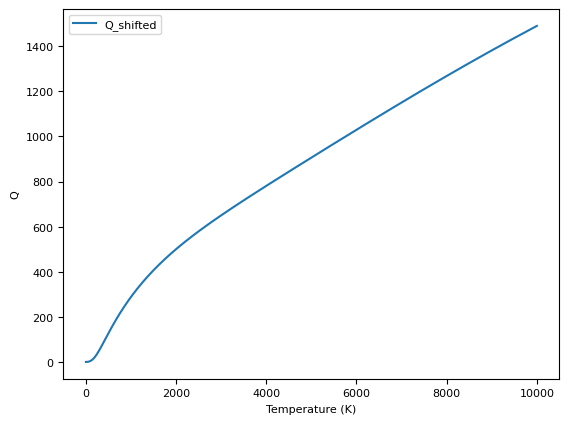

In [96]:
import matplotlib.pyplot as plt

k_B = 8.617e-5 # eV/K
temperature = np.linspace(1, 10000, 1000)
q = 0


energy_list = []

for id in all_ids:
    energy = calcs[id]['energy']/len(calcs[id]['forces'])
    #if energy > 0:
        #print(f"Energy is {energy} for id {id}, skipping")
        #continue
    #q += np.exp(-energy / (k_B * temperature))
    energy_list.append(energy)

e_min = np.min(np.array(energy_list))
shifted_energies = np.array(energy_list) - e_min

Q = []
Q_shifted = []
for temp in temperature:
    exp_terms = np.exp(-np.array(energy_list) / (k_B * temp))
    Q.append(np.sum(exp_terms))
    exp_terms_shifted = np.exp(-shifted_energies / (k_B * temp))
    Q_shifted.append(np.sum(exp_terms_shifted))



#plt.plot(temperature, Q, label="Q")
plt.plot(temperature, Q_shifted, label="Q_shifted")
plt.xlabel('Temperature (K)')
plt.ylabel('Q')
plt.legend()
plt.show()


In [93]:
from mace.calculators.mace import MACECalculator

atoms = db_manager.get_structure(20200)
model_paths = ['../potentials/mace_gen_6_ensemble/gen_7_model_0-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_1-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_2-2025-02-12_stagetwo_compiled.model']
calc = MACECalculator(model_paths, device='cpu',default_dtype='float32')

atoms.calc = calc
energy = atoms.get_potential_energy()/len(atoms)
print(energy)
prob = 1/Q * np.exp(-energy / (k_B * temperature))
prob_shifted = 1/Q_shifted * np.exp(-energy / (k_B * temperature))
print(prob)
print(prob_shifted)

/opt/homebrew/Caskroom/miniforge/base/envs/forge/lib/python3.11/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/opt/homebrew/Caskroom/miniforge/base/envs/forge/lib/python3.11/site-packages/torch/serialization.py:1434: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


Running committee mace with 3 models
-9.364039755275106


TypeError: unsupported operand type(s) for /: 'int' and 'list'

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_37996/3229242575.py:3: RuntimeWarning: overflow encountered in exp
  prob_shifted_list.append(1/Q_shifted[i] * np.exp(-energy / (k_B * temp)))


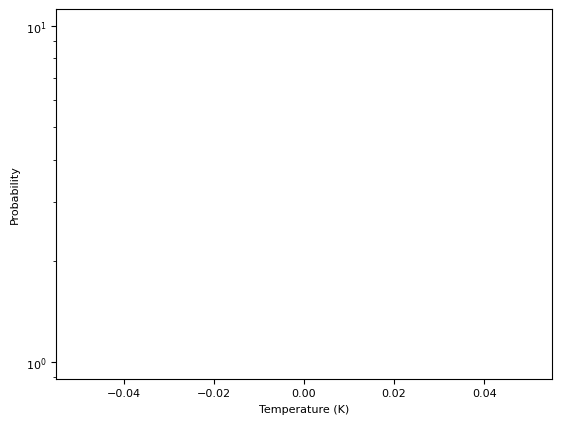

In [94]:
prob_shifted_list = []
for i,temp in enumerate(temperature):
    prob_shifted_list.append(1/Q_shifted[i] * np.exp(-energy / (k_B * temp)))


# remove the first 100 points
prob_shifted_list = prob_shifted_list[125:]
temperature = temperature[125:]

plt.plot(temperature, prob_shifted_list)
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Probability')
plt.show()


In [95]:
print(prob_shifted_list)

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

# Adding/implementing random shakes

In [15]:
gen_8_ids = db_manager.find_structures_by_metadata(metadata_filters={'generation' : '8'})

In [16]:
# get the unique parent_id values in these structures
gen_8_atoms = db_manager.get_batch_atoms_with_calculation(gen_8_ids)

In [17]:
parent_ids = [atoms.info['parent_id'] for atoms in gen_8_atoms]
unique_parent_ids = list(set(parent_ids))
print(len(unique_parent_ids))



10


In [18]:
# get the atoms for these parent ids
parent_atoms = db_manager.get_batch_atoms_with_calculation(unique_parent_ids)


In [21]:
print(parent_atoms[3])

Atoms(symbols='Zr2', pbc=True, cell=[[3.013764273, -0.204813379, -0.635579783], [-0.495777408, 2.836401624, 0.340714856], [-0.367607909, -0.04736912, 3.118686961]], forces=...)


In [26]:
pure_v = db_manager.find_structures(elements=['V'])


In [29]:
gen_6_ids = db_manager.find_structures_by_metadata(metadata_filters={'generation' : '6'})
gen_6_atoms = db_manager.get_batch_atoms_with_calculation(gen_6_ids)




In [30]:
def find_only_X_atoms(atoms_list, X_element):
    """
    Find structures in atoms_list that contain only the element X_element
    and no other elements.

    Args:
        atoms_list (list): List of ASE Atoms objects
        X_element (str): Element to check for
        
    """
    results_list = []
    for atoms in atoms_list:
        symbols = atoms.get_chemical_symbols()
        if symbols.count(X_element) == len(symbols):
            results_list.append(atoms)
    return results_list


pure_v = find_only_X_atoms(gen_6_atoms, 'V')

print(len(pure_v))

999


In [32]:
pure_w = find_only_X_atoms(gen_6_atoms, 'W')

print(len(pure_w))

996


In [33]:
print(len(gen_6_atoms))

1995


# Analyzing past AA 

In [14]:
import glob 
import os
from ase.io import read,write 
import numpy as np
from ase.visualize import view
import matplotlib.pyplot as plt

from forge.core.database import DatabaseManager

db_manager = DatabaseManager()

aa_path = '../scripts/adversarial_attacks/gen_8_no_dimers/'

xyz_files = glob.glob(os.path.join(aa_path, '*.xyz'))

In [91]:
# first, load in one of the .xyz files 

file_number = 1
atoms_list = read(xyz_files[file_number], index=':')

In [85]:
n = 1
print(atoms_list[n].calc.results['energy'])
print(type(atoms_list[n].info['structure_id']))
print(db_manager.get_calculations(int(atoms_list[n].info['structure_id']))[0]['energy'])

-10.158006477355958
<class 'numpy.int64'>
-9.908243


In [86]:
#print(len(atoms))
atoms_list[5].info['variance']

0.739263653755188

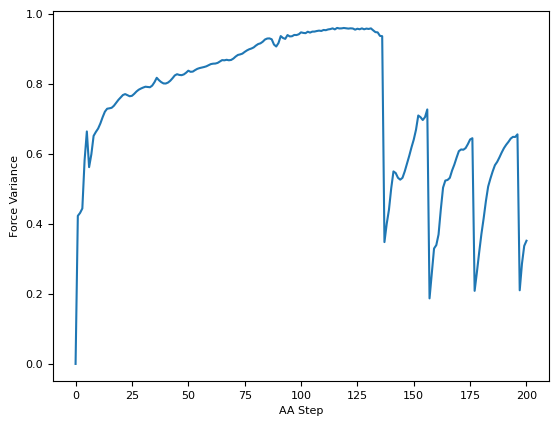

In [92]:
steps = np.arange(len(atoms_list))
variance = []
for i,atoms in enumerate(atoms_list):
    try:
        variance.append(atoms.info['variance'])
    except:
        variance.append(0)

plt.plot(steps, variance)
plt.xlabel('AA Step')
plt.ylabel('Force Variance')
plt.show()


[  5 116 156 176 196]
[0.6641287207603455, 0.9598442912101746, 0.7269167900085449, 0.644772469997406, 0.6557983160018921]


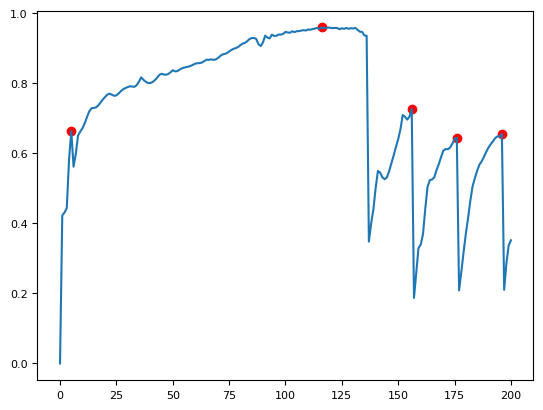

In [98]:
from scipy.signal import find_peaks 

peaks, properties = find_peaks(variance, prominence=0.1)

print(peaks)
peak_vals = [variance[i] for i in peaks]
print(peak_vals)


plt.plot(steps, variance)
plt.scatter(peaks, peak_vals, color='red')
plt.show()

(array([110, 114, 116, 119, 122, 125, 127, 129, 131]), {'peak_heights': array([0.95398158, 0.95858294, 0.95984429, 0.95969057, 0.95868731,
       0.95755297, 0.95850998, 0.95792776, 0.95852453])})


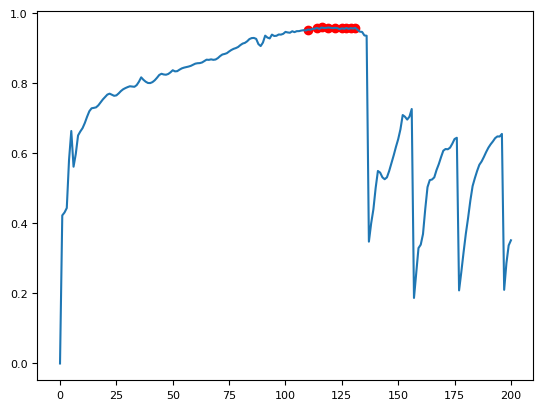

In [100]:
height_thresh = np.percentile(variance, 90)
peaks_by_height = find_peaks(variance, height=height_thresh)

print(peaks_by_height)

plt.plot(steps, variance)
plt.scatter(peaks_by_height[0], [variance[i] for i in peaks_by_height[0]], color='red')
plt.show()



[109, 113, 115, 118, 121, 124, 126, 128, 130]


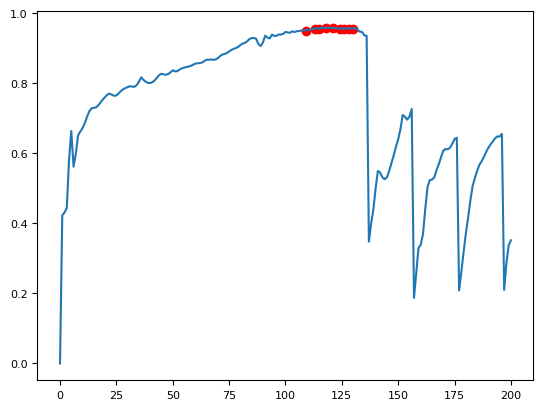

In [102]:
preceeding_points = [max(p - 1, 0) for p in peaks_by_height[0]]
print(preceeding_points)

plt.plot(steps, variance)
plt.scatter(preceeding_points, [variance[i] for i in preceeding_points], color='red')
plt.show()





[ 18  36  54  72  90 109 127 145 163 181]


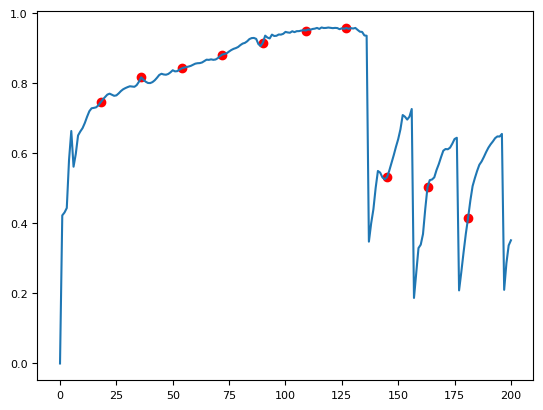

In [105]:
num_intermediate = 10  # adjustable
intermediate_points = np.linspace(0, len(variance)-1, num_intermediate+2, dtype=int)[1:-1]

print(intermediate_points)

plt.plot(steps, variance)
plt.scatter(intermediate_points, [variance[i] for i in intermediate_points], color='red')
plt.show()


Height peaks: [110 114 116 119 122 125 127 129 131]
Prominence peaks: (array([  5, 116, 156, 176, 196]), {'prominences': array([0.10202456, 0.77261271, 0.37888375, 0.43601881, 0.44542962]), 'left_bases': array([  0,   0, 137, 157, 157]), 'right_bases': array([  6, 157, 157, 177, 197])})
[5, 33, 66, 100, 110, 114, 116, 119, 122, 125, 133, 156, 166, 176, 196]


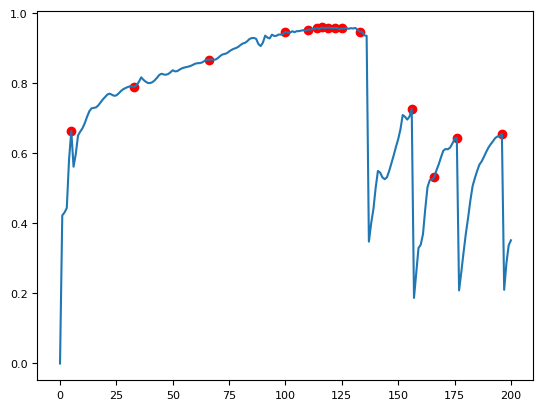

In [116]:
def sample_force_variance(force_variances, max_samples=15):

    prom_peaks = find_peaks(force_variances, prominence=0.1)
    height_thresh = np.percentile(force_variances, 90)
    height_peaks, _ = find_peaks(force_variances, height=height_thresh)

    print(f"Height peaks: {height_peaks}")
    print(f"Prominence peaks: {prom_peaks}")
    preceding_points = [max(p - 1, 0) for p in prom_peaks[0]]

    intermediate_points = np.linspace(0, len(force_variances)-1, int(max_samples/3)+2, dtype=int)[1:-1]

    all_indices = set(height_peaks.tolist() + prom_peaks[0].tolist() + preceding_points + intermediate_points.tolist())

    # If more points than allowed, prioritize peaks → preceding → intermediate
    priority_indices = prom_peaks[0].tolist() + intermediate_points.tolist() + height_peaks.tolist() + preceding_points
    sampled_indices = []
    for idx in priority_indices:
        if idx not in sampled_indices:
            sampled_indices.append(idx)
        if len(sampled_indices) >= max_samples:
            break

    return sorted(sampled_indices)


sampled_indices = sample_force_variance(variance)
print(sampled_indices)

plt.plot(steps, variance)
plt.scatter(sampled_indices, [variance[i] for i in sampled_indices], color='red')
plt.show()


# Allin one AA analysis

--- Original Data Plot ---


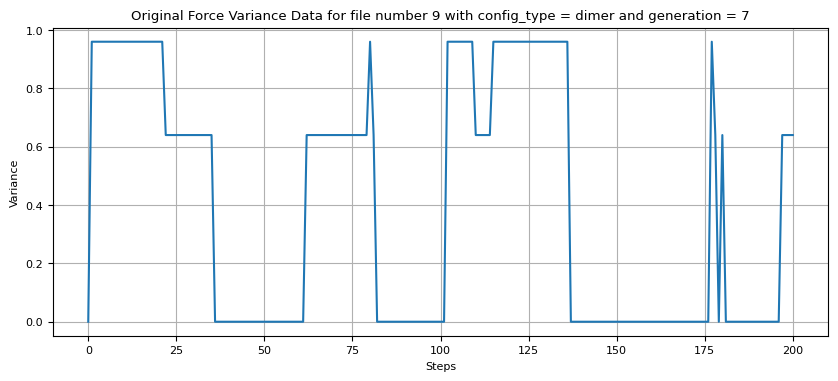


--- Sampling with Plotting ---


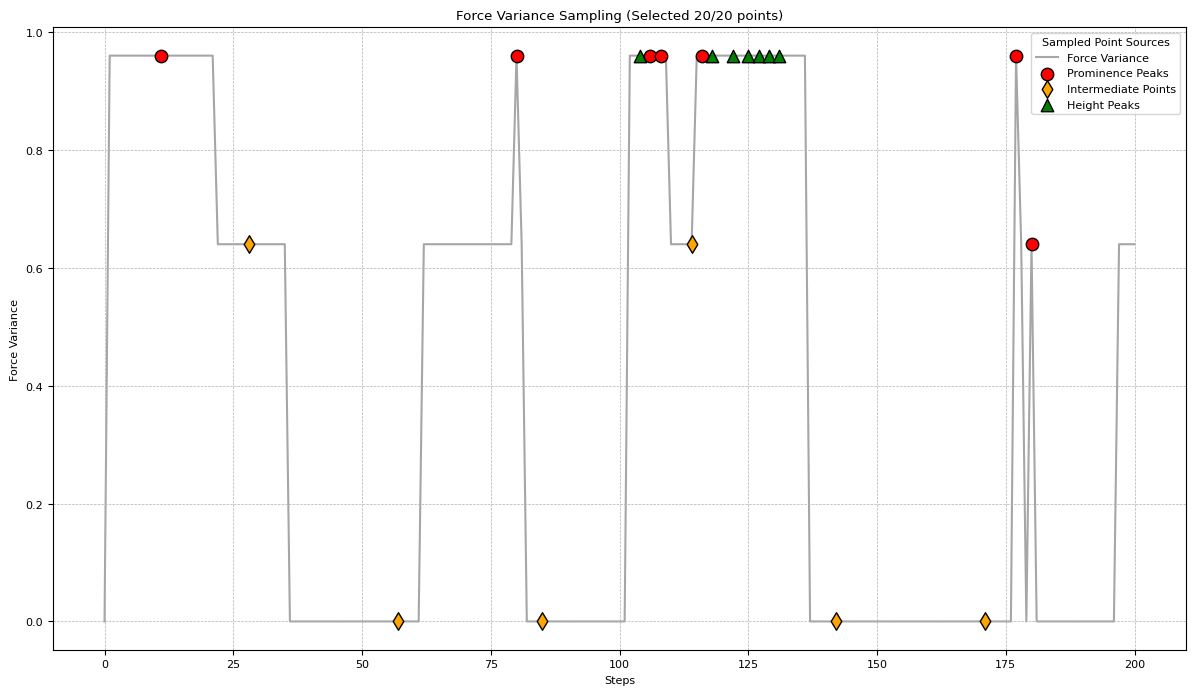


Final sampled indices: [11, 28, 57, 80, 85, 104, 106, 108, 114, 116, 118, 122, 125, 127, 129, 131, 142, 171, 177, 180]


In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import glob 
import os
from ase.io import read,write 
import numpy as np
from ase.visualize import view
import matplotlib.pyplot as plt

from forge.core.database import DatabaseManager


def sample_force_variance(force_variances, steps=None, max_samples=15, plot=False):
    """
    Samples indices from force variance data based on peaks and intermediate points.

    Args:
        force_variances (np.array): Array of force variance values.
        steps (np.array, optional): Array of corresponding step numbers for plotting.
                                    Required if plot=True. Defaults to None.
        max_samples (int, optional): Maximum number of indices to sample. Defaults to 15.
        plot (bool, optional): Whether to generate a plot showing the sampling.
                               Defaults to False.

    Returns:
        list: Sorted list of sampled indices.
    """
    if plot and steps is None:
        raise ValueError("Argument 'steps' must be provided when plot=True.")
    if plot and len(steps) != len(force_variances):
        raise ValueError("Length of 'steps' must match length of 'force_variances' for plotting.")

    # --- Identify potential points from different sources ---
    prom_peaks_indices, _ = find_peaks(force_variances, prominence=0.1)
    height_thresh = np.percentile(force_variances, 90)
    height_peaks_indices, _ = find_peaks(force_variances, height=height_thresh)
    # Ensure preceding points are unique and non-negative
    preceding_points_indices = sorted(list(set(max(p - 1, 0) for p in prom_peaks_indices)))

    # Calculate intermediate points, ensuring they are within bounds and unique
    num_intermediate = int(max_samples / 3) # How many intermediate points to aim for
    if num_intermediate > 0:
        intermediate_points_indices = np.linspace(0, len(force_variances)-1, num_intermediate + 2, dtype=int)[1:-1]
    else:
        intermediate_points_indices = np.array([], dtype=int)

    # Store sources for potential points
    source_candidates = {
        'prominence': set(prom_peaks_indices),
        'height': set(height_peaks_indices),
        'preceding': set(preceding_points_indices),
        'intermediate': set(intermediate_points_indices)
    }

    # --- Select final points based on priority ---
    # Priority order: prominence -> intermediate -> height -> preceding
    priority_order = ['prominence', 'intermediate', 'height', 'preceding']
    final_sampled_indices = []
    sampled_indices_set = set()
    source_map = {} # Track the primary source for final sampled points

    for source_key in priority_order:
        # Get indices for the current source, sort them for consistent selection order
        current_source_indices = sorted(list(source_candidates[source_key]))

        for idx in current_source_indices:
            if len(final_sampled_indices) >= max_samples:
                break # Stop if max_samples reached
            if idx not in sampled_indices_set:
                final_sampled_indices.append(idx)
                sampled_indices_set.add(idx)
                source_map[idx] = source_key # Assign the source that selected it first
        if len(final_sampled_indices) >= max_samples:
             break # Stop outer loop if max_samples reached

    final_sampled_indices.sort() # Sort the final list

    # --- Plotting (optional) ---
    if plot:
        plt.figure(figsize=(12, 7))
        # Plot original data
        plt.plot(steps, force_variances, label='Force Variance', color='grey', alpha=0.7, zorder=1)

        # Define plotting styles for each source
        plot_styles = {
            'prominence': {'color': 'red', 'marker': 'o', 'label': 'Prominence Peaks'},
            'height': {'color': 'green', 'marker': '^', 'label': 'Height Peaks'},
            'preceding': {'color': 'purple', 'marker': 's', 'label': 'Preceding Prominence'},
            'intermediate': {'color': 'orange', 'marker': 'd', 'label': 'Intermediate Points'}
        }

        plotted_final_labels = set()

        # Plot the final selected points, colored by their source
        for idx in final_sampled_indices:
            source = source_map.get(idx, 'unknown') # Find the source
            style = plot_styles.get(source)
            if style:
                label = style['label'] if source not in plotted_final_labels else None
                plt.scatter(steps[idx], force_variances[idx],
                            color=style['color'], marker=style['marker'],
                            label=label, s=80, zorder=3, edgecolors='black') # Larger, bordered points for selected
                plotted_final_labels.add(source)
            else: # Fallback for unknown source (shouldn't happen with current logic)
                 plt.scatter(steps[idx], force_variances[idx], color='black', marker='x', label='Unknown Source', s=80, zorder=3)


        # Optionally, plot *all* candidate points with smaller markers/alpha
        # for source_key, indices_set in source_candidates.items():
        #     style = plot_styles.get(source_key)
        #     if style and indices_set:
        #         valid_indices = [i for i in indices_set if i < len(force_variances)]
        #         plt.scatter(steps[valid_indices], force_variances[valid_indices],
        #                     color=style['color'], marker=style['marker'], alpha=0.3, s=30, zorder=2)


        plt.xlabel("Steps")
        plt.ylabel("Force Variance")
        plt.title(f"Force Variance Sampling (Selected {len(final_sampled_indices)}/{max_samples} points)")
        if plotted_final_labels:
             plt.legend(title="Sampled Point Sources")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    return final_sampled_indices

# --- Example Usage ---
db_manager = DatabaseManager()

aa_path = '../scripts/adversarial_attacks/gen_8/'

xyz_files = glob.glob(os.path.join(aa_path, '*.xyz'))

file_number = 9 # Change this to get different files

atoms_list = read(xyz_files[file_number], index=':')
steps = np.arange(len(atoms_list))
variance = []
for i,atoms in enumerate(atoms_list):
    try:
        variance.append(atoms.info['variance'])
    except:
        variance.append(0)


# Original indices and plot
print("--- Original Data Plot ---")
plt.figure(figsize=(10, 4))
plt.plot(steps, variance)
plt.title("Original Force Variance Data for file number " + str(file_number) + " with config_type = " + str(atoms_list[0].info['config_type']) + " and generation = " + str(atoms_list[0].info['generation']))
plt.xlabel("Steps")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

print("\n--- Sampling with Plotting ---")
# Call the function with plotting enabled
sampled_indices = sample_force_variance(variance, steps=steps, max_samples=20, plot=True)
print(f"\nFinal sampled indices: {sampled_indices}")

In [128]:
from ase.visualize import view
view(atoms_list[15], viewer='x3d')


# Take two


--- Sampling with Plateau Filtering and Plotting ---
Performing plateau filtering with displacement threshold 0.05 Å...
Removing 7 points due to similarity within plateaus: [np.int64(2), np.int64(3), np.int64(4), np.int64(11), np.int64(15), np.int64(19), np.int64(23)]


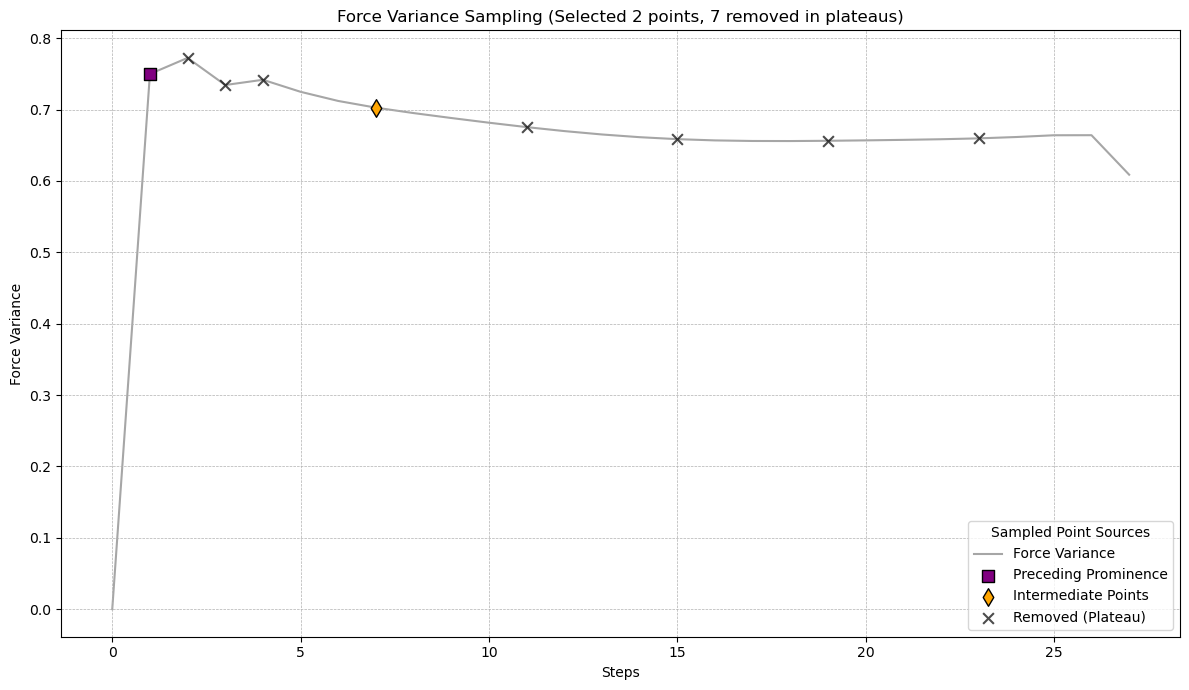


Final distinct sampled indices: [np.int64(1), np.int64(7)]
Number of distinct points: 2

--- Sampling WITHOUT Plateau Filtering (for comparison) ---


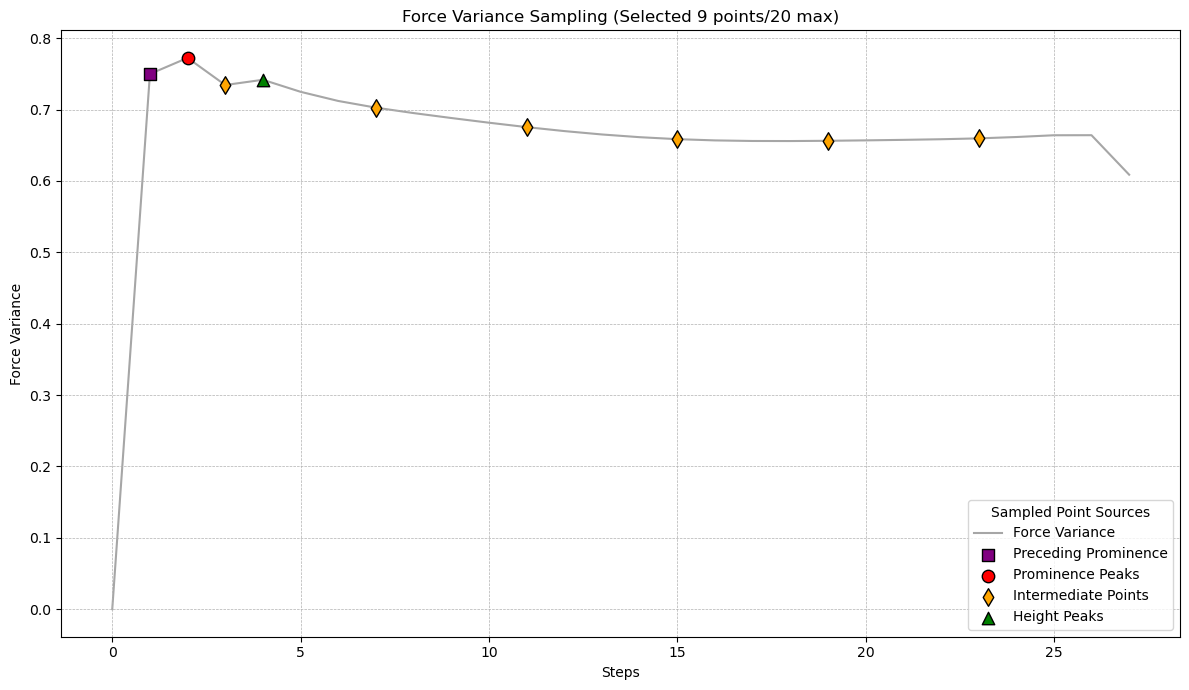


Sampled indices without filtering: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(11), np.int64(15), np.int64(19), np.int64(23)]
Number of points without filtering: 9


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ase import Atoms # Make sure Atoms is imported if not already

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import glob 
import os
from ase.io import read,write 
import numpy as np
from ase.visualize import view
import matplotlib.pyplot as plt

from forge.core.database import DatabaseManager

def find_plateaus(data, threshold):
    """Finds contiguous segments where the absolute difference is below a threshold."""
    diffs = np.abs(np.diff(data))
    in_plateau = diffs < threshold
    plateaus = []
    start_idx = -1
    for i in range(len(in_plateau)):
        if in_plateau[i] and start_idx == -1:
            start_idx = i # Plateau starts at the first point of the low-diff pair
        elif not in_plateau[i] and start_idx != -1:
            # Plateau ends at the second point of the last low-diff pair
            plateaus.append((start_idx, i))
            start_idx = -1
    # Handle plateau extending to the end
    if start_idx != -1:
        plateaus.append((start_idx, len(data) - 1))
    # Return segments as lists of indices
    plateau_indices = [list(range(start, end + 1)) for start, end in plateaus if end > start]
    return plateau_indices

def compare_atoms_displacement(atoms1, atoms2, min_displacement_threshold):
    """
    Compares two Atoms objects. Returns True if they are distinct enough, False otherwise.
    Distinct enough means max displacement >= min_displacement_threshold.
    Assumes atoms are ordered consistently.
    NOTE: This simple version doesn't robustly handle PBCs for displacement vectors.
          It's suitable if atoms don't cross boundaries significantly between compared steps.
    """
    if len(atoms1) != len(atoms2) or atoms1.get_chemical_symbols() != atoms2.get_chemical_symbols():
        return True # Different number or type of atoms -> distinct

    displacements = atoms2.positions - atoms1.positions
    # Basic PBC wrap - might not be perfect for large displacements across boundaries
    # For small steps within a plateau, it's often okay.
    # atoms1.wrap(displacements) # Use wrap method of one of the objects

    max_disp = np.max(np.linalg.norm(displacements, axis=1))

    return max_disp >= min_displacement_threshold

def sample_force_variance(
    force_variances,
    atoms_trajectory=None, # List of Atoms objects corresponding to variances
    steps=None,
    max_samples=15,
    plot=False,
    plateau_threshold=1e-4, # Threshold to define a variance plateau
    min_displacement_threshold=0.05 # Min Angstrom displacement to consider distinct
    ):
    """
    Samples indices from force variance data based on peaks and intermediate points,
    optionally filtering points within plateaus that are too similar structurally.

    Args:
        force_variances (np.array): Array of force variance values.
        atoms_trajectory (list[Atoms], optional): List of ASE Atoms objects for each step.
                                                  Required if plateau filtering is desired.
        steps (np.array, optional): Array of corresponding step numbers for plotting.
                                    Required if plot=True. Defaults to None.
        max_samples (int, optional): Maximum number of indices to sample. Defaults to 15.
        plot (bool, optional): Whether to generate a plot showing the sampling.
                               Defaults to False.
        plateau_threshold (float, optional): Max variance diff between consecutive points
                                             to be considered part of a plateau. Defaults to 1e-4.
        min_displacement_threshold (float, optional): Minimum max atomic displacement (Angstrom)
                                                      for points within a plateau to be kept. Defaults to 0.05.

    Returns:
        list: Sorted list of sampled indices.
    """
    n_points = len(force_variances)
    if plot and steps is None:
        raise ValueError("Argument 'steps' must be provided when plot=True.")
    if plot and len(steps) != n_points:
        raise ValueError("Length of 'steps' must match length of 'force_variances' for plotting.")
    if atoms_trajectory is not None and len(atoms_trajectory) != n_points:
         raise ValueError("Length of 'atoms_trajectory' must match length of 'force_variances'.")

    # --- Identify potential points from different sources ---
    prom_peaks_indices, _ = find_peaks(force_variances, prominence=0.1)
    height_thresh = np.percentile(force_variances, 90)
    height_peaks_indices, _ = find_peaks(force_variances, height=height_thresh)
    preceding_points_indices = sorted(list(set(max(p - 1, 0) for p in prom_peaks_indices)))

    num_intermediate = int(max_samples / 3)
    if num_intermediate > 0:
        intermediate_points_indices = np.linspace(0, n_points-1, num_intermediate + 2, dtype=int)[1:-1]
    else:
        intermediate_points_indices = np.array([], dtype=int)

    source_candidates = {
        'prominence': set(prom_peaks_indices),
        'height': set(height_peaks_indices),
        'preceding': set(preceding_points_indices),
        'intermediate': set(intermediate_points_indices)
    }

    # --- Initial Selection based on priority ---
    priority_order = ['prominence', 'intermediate', 'height', 'preceding']
    initial_sampled_indices = []
    initial_sampled_set = set()
    source_map = {}

    for source_key in priority_order:
        current_source_indices = sorted(list(source_candidates[source_key]))
        for idx in current_source_indices:
            if len(initial_sampled_indices) >= max_samples: break
            if idx not in initial_sampled_set:
                initial_sampled_indices.append(idx)
                initial_sampled_set.add(idx)
                source_map[idx] = source_key
        if len(initial_sampled_indices) >= max_samples: break

    initial_sampled_indices.sort()
    final_sampled_indices = list(initial_sampled_indices) # Start with initial selection
    indices_removed_plateau = set()

    # --- Plateau Filtering (if trajectory provided) ---
    if atoms_trajectory:
        print(f"Performing plateau filtering with displacement threshold {min_displacement_threshold} Å...")
        plateau_segments = find_plateaus(force_variances, plateau_threshold)
        # print(f"Found {len(plateau_segments)} plateau segments.")

        indices_to_potentially_remove = set()

        for plateau in plateau_segments:
            # Find which of the *initially* sampled points fall in this plateau
            sampled_in_plateau = sorted([idx for idx in initial_sampled_indices if idx in plateau])

            # print(f"  Plateau {plateau[0]}-{plateau[-1]}: Initially sampled points {sampled_in_plateau}")

            if len(sampled_in_plateau) > 1:
                last_kept_idx = sampled_in_plateau[0] # Always keep the first one
                for i in range(1, len(sampled_in_plateau)):
                    current_idx = sampled_in_plateau[i]
                    atoms1 = atoms_trajectory[last_kept_idx]
                    atoms2 = atoms_trajectory[current_idx]

                    if not compare_atoms_displacement(atoms1, atoms2, min_displacement_threshold):
                        # Current point is too similar to the last kept one, mark for removal
                        indices_to_potentially_remove.add(current_idx)
                        # print(f"    Marking index {current_idx} for removal (similar to {last_kept_idx})")
                    else:
                        # Current point is distinct enough, update the last kept point
                        last_kept_idx = current_idx
                        # print(f"    Keeping index {current_idx} (distinct from {sampled_in_plateau[i-1]})")


        # Remove the marked indices from the final list
        if indices_to_potentially_remove:
             print(f"Removing {len(indices_to_potentially_remove)} points due to similarity within plateaus: {sorted(list(indices_to_potentially_remove))}")
             final_sampled_indices = [idx for idx in initial_sampled_indices if idx not in indices_to_potentially_remove]
             indices_removed_plateau = indices_to_potentially_remove
        else:
             print("No points removed during plateau filtering.")


    # --- Plotting (optional) ---
    if plot:
        plt.figure(figsize=(12, 7))
        plt.plot(steps, force_variances, label='Force Variance', color='grey', alpha=0.7, zorder=1)

        plot_styles = {
            'prominence': {'color': 'red', 'marker': 'o', 'label': 'Prominence Peaks'},
            'height': {'color': 'green', 'marker': '^', 'label': 'Height Peaks'},
            'preceding': {'color': 'purple', 'marker': 's', 'label': 'Preceding Prominence'},
            'intermediate': {'color': 'orange', 'marker': 'd', 'label': 'Intermediate Points'}
        }
        removed_style = {'color': 'black', 'marker': 'x', 'label': 'Removed (Plateau)', 's': 60, 'zorder': 2, 'alpha': 0.7}

        plotted_final_labels = set()
        plotted_removed = False

        # Plot final selected points
        for idx in final_sampled_indices:
             # Check if this point was originally selected (it must have been)
            source = source_map.get(idx, 'unknown')
            style = plot_styles.get(source)
            if style:
                label = style['label'] if source not in plotted_final_labels else None
                plt.scatter(steps[idx], force_variances[idx],
                            color=style['color'], marker=style['marker'],
                            label=label, s=80, zorder=3, edgecolors='black')
                plotted_final_labels.add(source)
            else:
                 plt.scatter(steps[idx], force_variances[idx], color='blue', marker='*', label='Unknown Source', s=80, zorder=3) # Fallback


        # Plot points removed due to plateau similarity
        for idx in sorted(list(indices_removed_plateau)):
             label = removed_style['label'] if not plotted_removed else None
             plt.scatter(steps[idx], force_variances[idx],
                         color=removed_style['color'], marker=removed_style['marker'],
                         label=label, s=removed_style['s'], zorder=removed_style['zorder'], alpha=removed_style['alpha'])
             plotted_removed = True


        title = f"Force Variance Sampling (Selected {len(final_sampled_indices)} points"
        if atoms_trajectory:
             title += f", {len(indices_removed_plateau)} removed in plateaus)"
        else:
             title += f"/{max_samples} max)"

        plt.xlabel("Steps")
        plt.ylabel("Force Variance")
        plt.title(title)

        handles, labels = plt.gca().get_legend_handles_labels()
        # Create a unique legend
        by_label = dict(zip(labels, handles))
        if by_label:
             plt.legend(by_label.values(), by_label.keys(), title="Sampled Point Sources")

        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    return sorted(final_sampled_indices)


# --- Example Usage ---
db_manager = DatabaseManager()

aa_path = '../data/adversarial_attacks/gen_8_no_dimers/'

xyz_files = glob.glob(os.path.join(aa_path, '*.xyz'))

file_number = 10 # Change this to get different files

atoms_list = read(xyz_files[file_number], index=':')
steps = np.arange(len(atoms_list))
variance = []
for i,atoms in enumerate(atoms_list):
    try:
        variance.append(atoms.info['variance'])
    except:
        variance.append(0)

# --- Run Sampling ---
print("\n--- Sampling with Plateau Filtering and Plotting ---")
sampled_indices = sample_force_variance(
    variance,
    atoms_trajectory=atoms_list, # Pass the trajectory
    steps=steps,
    max_samples=20,
    plot=True,
    plateau_threshold=0.05, # Adjust based on your data's noise level
    min_displacement_threshold=0.05 # Keep 0.05 Angstrom
)
print(f"\nFinal distinct sampled indices: {sampled_indices}")
print(f"Number of distinct points: {len(sampled_indices)}")

print("\n--- Sampling WITHOUT Plateau Filtering (for comparison) ---")
sampled_indices_no_filter = sample_force_variance(
    variance,
    atoms_trajectory=None, # Don't pass trajectory
    steps=steps,
    max_samples=20,
    plot=True,
)
print(f"\nSampled indices without filtering: {sampled_indices_no_filter}")
print(f"Number of points without filtering: {len(sampled_indices_no_filter)}")

## Playing with Mace

In [17]:
from mace.modules.models import MACE
from mace import data, modules, tools
import numpy as np
import torch
import torch.nn.functional
from e3nn import o3
from matplotlib import pyplot as plt
import ase.io
%matplotlib inline
from ase.visualize import view
from scipy.spatial.transform import Rotation

from mace.tools import torch_geometric
torch.set_default_dtype(torch.float64)
import warnings
warnings.filterwarnings("ignore")

# setup some default prameters
z_table = tools.AtomicNumberTable([22, 23, 24,40, 74])
e0s_str = {22: -2.15203187, 23 : -3.55411419, 24 : -5.42767241, 40 : -2.3361286, 74 : -4.55186158}
atomic_energies = np.array([e0s_str[z] for z in z_table.zs], dtype=float)
cutoff = 5.0

default_model_config = dict(
        num_elements=5,  # number of chemical elements
        atomic_energies=atomic_energies,  # atomic energies used for normalisation
        avg_num_neighbors=8,  # avg number of neighbours of the atoms, used for internal normalisation of messages
        atomic_numbers=z_table.zs,  # atomic numbers, used to specify chemical element embeddings of the model
        r_max=cutoff,  # cutoff
        num_bessel=8,  # number of radial features
        num_polynomial_cutoff=6,  # smoothness of the radial cutoff
        max_ell=2,  # expansion order of spherical harmonic adge attributes
        num_interactions=2,  # number of layers, typically 2
        interaction_cls_first=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interation block of first layer
        interaction_cls=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interaction block of subsequent layers
        hidden_irreps=o3.Irreps("8x0e "),  # 8: number of embedding channels, 0e, 1o is specifying which equivariant messages to use. Here up to L_max=1
        correlation=3,  # correlation order of the messages (body order - 1)
        MLP_irreps=o3.Irreps("16x0e"),  # number of hidden dimensions of last layer readout MLP
        gate=torch.nn.functional.silu,  # nonlinearity used in last layer readout MLP
    )
default_model = modules.MACE(**default_model_config)


In [18]:
embed_test_atoms = atoms_list[100].copy()

config = data.Configuration(
    atomic_numbers = embed_test_atoms.numbers,
    positions=embed_test_atoms.positions
)

batch = data.AtomicData.from_config(config, z_table, cutoff)
print("positions", batch.positions)
print("node_attrs", batch.node_attrs)
print("edge_index", batch.edge_index)

IndexError: list index out of range

In [154]:
vectors, lengths = modules.utils.get_edge_vectors_and_lengths(
    positions=batch['positions'],
    edge_index=batch['edge_index'],
    shifts=batch['shifts']
)

print(f'there are {batch.positions.shape[0]} nodes and {len(lengths)} edges')
print(f'lengths is shape {lengths.shape}')
print(f'vectors is shape {vectors.shape}')

there are 6 nodes and 22 edges
lengths is shape torch.Size([22, 1])
vectors is shape torch.Size([22, 3])


In [155]:
model = modules.MACE(**default_model_config)
initial_node_features = model.node_embedding(batch.node_attrs)
edge_features = model.radial_embedding(lengths, batch["node_attrs"], batch["edge_index"], z_table)
edge_attributes = model.spherical_harmonics(vectors)

print('initial_node_features is (num_atoms, num_channels):', initial_node_features.shape)
print('edge_features is (num_edge, num_bessel_func):', edge_features.shape)
print('edge_attributes is (num_edge, dimension of spherical harmonics):', edge_attributes.shape)
print(
    '\nInitial node features. Note that they are the same for each chemical element\n',
    initial_node_features
)

initial_node_features is (num_atoms, num_channels): torch.Size([6, 8])
edge_features is (num_edge, num_bessel_func): torch.Size([22, 8])
edge_attributes is (num_edge, dimension of spherical harmonics): torch.Size([22, 9])

Initial node features. Note that they are the same for each chemical element
 tensor([[ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722]],
       grad_fn=<ViewBackward0>)


# UMAP with Mace Descriptors

In [19]:
from mace.calculators.mace import MACECalculator

model_paths = '../potentials/mace_gen_7_ensemble/job_gen_7-2025-04-14_model_0_pr_stagetwo.model'
calc = MACECalculator(model_paths=model_paths, default_dtype='float32', device='cuda')


test_atoms = atoms_list[20].copy()
descriptors = calc.get_descriptors(test_atoms, num_layers=-1, invariants_only=False)
print(descriptors)
print(descriptors.shape)
len(test_atoms)

[[ 0.4628175  -0.5578918   0.540442   ...  0.09750387 -0.4263672
  -0.25794742]
 [ 0.4663785  -0.5521859   0.5372865  ...  0.09776258 -0.43514693
  -0.25400665]
 [ 0.42542353 -0.47999954  0.5775206  ...  0.05241594 -0.6280101
  -0.16889134]
 ...
 [ 0.42961752 -0.53740215  0.5646897  ...  0.07391402 -0.587343
  -0.20515397]
 [ 0.42876863 -0.52763474  0.5698247  ...  0.06940067 -0.5915178
  -0.19998768]
 [ 0.42895472 -0.5296535   0.57032627 ...  0.0693033  -0.5917367
  -0.20025085]]
(8, 256)


8

In [20]:
import numpy as np
from sklearn.cluster import KMeans
import umap # umap-learn package
import matplotlib.pyplot as plt
from ase import Atoms # Assuming ase.Atoms objects

# Keep the helper functions find_plateaus and compare_atoms_displacement if you still need them
# (They are not directly relevant to *this* specific error, but might be used later)

def select_diverse_high_variance_structures(
    atoms_list: list[Atoms],
    force_variances: list[float] | np.ndarray,
    atomic_embeddings: list[np.ndarray], # Now explicitly a list of N_atoms x embedding_dim arrays
    n_select: int,
    aggregation_method: str = 'mean', # Added: 'mean' or 'sum'
    umap_neighbors: int = 15,
    umap_min_dist: float = 0.1,
    random_state: int = 42,
    plot: bool = False
) -> list[int]:
    """
    Selects N diverse, high-uncertainty structures using embeddings and variance.

    Steps:
    1. Aggregate per-atom embeddings into per-structure embeddings (mean or sum).
    2. Apply UMAP for dimensionality reduction to 2D.
    3. Perform KMeans clustering on the 2D UMAP projection.
    4. Select the structure with the highest force variance from each cluster.

    Args:
        atoms_list: List of ASE Atoms objects.
        force_variances: List or array of force variance values for each structure.
        atomic_embeddings: List of per-atom embedding arrays (shape N_atoms x embedding_dim).
        n_select: The target number of diverse structures to select.
        aggregation_method: How to aggregate per-atom embeddings ('mean' or 'sum'). Defaults to 'mean'.
        umap_neighbors: UMAP hyperparameter: number of neighbors.
        umap_min_dist: UMAP hyperparameter: minimum distance between points.
        random_state: Random seed for UMAP and KMeans for reproducibility.
        plot: If True, generate a plot of the UMAP projection and selection.

    Returns:
        List of indices corresponding to the selected structures in the input lists.

    Raises:
        ValueError: If input list lengths do not match, n_select is invalid, or
                    aggregation_method is unknown.
    """
    n_structures = len(atoms_list)
    if not (n_structures == len(force_variances) == len(atomic_embeddings)):
        raise ValueError("Input lists (atoms_list, force_variances, atomic_embeddings) must have the same length.")
    if n_select <= 0:
        raise ValueError("n_select must be a positive integer.")
    if n_structures == 0:
        return []

    # --- Step 1: Aggregate Per-Atom Embeddings ---
    aggregated_embeddings = []
    embedding_dim = -1
    print(f"Aggregating per-atom embeddings using '{aggregation_method}' method...")
    for i, emb_array in enumerate(atomic_embeddings):
        if not isinstance(emb_array, np.ndarray) or emb_array.ndim != 2:
             raise ValueError(f"Item {i} in atomic_embeddings is not a 2D numpy array.")
        if embedding_dim == -1:
             embedding_dim = emb_array.shape[1]
        elif emb_array.shape[1] != embedding_dim:
             raise ValueError(f"Inconsistent embedding dimension found at index {i}. Expected {embedding_dim}, got {emb_array.shape[1]}.")

        if aggregation_method == 'mean':
            aggregated_embeddings.append(np.mean(emb_array, axis=0))
        elif aggregation_method == 'sum':
            aggregated_embeddings.append(np.sum(emb_array, axis=0))
        else:
            raise ValueError(f"Unknown aggregation_method: {aggregation_method}. Choose 'mean' or 'sum'.")

    # This will be the 2D array UMAP expects
    aggregated_embeddings_np = np.array(aggregated_embeddings) # Shape (n_structures, embedding_dim)
    print(f"Aggregation complete. Shape of aggregated embeddings: {aggregated_embeddings_np.shape}")


    # Handle case where fewer structures than requested are available AFTER aggregation
    if n_structures <= n_select:
        print(f"Warning: Number of structures ({n_structures}) is less than or equal to n_select ({n_select}). Returning all structure indices.")
        # Optional plotting remains similar, but uses aggregated_embeddings_np for UMAP
        if plot and n_structures > 0:
             try:
                  reducer = umap.UMAP(
                      n_neighbors=min(umap_neighbors, n_structures - 1) if n_structures > 1 else 1,
                      n_components=2,
                      min_dist=umap_min_dist,
                      random_state=random_state,
                      n_jobs=1,
                  )
                  # Use the aggregated embeddings here
                  embeddings_2d = reducer.fit_transform(aggregated_embeddings_np)

                  plt.figure(figsize=(10, 8))
                  scatter = plt.scatter(
                      embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=force_variances, cmap='viridis', s=50, alpha=0.7
                  )
                  plt.colorbar(scatter, label='Force Variance')
                  plt.title(f"UMAP Projection (All {n_structures} Points Selected)")
                  plt.xlabel("UMAP 1")
                  plt.ylabel("UMAP 2")
                  plt.grid(True, linestyle='--', alpha=0.5)
                  plt.show()
             except Exception as e:
                  print(f"Warning: Plotting failed for small dataset: {e}")
        return list(range(n_structures))

    # Ensure variance data is a numpy array
    variances_np = np.array(force_variances)

    # --- Step 2: Dimensionality Reduction with UMAP ---
    # Use the aggregated embeddings
    print(f"Running UMAP on {n_structures} aggregated embeddings (dim={aggregated_embeddings_np.shape[1]}) to 2D...")
    reducer = umap.UMAP(
        n_neighbors=umap_neighbors,
        n_components=2,
        min_dist=umap_min_dist,
        random_state=random_state,
        n_jobs=1,
    )
    embeddings_2d = reducer.fit_transform(aggregated_embeddings_np) # Use aggregated
    print("UMAP finished.")

    # --- Step 3: Clustering with KMeans ---
    n_clusters = n_select
    print(f"Running KMeans clustering with k={n_clusters} on 2D UMAP embeddings...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    cluster_labels = kmeans.fit_predict(embeddings_2d)
    print("KMeans finished.")

    # --- Step 4: Select Highest Variance from Each Cluster ---
    selected_indices_map = {} # {cluster_id: (best_variance, best_index)}
    for i in range(n_structures):
        cluster_id = cluster_labels[i]
        variance = variances_np[i]
        if cluster_id not in selected_indices_map or variance > selected_indices_map[cluster_id][0]:
            selected_indices_map[cluster_id] = (variance, i)

    final_selected_indices = sorted([data[1] for data in selected_indices_map.values()])

    num_actually_selected = len(final_selected_indices)
    if num_actually_selected < n_select:
        print(f"Warning: Only able to select {num_actually_selected} structures (expected {n_select}). Some clusters might have been empty.")

    # --- Step 5: Optional Plotting ---
    if plot:
        plt.figure(figsize=(12, 9))
        scatter_all = plt.scatter(
            embeddings_2d[:, 0], embeddings_2d[:, 1],
            c=cluster_labels, cmap='viridis', s=30, alpha=0.5, label='All Points (colored by cluster)'
        )
        selected_embeddings_2d = embeddings_2d[final_selected_indices]
        selected_variances = variances_np[final_selected_indices]

        scatter_selected = plt.scatter(
             selected_embeddings_2d[:, 0], selected_embeddings_2d[:, 1],
             c=selected_variances, cmap='coolwarm', s=100,
             edgecolors='black', marker='o',
             label=f'Selected (n={len(final_selected_indices)})', zorder=3
        )
        cbar = plt.colorbar(scatter_selected, label='Force Variance of Selected')
        cbar.ax.set_ylabel('Force Variance of Selected', fontsize=14)
        cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick font size
        cbar.set_label('Force Variance of Selected', fontsize=14)  # Increase colorbar label font size
        plt.title(f"UMAP Projection (Aggregated='{aggregation_method}'), KMeans (k={n_clusters}), and High-Variance Selection", fontsize=18)
        plt.xlabel("UMAP Dimension 1", fontsize=14)
        plt.ylabel("UMAP Dimension 2", fontsize=14)
        plt.legend(fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    print(f"Selected {len(final_selected_indices)} diverse structures.")
    return final_selected_indices




Loading atoms from: ../data/adversarial_attacks/gen_8_no_dimers/structure_20686.xyz
Loaded 27 structures.
First atom: Atoms(symbols='Cr8', pbc=True, cell=[[4.511714004, -0.068255211, -0.064985898], [0.070739322, 4.629919029, -0.0685183], [-0.01323924, 0.00141212, 4.534680908]], calculator=SinglePointCalculator(...))
Calculating embeddings and extracting variances...
Number of variance entries: 27
Number of embedding entries: 27
Input counts: Structures=27
Aggregating per-atom embeddings using 'mean' method...
Aggregation complete. Shape of aggregated embeddings: (27, 256)
Running UMAP on 27 aggregated embeddings (dim=256) to 2D...
UMAP finished.
Running KMeans clustering with k=15 on 2D UMAP embeddings...
KMeans finished.


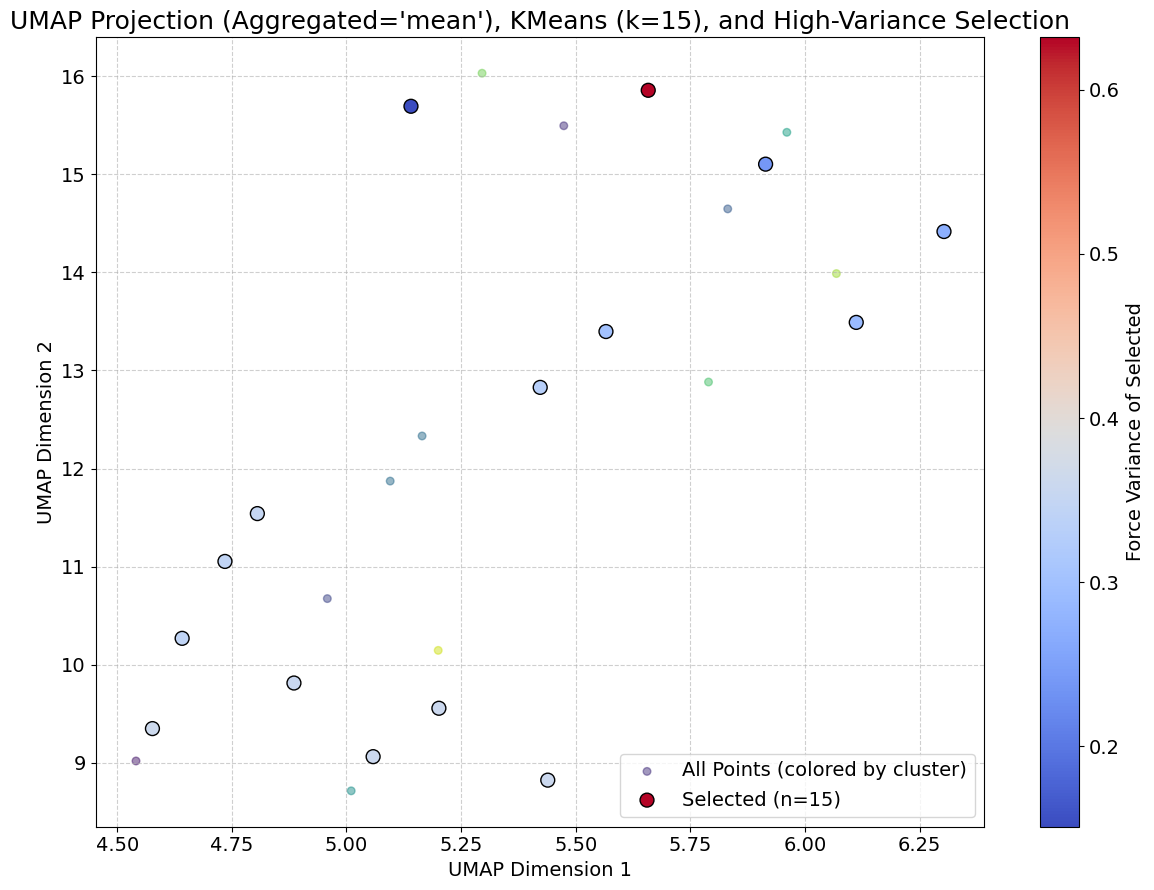

Selected 15 diverse structures.

Selected Indices: [1, 3, 5, 7, 9, 10, 12, 15, 16, 18, 20, 21, 22, 24, 26]
Selected 15 atoms.


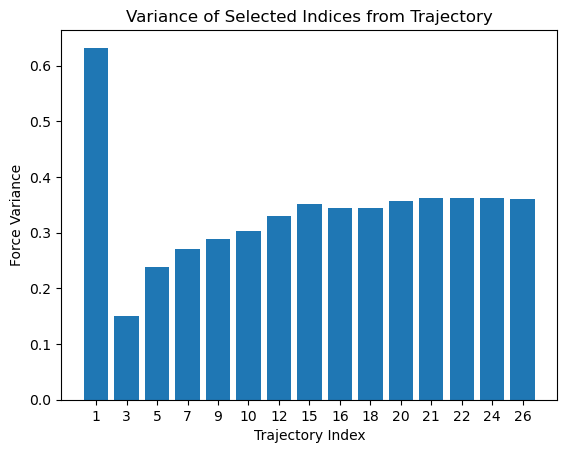

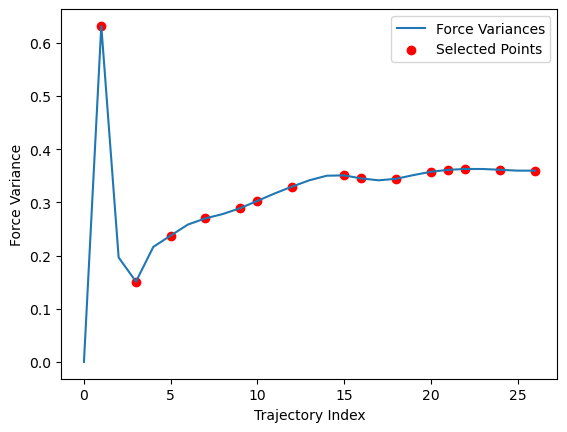

In [24]:
# --- Your Example Usage Code (Modified slightly for clarity) ---
import glob
import os
from ase.io import read
from forge.core.database import DatabaseManager # Assuming this is correct path
from mace.calculators.mace import MACECalculator
import torch

# Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_paths = '../potentials/mace_gen_7_ensemble/job_gen_7-2025-04-14_model_0_pr_stagetwo.model'
calculator = MACECalculator(model_paths=model_paths, default_dtype='float32', device=device)
db_manager = DatabaseManager() # If needed for other things, otherwise remove
aa_path = '../data/adversarial_attacks/gen_8_no_dimers/'
N_SELECT = 15
file_number = 20 # Change this to get different files

# Load data
xyz_files = sorted(glob.glob(os.path.join(aa_path, '*.xyz'))) # Sort for consistency
if file_number >= len(xyz_files):
    print(f"Error: file_number {file_number} is out of range for found xyz files ({len(xyz_files)}).")
else:
    print(f"Loading atoms from: {xyz_files[file_number]}")
    atoms_list = read(xyz_files[file_number], index=':')
    print(f"Loaded {len(atoms_list)} structures.")
    print(f"First atom: {atoms_list[0]}")

    # Extract variances and calculate embeddings
    variances = []
    raw_embeddings = [] # Store the list of (N_atoms, dim) arrays
    print("Calculating embeddings and extracting variances...")
    for i, atoms in enumerate(atoms_list):
        try:
            variances.append(atoms.info['variance'])
        except KeyError:
            print(f"Warning: 'variance' key not found in atoms.info for structure index {i}. Setting variance to 0.")
            variances.append(0.0) # Append float 0.0

        # Calculate per-atom embeddings
        # Ensure atoms object is suitable for calculator (e.g., has calculator assigned if needed by get_descriptors)
        try:
             # It's often better to pass the atoms object directly if the calculator supports it
             desc = calculator.get_descriptors(atoms)
             if desc is None or not isinstance(desc, np.ndarray) or desc.ndim != 2:
                  print(f"Warning: Received invalid descriptor (shape {desc.shape if isinstance(desc, np.ndarray) else type(desc)}) for structure index {i}. Skipping.")
                  # Need to handle this case - either skip the structure or assign a default
                  # For now, let's skip (requires adjusting list lengths later, or pre-filtering)
                  # A simpler approach for now might be to assign a zero vector, but this could skew UMAP
                  # Let's stick to raising an error if needed later, for now assume it returns correctly.
                  # If get_descriptors returns None, handle it
                  if desc is None:
                       raise ValueError(f"get_descriptors returned None for structure {i}")
             raw_embeddings.append(desc)
        except Exception as e:
             print(f"Error getting descriptors for structure index {i}: {e}")
             # Decide how to handle this error, e.g., skip the structure
             # For now, re-raise to stop execution if descriptors fail
             raise e


    variances_np = np.array(variances)
    # Note: raw_embeddings is a list of 2D arrays

    print(f"Number of variance entries: {len(variances_np)}")
    print(f"Number of embedding entries: {len(raw_embeddings)}")

    # Ensure consistency after potential errors/warnings
    if len(variances_np) != len(raw_embeddings):
         print("Error: Mismatch between number of variances and embeddings obtained. Exiting.")
         # Handle this appropriately - maybe filter atoms_list too if structures were skipped.
    else:
         N_STRUCTURES = len(atoms_list)
         print(f"Input counts: Structures={N_STRUCTURES}")
         # Pass the list of 2D arrays to the function
         selected_idx = select_diverse_high_variance_structures(
             atoms_list=atoms_list,
             force_variances=variances_np,
             atomic_embeddings=raw_embeddings, # Pass the list of (N, 256) arrays
             n_select=N_SELECT,
             aggregation_method='mean', # Specify aggregation
             plot=True,
             random_state=42
         )

         print("\nSelected Indices:", selected_idx)
         if selected_idx:
             selected_atoms = [atoms_list[i] for i in selected_idx]
             selected_vars = variances_np[selected_idx]
             print(f"Selected {len(selected_atoms)} atoms.")


selected_variances = [variances[idx] for idx in selected_idx]
plt.figure()
plt.bar(np.array(selected_idx, dtype='str'), selected_variances)
plt.xlabel('Trajectory Index')
plt.ylabel('Force Variance')
plt.title('Variance of Selected Indices from Trajectory')
plt.show()


plt.figure()
plt.plot(range(len(atoms_list)), variances, label='Force Variances')
plt.scatter(selected_idx, selected_variances, label='Selected Points', color='red')
plt.xlabel('Trajectory Index')
plt.ylabel('Force Variance')
plt.legend()
plt.show()

In [185]:
view(atoms_list[78], viewer='x3d')

silly_atom = atoms_list[78].copy()
silly_atom.calc = calculator
silly_atom.get_forces()


In [26]:
print(len(atoms_list))
print(atoms_list[5].info)

27
{'generation': np.int64(8), 'composition': 'Cr8', 'config_type': 'A15_aa', 'source_path': 'V-Cr-Ti-W-Zr/Fixed_Engrads/vcrtiwzr_fin_engrads/job_gen_7-2025-02-12/Cr/Cr8_A15_idx_2809', 'date_processed': '2025-02-12T16:44:50.535591', 'structure_index': np.int64(2809), 'structure_id': np.int64(20686), 'calculation_info': {'calculation_id': 20685, 'calculator': 'vasp', 'calculation_source_path': '', 'error': None, 'status': 'completed', 'gpu_count': None, 'parameters': {}, 'date_started': None, 'gpu_memory_mb': None, 'model_version': None, 'date_completed': None, 'runtime_seconds': None}, 'parent_id': np.int64(20686), 'step': np.int64(4), 'variance': np.float64(0.23762527108192444), 'loss': np.float64(0.23762527108192444)}


# Using the new AAANalysis Class

In [45]:
import glob, os
import torch
from forge.analysis.aa_selection import AAAnalyzer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    use_cueq = True
else:
    use_cueq = False

data_path = '../data/adversarial_attacks/gen_8_no_dimers'
model_paths = '../potentials/gen_6_model_0_L0_isolated-2026-01-16-finetuned_fp64_nh10000_lr1e-4_stagetwo.model'

xyz_files = glob.glob(os.path.join(data_path, '*.xyz'))

atoms_list = read(xyz_files[3], index=':')

calculator = MACECalculator(model_paths=model_paths, default_dtype='float32', device=device, use_cueq=use_cueq)



Default dtype float32 does not match model dtype float64, converting models to float32.


In [46]:
aa_analyzer = AAAnalyzer(atoms_list, calculator)
aa_analyzer.calculate_embeddings()

AAAnalyzer initialized with 27 structures.
Calculating MACE descriptors for 27 structures...
Embedding calculation finished. Successfully processed 27/27 structures.
Detected embedding dimension: 256


Filtering structures based on valid embeddings and variance...
Filtering complete. 26 structures available for selection.
Aggregating per-atom embeddings for 26 structures using 'mean'...
Aggregation complete. Shape: (26, 256)
Scaling aggregated embeddings and variances...
Combined feature vector shape: (26, 257)
Running UMAP on 26 combined features...
UMAP finished.
Running KMeans clustering with k=15...
KMeans finished.
Generating plot...
Selected 15 diverse structures with original indices: [1, 2, 3, 5, 6, 8, 9, 10, 11, 14, 16, 18, 21, 22, 25]


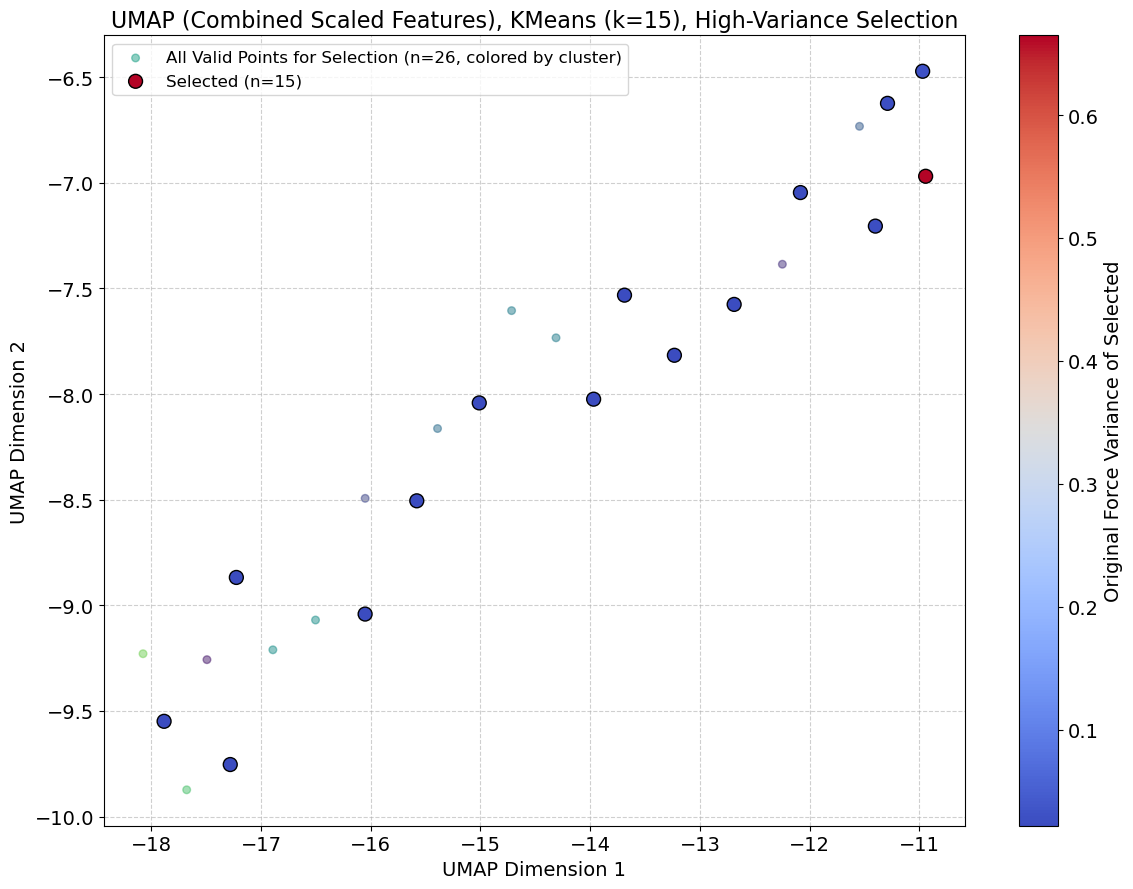

In [47]:
indices, fig = aa_analyzer.select_diverse_structures(n_select=15,
                                      aggregation_method='mean',
                                      umap_neighbors=15,
                                      umap_min_dist=0.1,
                                      random_state=42,
                                      plot=True)

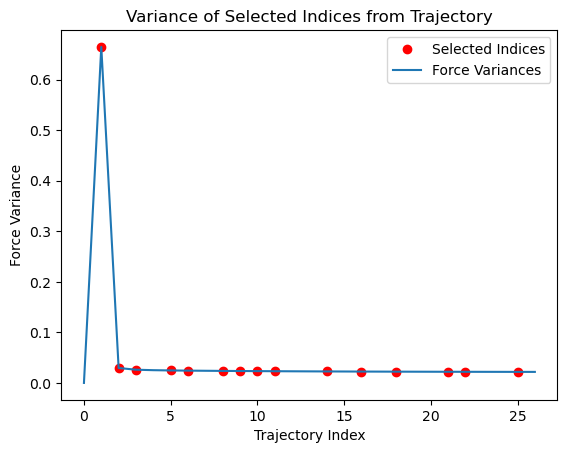

In [48]:

for atoms in atoms_list:
    if 'variance' not in atoms.info:
        atoms.info['variance'] = 0.0
variances = [atoms.info['variance'] for atoms in atoms_list]
selected_variances = [variances[idx] for idx in indices]
plt.plot(indices, selected_variances, 'ro', label='Selected Indices')
plt.plot(np.arange(len(variances)), variances, label='Force Variances')
plt.xlabel('Trajectory Index')
plt.ylabel('Force Variance')
plt.title('Variance of Selected Indices from Trajectory')
plt.legend()
plt.show()